# Finding Supernova Neutrinos - 18044930

To date we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. In this project you will investigate the feasibility of idenitfying supernova neutrino events in a new type of detector a liquid argon time-projection chamber. These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |


The images show the energy deposited in the liquid argon detector in a small slice of space and time. The meta information contains the following 64 numbers  for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

## Machine learning tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?
3. Test your machine learning classifier on simulated neutrinos overlaid with noise, what level of additional noise starts to impact your machine learning algorithm

### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise? 
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets
4. Write a machine learning algorithm to determin the number of final state particles in the image




## <a id="contents"></a> Contents

Due to the nature of the project the notebook has become quite long. In order to assist in the navigation of the notebook, bellow are links to specific parts of the project. 

* [Introduction](#intro)
* [Exploration of Data](#data_analysis)
* [Binary Classifier for Clean Neutrino Images](#BC1)
* [Binary Classifier for Neutrino Images with Noise](#BC2)
* [Predicting the Neutrino Energy](#PNE)
* [Predicting the Number of Final State Particles](#PNFSP)
* [Conclusion](#conc)
* [Bibliography](#bib)

## <a id="intro"></a> Introduction

The aim of this notebook is to be able to create a model that is able to successfully classify neutrino images from empty images with noise. This is so that it would be possible to notice if an influx of neutrinos were to colide with the Earth. Noticing this influx of neutrinos will warn scientist that a supernova might have occured and that the light emitted by this will reach the Earth shortly. Allowing scientists to aim optical telescopes in the right direction. With a model that can successfully classify images, the next step would be determining key values of the neutrino (such as the neutrino energy and the number of final state particles). This will help learn about not only neutrinos but also about the life cycle of stars.

##  <a id="data_analysis"></a> Exploration of Data


In [734]:
# imports for storing and manipulating the data
import numpy as np
import pandas as pd

#imports used for plotting
import matplotlib.pyplot as plt 
import matplotlib.patches as mpl_patches
plt.rcParams['figure.dpi']=200           #setting dots per inch of pictures

#imports used for 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# TensorFlow and tf.keras to carry out machine learning tasks
import tensorflow as tf
from tensorflow import keras

In [3]:
images=np.load('larImages.npy') #Load the images of the simulated neutrinos
meta=np.load('meta.npy')        #Load the meta data for the neutrinos
s = images.shape

print("images.shape",s)
print("meta.shape",meta.shape)

images.shape (10000, 100, 100)
meta.shape (10000, 64)


In [4]:
print("Row",int(meta[0][0]),"corresponds to a neutrino of",meta[0][1], "MeV and produced",int(meta[0][3]),"final state particles")

Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles


In [7]:
#creating a dataframe for easier access to data
meta_df = pd.DataFrame(meta).drop(labels=0,axis=1)
meta_df.head()

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
0,21.2005,2.0,6.0,12.0,21.2005,0.0,0.0,21.2005,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.8617,2.0,3.0,12.0,21.8617,0.0,0.0,21.8617,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17.6584,2.0,4.0,12.0,17.6584,0.0,0.0,17.6584,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.1423,2.0,5.0,12.0,20.1423,0.0,0.0,20.1423,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23.3148,2.0,5.0,12.0,23.3148,0.0,0.0,23.3148,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def add_noise(img,y_noise):
    """
    Inputs:
    img     numpy array that represents image
    y_noise mean value of noise to be added that follows a normal distribution with a standard deviation of 0.1 
    Returns:
    image with added noise
    """
    #random noise contribution drawn from a normal distribution centred at y_noise
    noise = (np.random.randn(img.shape[0],img.shape[1],img.shape[2])/10)+y_noise
    return img + noise

In [719]:
empty_sheets = np.zeros(s)                      #creating empty sheets that match the neutrino images 
empty_sheets_noise = add_noise(empty_sheets,0)  #creating new set of images that contain noise

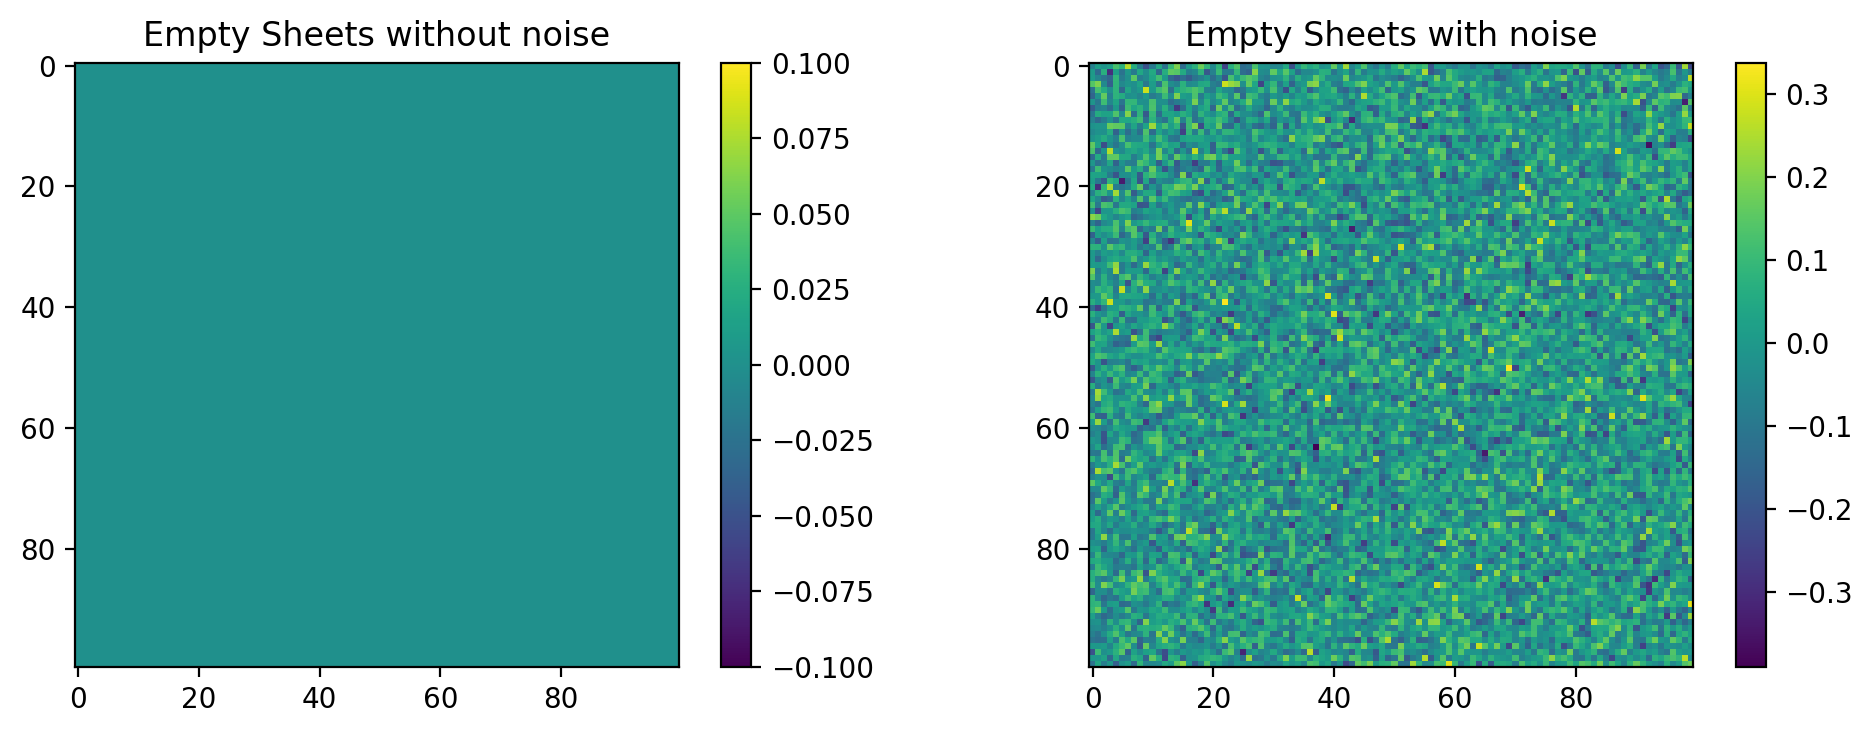

In [652]:
#plotting two empty sheets one with noise one without
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(empty_sheets[0])
plt.colorbar()
plt.title('Empty Sheets without noise');
plt.subplot(1,2,2)
plt.imshow(empty_sheets_noise[0])
plt.colorbar()
plt.title('Empty Sheets with noise');

In [12]:
#creating labels for the two sets of images
Labels = np.append(np.ones(s[0]),np.zeros(empty_sheets.shape[0])) 

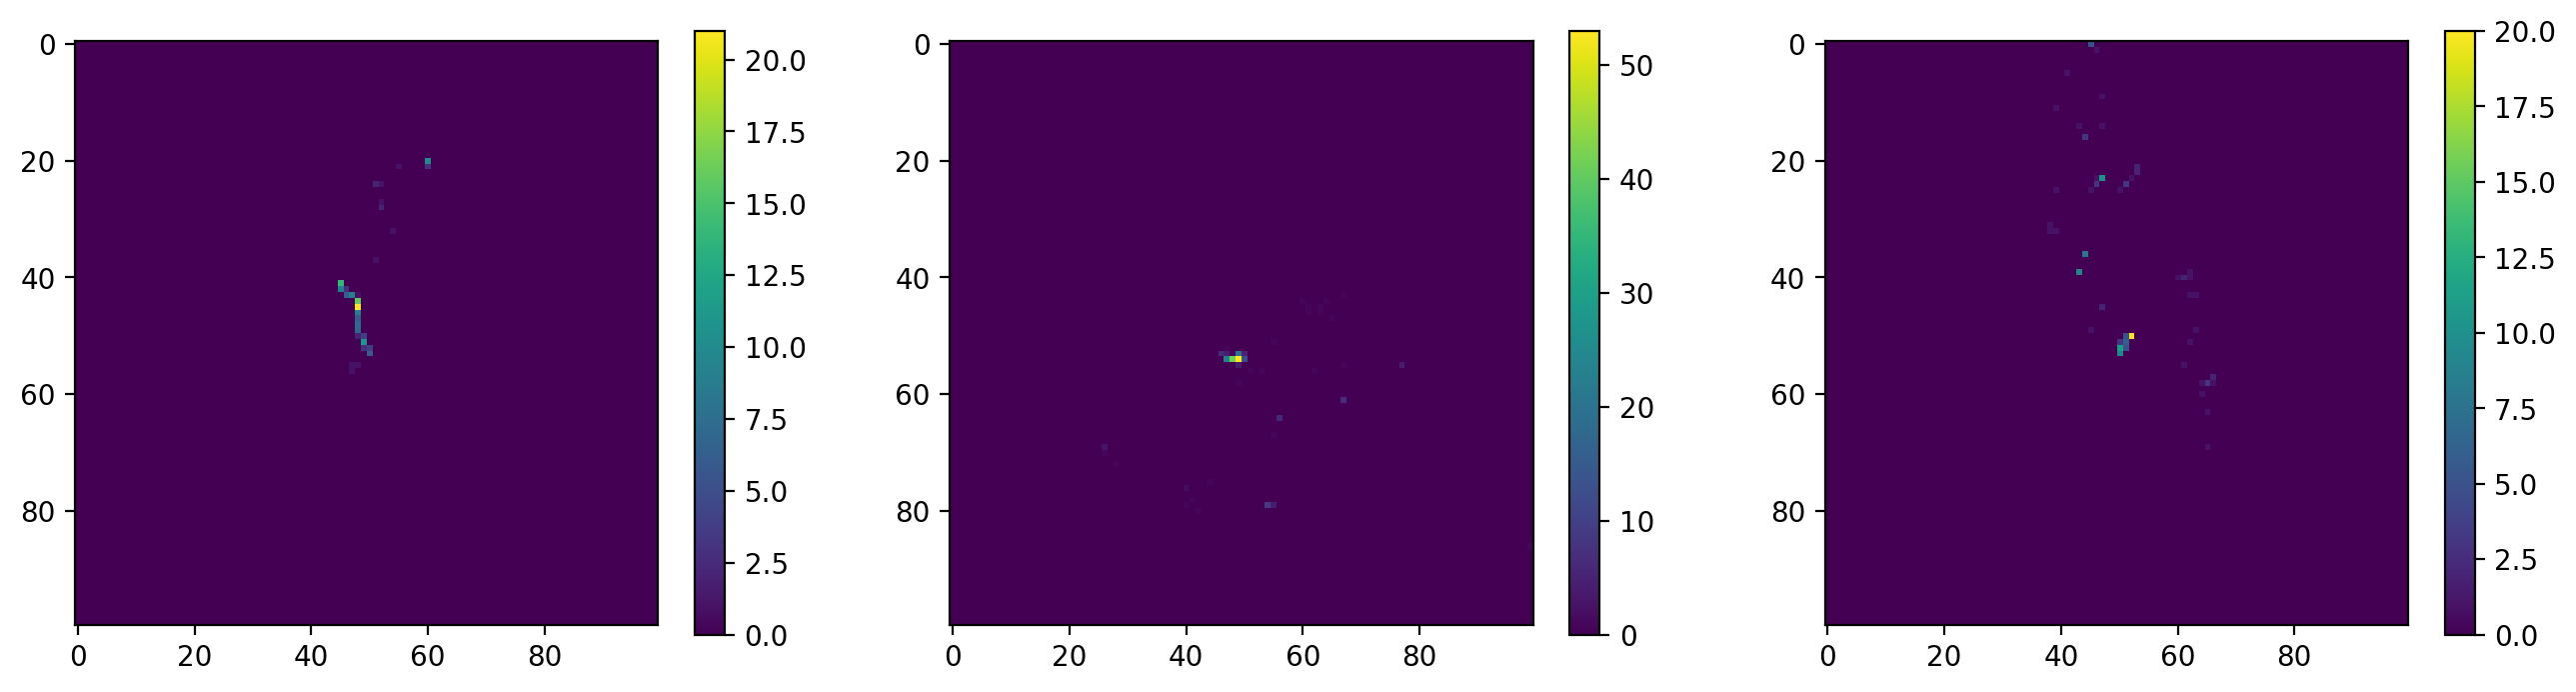

In [6]:
#plotting three different neutrino simulations
plt.figure(figsize=(16,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(images[i+4999])
    plt.colorbar()

This shows how each different neutrino signal has a different maximum value, this will need to be accounted for in when adding noise to images.

In [653]:
#extracting the maximum pixel value of each image
maximageval = np.zeros(10000)
for i in range(10000):
    maximageval[i] = np.amax(images[i])

Text(0.5, 1.0, 'Distribution of Maximum Pixel Value in Neutrino Images')

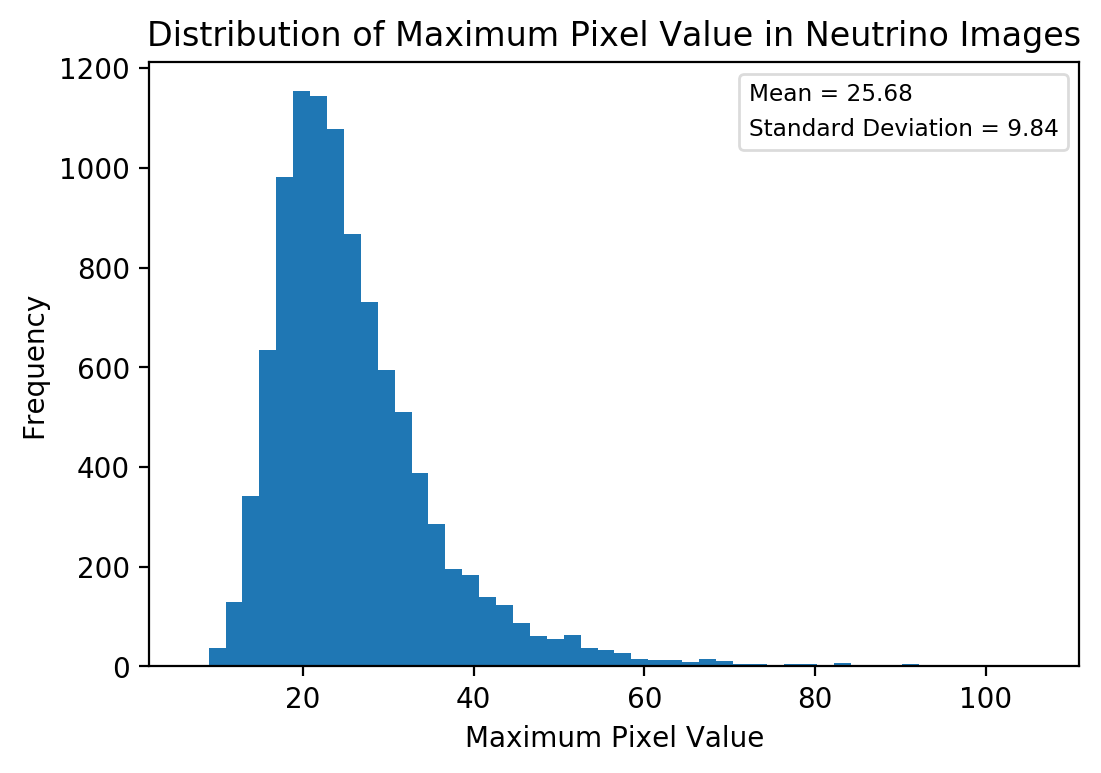

In [546]:
#statisticla measurements of the maximageval
mean = np.mean(maximageval)
stadev = np.std(maximageval)

#plot distribution of the maximum pixel value 
plt.hist(maximageval,bins=50);
plt.xlabel('Maximum Pixel Value')
plt.ylabel('Frequency')

#adds mean and standard deviation to the plot
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 2
labels = []
labels.append("Mean = {0:.4g}".format(mean))
labels.append("Standard Deviation = {0:.4g}".format(stadev))
plt.legend(handles, labels, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.title('Distribution of Maximum Pixel Value in Neutrino Images')

This distribution shows that most of the maximum pixel values are between 15-35. Meaning normalising each image by the same value might work for most of the solutions. 
[Back to Contents](#contents)

##  <a id="BC1"></a> Binary Classifier for Clean Neutrino Images

In this section a model will be created that will be aimed at classifying 'clean' images of neutrinos and empty sheets that have had some amount of noise added. To determine whether the model works it will be tested on a wide variety of noises. As the maximum pixel value of each image differs, two different normalisation methods will be used and compared to see which one is better. The first normalisation method will be by normalising each image based of the maximum image value of that image. The second method will be by normalising all the images by the maximum pixel value of the total set of images. In the first method all images will have a maximum pixel value of 1, whilst in the second only one image will have a maximum pixel value of 1. The noise added to the empty sheets is going to be in the form of a normal distribution that has a standard deviation of 0.1, mimicking that of electronic noise.

In [9]:
def pred(z):
    """
    *** THIS FUNCTION SHOULD BE USED ON OUTPUTS OF MODEL USING 'binary_crossentropy' LOSS FUNCTION ***
    Inputs:
    z  output from a binary classification model in form of numpy array of shape (None,1)
    
    Output:
    y  numpy array of shape (None,1) with values of either 0 or 1
    """
    shape = z.shape
    y = np.zeros(shape)
    
    #assinging the value of the binary classification 
    for i in range(shape[0]):
        if z[i] >= 0.5:
            y[i] = 1.
        else:
            y[i] = 0
    return y

In [115]:
def create_model1():
    """
    *** THIS FUNCTION SHOULD BE USED WITH A 'binary_crossentropy' LOSS FUNCTION ***
    
    Initiates new model used for the binary classification of clean neutrino signals from empty sheets
    with noise. The model uses a BatchNormalization layer to accelerate learning by rescalling the inputs.
    Then a 2D convolutional layer to create a feature map. Folled by a MaxPooling2d layer extracting the
    important structural elements of the feature map. To minimise over fitting a drop out layer is used.
    The last set of layers are the flatten layer followed by two dense layers, the last of which uses a 
    sigmoid activation necessary for binary classification.
    
    """
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(100,100,1)))
    model.add(keras.layers.Conv2D(4, (3,3),activation='relu',input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    return model
create_model1().summary()

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_218 (Bat (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 98, 98, 4)         40        
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 49, 49, 4)         0         
_________________________________________________________________
dropout_291 (Dropout)        (None, 49, 49, 4)         0         
_________________________________________________________________
flatten_112 (Flatten)        (None, 9604)              0         
_________________________________________________________________
dense_290 (Dense)            (None, 2)                 19210     
_________________________________________________________________
dense_291 (Dense)            (None, 1)              

In [126]:
def elnoisetosheet(images,noises,val_sample,test_sample,normtype):
    """
    Input: images      - neutrino images with no noise from 'larImages.npy'
           noises      - numpy array of noises that should be used when testing a model
                         minimum of two values of noise need to be given
           val_sample  - validation data sample size
           test_sample - test data sample size
           normtype    - type of normilisation either 'image': image / max of image iterate over each image
                                                      'array': images / max of images
    
    Output: numpy array of accuracies, numpy array of f1 scores (for all different values of noise)
                                     or
                         error if normtype is wrong
                      
    """
    Xshape = images.shape
    l1 = len(noises)
    
    #creating empty arrays for output values to be stored under
    acc = np.zeros(l1)
    f1 = np.zeros(l1)
    
    #normalises images according to normtype
    if normtype == 'image':
        images_scale = np.zeros(Xshape)
        for i in range(Xshape[0]):
            images_scale[i] = images[i]/np.amax(images[i])
    elif normtype == 'array':
        images_scale = images/np.amax(images)
    else:
        return 'error'
    
    #starts iteration over all noises
    for i in range(l1):
        empty_sheets_noise = add_noise(empty_sheets,noises[i])
        
        #setting up data for model
        X = np.concatenate((images_scale,empty_sheets_noise),axis=0)
        y = Labels
        
        X, y = shuffle(X,y) #shuffle to mix the neutrino and empty sheets together 
        
        #splitting the data into train, validation and test samples
        X_train = X[:int(Xshape[0]*(1-test_sample-val_sample))]
        y_train = y[:int(Xshape[0]*(1-test_sample-val_sample))]

        X_val = X[int(Xshape[0]*(1-test_sample-val_sample)):int(Xshape[0]*(1-test_sample))]
        y_val = y[int(Xshape[0]*(1-test_sample-val_sample)):int(Xshape[0]*(1-test_sample))] 
        
        X_test = X[int(Xshape[0]*(1-test_sample)):]
        y_test = y[int(Xshape[0]*(1-test_sample)):]       
        
        #reshaping image arrays so that they can be passed through CNN
        X_train = X_train.reshape(X_train.shape[0],100,100,1)
        y_train = y_train.reshape(y_train.shape[0],1)
        
        X_val = X_val.reshape(X_val.shape[0],100,100,1)
        y_val = y_val.reshape(y_val.shape[0],1)
        
        X_test  = X_test.reshape(X_test.shape[0],100,100,1)    
        y_test = y_test.reshape(y_test.shape[0],1)
        
        #initiating and copiling a new model
        estimator = create_model1()
        estimator.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
        
        #to prevent overfitting overfitting the model
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,
                                                   mode='min', verbose=1, patience=5,min_delta=0.001)

        history = estimator.fit(X_train, y_train, epochs=15,batch_size= 256,
                        validation_data=(X_val, y_val),callbacks=[early_stop])
        
        #storing the measures of how good the model is
        acc[i] = estimator.evaluate(X_test, y_test, verbose=0)[1]
        y_test_pred = estimator.predict(X_test)
        y_pred = pred(y_test_pred)
        f1[i] = f1_score(y_test, y_pred)
        
        
    return acc, f1
   

In [127]:
#1st test 
noises1 = np.linspace(0,6,10) #10 values of noise in range of 0-6
nts1acc,nts1f1 = elnoisetosheet(images,noises1,0.1,0.1,'image') #normalising by maximum pixel value of each image

Epoch 1/15
32/32 [==============================] - 7s 221ms/step - loss: 0.2576 - accuracy: 0.8888 - val_loss: 0.3100 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 7s 234ms/step - loss: 0.0298 - accuracy: 0.9984 - val_loss: 0.2485 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 8s 244ms/step - loss: 0.0113 - accuracy: 0.9995 - val_loss: 0.2026 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 8s 246ms/step - loss: 0.0068 - accuracy: 0.9999 - val_loss: 0.1691 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 256ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.1354 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 248ms/step - loss: 0.0036 - accuracy: 0.9999 - val_loss: 0.1045 - val_accuracy: 1.0000
Epoch 7/15
32/32 [==============================] - 8s 243ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0779 - val_accuracy: 1.0000
Epoch 

Epoch 1/15
32/32 [==============================] - 8s 256ms/step - loss: 0.0313 - accuracy: 0.9851 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 8s 245ms/step - loss: 1.0269e-06 - accuracy: 1.0000 - val_loss: 9.0187e-05 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 7s 234ms/step - loss: 7.7569e-07 - accuracy: 1.0000 - val_loss: 1.6472e-05 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 7s 234ms/step - loss: 7.4217e-07 - accuracy: 1.0000 - val_loss: 5.6427e-06 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 235ms/step - loss: 7.3369e-07 - accuracy: 1.0000 - val_loss: 2.7067e-06 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 236ms/step - loss: 8.9685e-07 - accuracy: 1.0000 - val_loss: 1.6174e-06 - val_accuracy: 1.0000
Epoch 7/15
32/32 [==============================] - 8s 240ms/step - loss: 7.8700e-07 - accuracy: 1.0000 - va

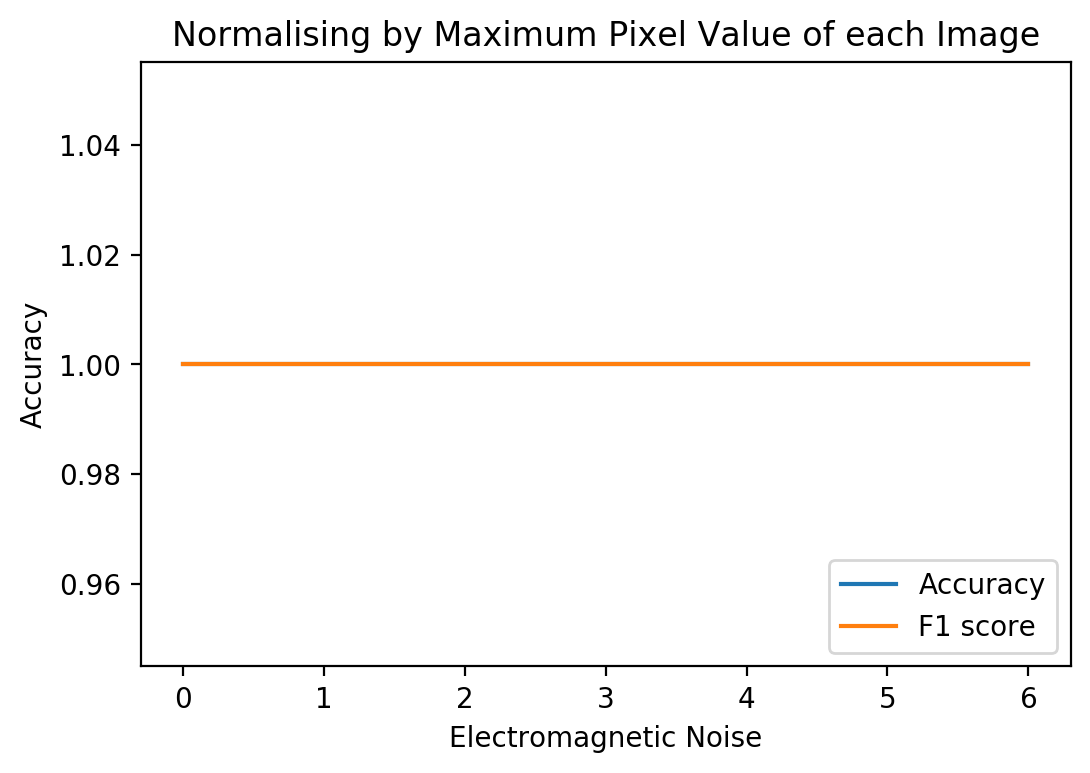

In [655]:
#plotting the f1 score and accuracy for the first test
plt.title('Normalising by Maximum Pixel Value of each Image')
plt.plot(noises1,nts1acc, label = 'Accuracy')
plt.plot(noises1,nts1f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [131]:
#2nd test
noises2 = np.linspace(15,100,5) #5 values of noise in range 15-100
nts2acc,nts2f1 = elnoisetosheet(images,noises2,0.1,0.1,'image') #normalising by maximum pixel value of each image

Epoch 1/15
32/32 [==============================] - 8s 236ms/step - loss: 0.0339 - accuracy: 0.9825 - val_loss: 1.1657e-07 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 8s 249ms/step - loss: 9.7165e-10 - accuracy: 1.0000 - val_loss: 2.9161e-10 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 12s 384ms/step - loss: 7.7587e-10 - accuracy: 1.0000 - val_loss: 1.1472e-11 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 8s 250ms/step - loss: 8.5250e-10 - accuracy: 1.0000 - val_loss: 1.4611e-12 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 236ms/step - loss: 8.3346e-10 - accuracy: 1.0000 - val_loss: 7.5199e-13 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 263ms/step - loss: 8.5775e-10 - accuracy: 1.0000 - val_loss: 3.2895e-12 - val_accuracy: 1.0000
Epoch 00006: early stopping
Epoch 1/15
32/32 [==============================] - 8s 245ms/step - loss: 0

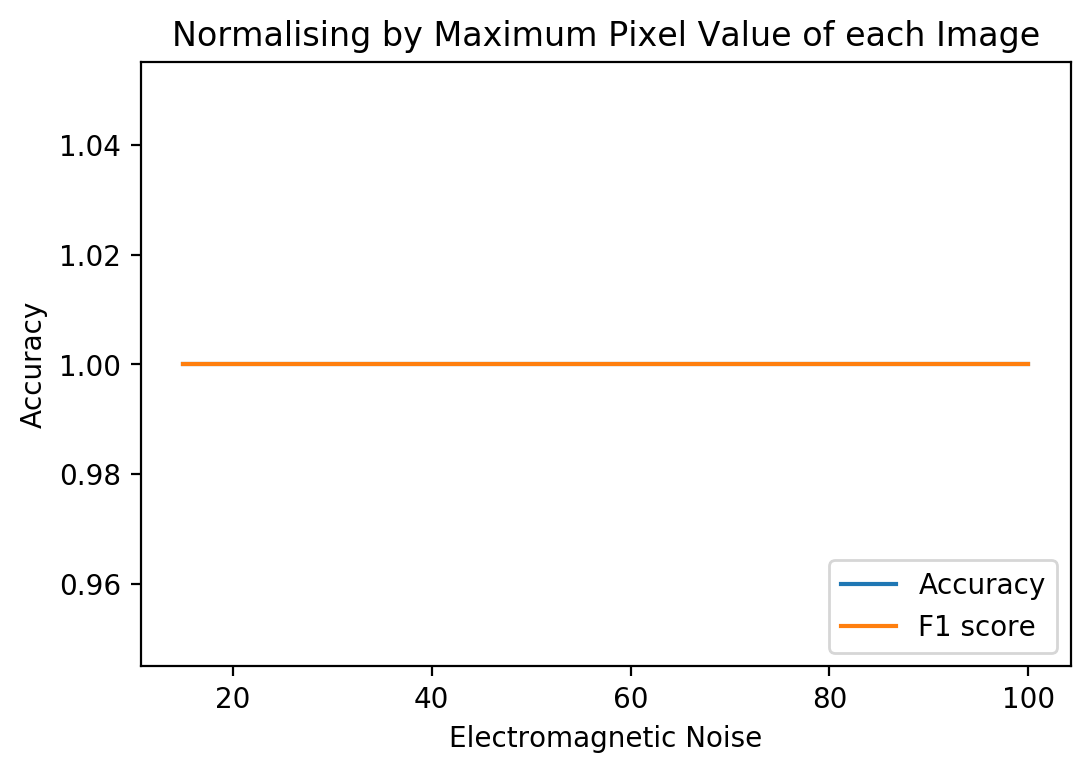

In [657]:
plt.title('Normalising by Maximum Pixel Value of each Image')
plt.plot(noises2,nts2acc, label = 'Accuracy')
plt.plot(noises2,nts2f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### /Max Array

In [134]:
#3rd test with 10 values of noise over the range of 0-6
nts3acc,nts3f1 = elnoisetosheet(images,noises1,0.1,0.1,'array') #normalising by maximum pixel value of all images

Epoch 1/15
32/32 [==============================] - 7s 217ms/step - loss: 0.4069 - accuracy: 0.6267 - val_loss: 0.3445 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 7s 234ms/step - loss: 0.2880 - accuracy: 0.9481 - val_loss: 0.3196 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 7s 234ms/step - loss: 0.2076 - accuracy: 0.9976 - val_loss: 0.2849 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 8s 237ms/step - loss: 0.1232 - accuracy: 0.9995 - val_loss: 0.2407 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 253ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.1995 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 244ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.1627 - val_accuracy: 1.0000
Epoch 7/15
32/32 [==============================] - 8s 241ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 1.0000
Epoch 

Epoch 2/15
32/32 [==============================] - 8s 234ms/step - loss: 4.6541e-10 - accuracy: 1.0000 - val_loss: 4.8894e-07 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 8s 243ms/step - loss: 3.2216e-10 - accuracy: 1.0000 - val_loss: 3.2324e-08 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 8s 246ms/step - loss: 2.6029e-10 - accuracy: 1.0000 - val_loss: 5.6370e-09 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 236ms/step - loss: 2.7770e-10 - accuracy: 1.0000 - val_loss: 1.7919e-09 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 239ms/step - loss: 5.2709e-10 - accuracy: 1.0000 - val_loss: 7.9697e-10 - val_accuracy: 1.0000
Epoch 00006: early stopping
Epoch 1/15
32/32 [==============================] - 7s 227ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 5.5153e-05 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 7s 232ms/step - loss: 1.

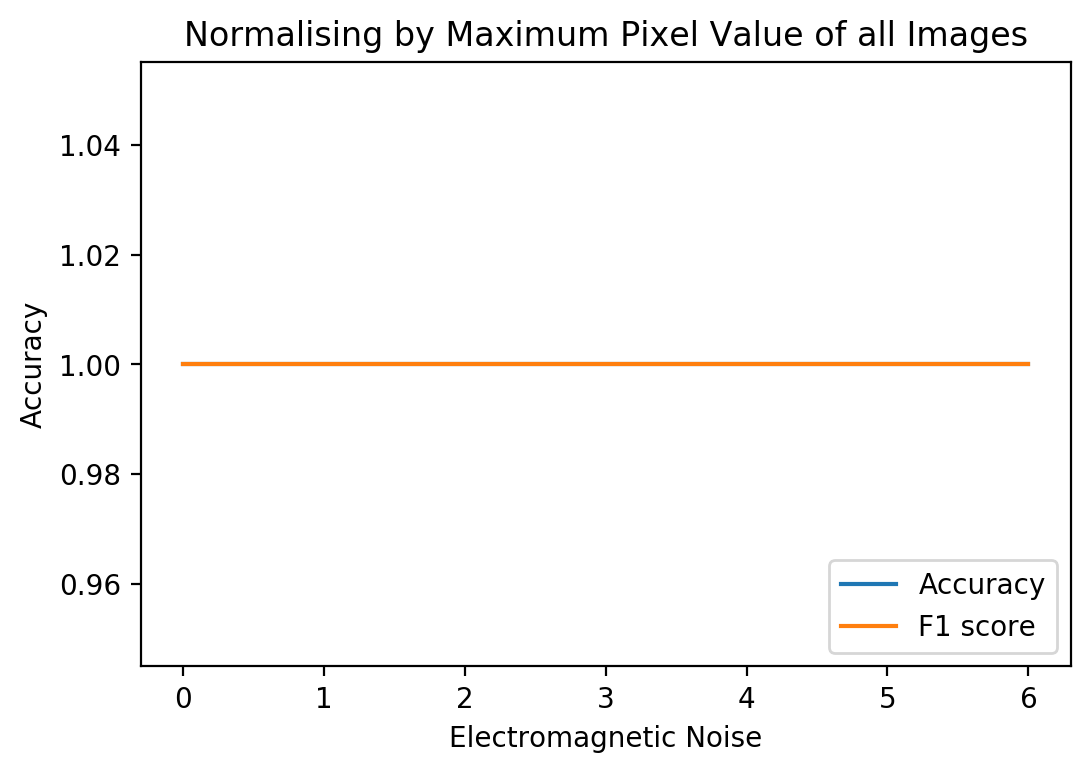

In [659]:
plt.title('Normalising by Maximum Pixel Value of all Images')
plt.plot(noises1,nts3acc, label = 'Accuracy')
plt.plot(noises1,nts3f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [136]:
#4th test with 5 values of noise over the range of 15-100 
nts4acc,nts4f1 = elnoisetosheet(images,noises2,0.1,0.1,'array') #normalising by maximum pixel value of all images

Epoch 1/15
32/32 [==============================] - 7s 230ms/step - loss: 0.3482 - accuracy: 0.9756 - val_loss: 0.3146 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 8s 247ms/step - loss: 0.3050 - accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 7s 234ms/step - loss: 0.2788 - accuracy: 1.0000 - val_loss: 0.2628 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 8s 240ms/step - loss: 0.2540 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 250ms/step - loss: 0.2306 - accuracy: 1.0000 - val_loss: 0.2165 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 7s 233ms/step - loss: 0.2086 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 1.0000
Epoch 7/15
32/32 [==============================] - 8s 247ms/step - loss: 0.1882 - accuracy: 1.0000 - val_loss: 0.1761 - val_accuracy: 1.0000
Epoch 

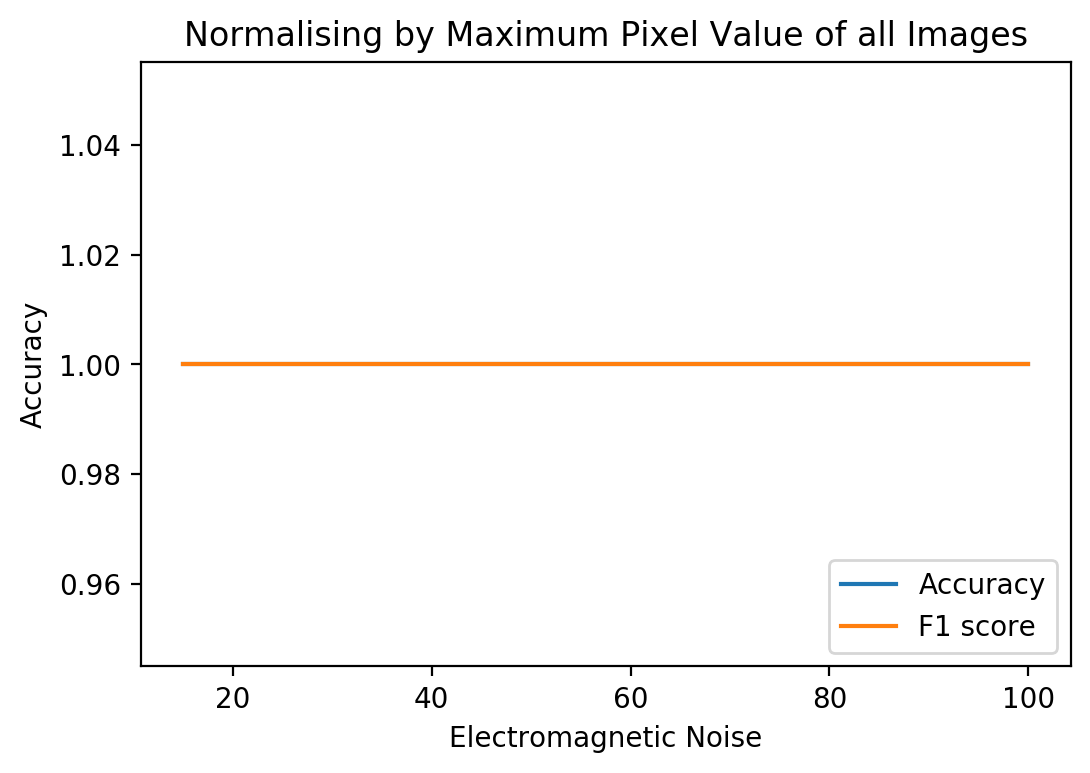

In [660]:
plt.title('Normalising by Maximum Pixel Value of all Images')
plt.plot(noises,nts4acc, label = 'Accuracy')
plt.plot(noises,nts4f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

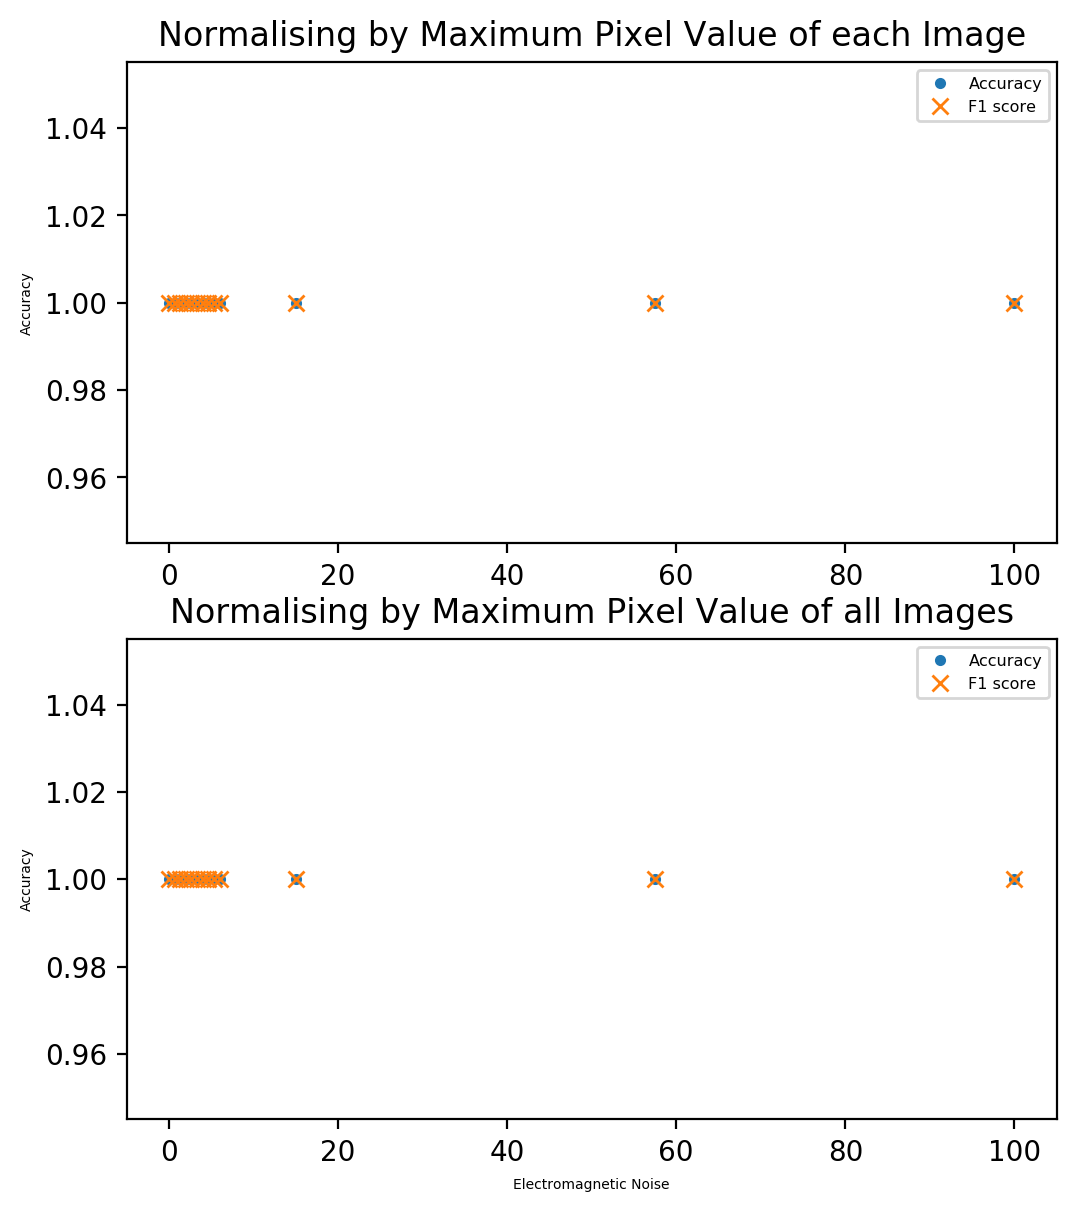

In [670]:
#comparing the two different normalisation methods 
fig1 = plt.figure(figsize=(6,7))
ax1 = fig1.add_subplot(211)
ax1.plot(np.append(noises1,noises2),np.append(nts1acc,nts2acc),'.', label = 'Accuracy')
ax1.plot(np.append(noises1,noises2),np.append(nts1f1,nts2f1),'x', label = 'F1 score')
ax1.set_ylabel('Accuracy',fontsize= 5)
ax1.legend(loc='best',fontsize ='xx-small')
ax1.set_title('Normalising by Maximum Pixel Value of each Image');

ax2 = fig1.add_subplot(212)
ax2.plot(np.append(noises1,noises2),np.append(nts3acc,nts4acc),'.', label = 'Accuracy')
ax2.plot(np.append(noises1,noises2),np.append(nts3f1,nts4f1),'x', label = 'F1 score')
ax2.set_xlabel('Electromagnetic Noise',fontsize= 5)
ax2.set_ylabel('Accuracy',fontsize= 5)
ax2.legend(loc='best',fontsize ='xx-small')
ax2.set_title('Normalising by Maximum Pixel Value of all Images');


This plot shows that over all these noises no matter what the normalisation method is the model can easily determin which images contain neutrino signals.

[Back to Contents](#contents)

##  <a id="BC2"></a> Binary Classifier for Neutrino Images with Noise

As the model is accurate when classifying 'clean' neutrino sheets against noisy images, a new model should be made trying to mimic the conditions found in a Liquid Argon Time-Projection Chamber. Due to the strong electric field used in the chamber, electronic noise should be expected and so adding this electronic noise to both the simulated neutrino images and the empty sheets.

In [21]:
def create_model2():
    """
    *** THIS FUNCTION SHOULD BE USED WITH A 'binary_crossentropy' LOSS FUNCTION ***
    
    Initiates new model used for the binary classification of neutrino signals from empty sheets both of
    with noise. The model uses a BatchNormalization layer to accelerate learning by rescalling the inputs.
    Then there are two sets of three layers. These sets are made from a 2D convolutional layer to create 
    a feature map. Folled by a MaxPooling2d layer extracting the important structural elements of the feature
    map. To minimise over fitting a drop out layer is used. The last set of layers are the flatten layer 
    followed by two dense layers, the last of which uses a sigmoid activation necessary for binary classification.
    The dense layers are seperated by one final dropout layer to prevent overfitting.
    
    """
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(100,100,1)))
    model.add(keras.layers.Conv2D(4, (3,3),activation='relu',input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(4, (3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    return model

In [22]:
def elnoisetoboth(images,noises,val_sample,test_sample,normtype):
    """
    Input: images      - neutrino images with no noise from 'larImages.npy'
           noises      - numpy array of noises that should be used when testing a model
                         minimum of two values of noise need to be given
           val_sample  - validation data sample size
           test_sample - test data sample size
           normtype    - type of normilisation either 'image': image / max of image iterate over each image
                                                      'array': images / max of images
    
    Output: numpy array of accuracies, numpy array of f1 scores (for all different values of noise)
                                     or
                         error if normtype is wrong
                      
    """
    Xshape = images.shape
    l1 = len(noises)
    
    #creating empty arrays for output values to be stored under
    acc = np.zeros(l1)
    f1 = np.zeros(l1)
    
    #normalises images according to normtype
    if normtype == 'image':
        images_scale = np.zeros(images.shape)
        for i in range(Xshape[0]):
            images_scale[i] = images[i]/np.amax(images[i])
    elif normtype == 'array':
        images_scale = images/np.amax(images)
    else:
        return 'error'
    
    #starts iteration over all noises
    for i in range(l1):
        #adding noise to both neutrino images and empty sheets
        images_scale_noise = add_noise(images_scale,noises[i])
        empty_sheets_noise = add_noise(empty_sheets,noises[i])
        
        #setting up data for model
        X = np.concatenate((images_scale_noise,empty_sheets_noise),axis=0)
        y = Labels
        
        X, y = shuffle(X,y) #shuffle to mix the neutrino and empty sheets together
        
        #splitting the data into train, validation and test samples
        X_train = X[:int(Xshape[0]*(1-test_sample-val_sample))]
        y_train = y[:int(Xshape[0]*(1-test_sample-val_sample))]

        X_val = X[int(Xshape[0]*(1-test_sample-val_sample)):int(Xshape[0]*(1-test_sample))]
        y_val = y[int(Xshape[0]*(1-test_sample-val_sample)):int(Xshape[0]*(1-test_sample))] 
        
        X_test = X[int(Xshape[0]*(1-test_sample)):]
        y_test = y[int(Xshape[0]*(1-test_sample)):]       
        
        #reshaping image arrays so that they can be passed through CNN
        X_train = X_train.reshape(X_train.shape[0],100,100,1)
        y_train = y_train.reshape(y_train.shape[0],1)
        
        X_val = X_val.reshape(X_val.shape[0],100,100,1)
        y_val = y_val.reshape(y_val.shape[0],1)
        
        X_test  = X_test.reshape(X_test.shape[0],100,100,1)    
        y_test = y_test.reshape(y_test.shape[0],1)
        
        #initiating and copiling a new model
        estimator = create_model2()
        estimator.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
        
        #to prevent overfitting of model
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,
                                                   mode='min', verbose=1, patience=15,min_delta=0.001)

        history = estimator.fit(X_train, y_train, epochs=40,batch_size= 256,
                        validation_data=(X_val, y_val),callbacks=[early_stop])
        
        #storing the measures of how good the model is
        acc[i] = estimator.evaluate(X_test, y_test, verbose=0)[1]
        y_test_pred = estimator.predict(X_test)
        y_pred = pred(y_test_pred)
        f1[i] = f1_score(y_test, y_pred)
        
        
    return acc, f1

In [26]:
#1st test
noises3 = np.linspace(0.,0.75,10) #10 values of noise in range of 0-0.75 
ntb1acc, ntb1f1 = elnoisetoboth(images,noises3,0.1,0.1,'image') #normalising by maximum pixel value of each image

Epoch 1/40
32/32 [==============================] - 9s 284ms/step - loss: 0.9693 - accuracy: 0.5201 - val_loss: 0.6853 - val_accuracy: 0.6680
Epoch 2/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6398 - accuracy: 0.6327 - val_loss: 0.6753 - val_accuracy: 0.7180
Epoch 3/40
32/32 [==============================] - 10s 297ms/step - loss: 0.5244 - accuracy: 0.7460 - val_loss: 0.6475 - val_accuracy: 0.8850
Epoch 4/40
32/32 [==============================] - 10s 299ms/step - loss: 0.3528 - accuracy: 0.8586 - val_loss: 0.5561 - val_accuracy: 0.9620
Epoch 5/40
32/32 [==============================] - 10s 322ms/step - loss: 0.2097 - accuracy: 0.9196 - val_loss: 0.4872 - val_accuracy: 0.9890
Epoch 6/40
32/32 [==============================] - 10s 313ms/step - loss: 0.1379 - accuracy: 0.9532 - val_loss: 0.4275 - val_accuracy: 0.9710
Epoch 7/40
32/32 [==============================] - 10s 306ms/step - loss: 0.1064 - accuracy: 0.9621 - val_loss: 0.3657 - val_accuracy: 0.9480
E

32/32 [==============================] - 17s 521ms/step - loss: 0.0317 - accuracy: 0.9908 - val_loss: 0.0231 - val_accuracy: 0.9980
Epoch 19/40
32/32 [==============================] - 16s 496ms/step - loss: 0.0265 - accuracy: 0.9918 - val_loss: 0.0165 - val_accuracy: 0.9980
Epoch 20/40
32/32 [==============================] - 17s 545ms/step - loss: 0.0263 - accuracy: 0.9916 - val_loss: 0.0141 - val_accuracy: 0.9980
Epoch 21/40
32/32 [==============================] - 17s 538ms/step - loss: 0.0250 - accuracy: 0.9929 - val_loss: 0.0134 - val_accuracy: 0.9980
Epoch 22/40
32/32 [==============================] - 17s 539ms/step - loss: 0.0232 - accuracy: 0.9930 - val_loss: 0.0121 - val_accuracy: 0.9980
Epoch 23/40
32/32 [==============================] - 18s 555ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.0116 - val_accuracy: 0.9980
Epoch 24/40
32/32 [==============================] - 18s 557ms/step - loss: 0.0195 - accuracy: 0.9942 - val_loss: 0.0130 - val_accuracy: 0.9980
Epoc

32/32 [==============================] - 10s 315ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 36/40
32/32 [==============================] - 10s 318ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 37/40
32/32 [==============================] - 10s 307ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.0066 - val_accuracy: 0.9990
Epoch 38/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0125 - accuracy: 0.9956 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 39/40
32/32 [==============================] - 10s 318ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0065 - val_accuracy: 0.9990
Epoch 40/40
32/32 [==============================] - 10s 316ms/step - loss: 0.0112 - accuracy: 0.9970 - val_loss: 0.0076 - val_accuracy: 0.9990
Epoch 1/40
32/32 [==============================] - 11s 349ms/step - loss: 0.8544 - accuracy: 0.5169 - val_loss: 0.6880 - val_accuracy: 0.5060
Epoch

32/32 [==============================] - 9s 296ms/step - loss: 0.0810 - accuracy: 0.9731 - val_loss: 0.1248 - val_accuracy: 0.9930
Epoch 13/40
32/32 [==============================] - 11s 332ms/step - loss: 0.0729 - accuracy: 0.9764 - val_loss: 0.0907 - val_accuracy: 0.9920
Epoch 14/40
32/32 [==============================] - 11s 338ms/step - loss: 0.0628 - accuracy: 0.9809 - val_loss: 0.0708 - val_accuracy: 0.9930
Epoch 15/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0570 - accuracy: 0.9830 - val_loss: 0.0505 - val_accuracy: 0.9910
Epoch 16/40
32/32 [==============================] - 10s 306ms/step - loss: 0.0558 - accuracy: 0.9827 - val_loss: 0.0455 - val_accuracy: 0.9920
Epoch 17/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0477 - accuracy: 0.9847 - val_loss: 0.0380 - val_accuracy: 0.9930
Epoch 18/40
32/32 [==============================] - 10s 307ms/step - loss: 0.0417 - accuracy: 0.9861 - val_loss: 0.0321 - val_accuracy: 0.9940
Epoch

32/32 [==============================] - 9s 294ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0137 - val_accuracy: 0.9960
Epoch 30/40
32/32 [==============================] - 9s 292ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0130 - val_accuracy: 0.9980
Epoch 31/40
32/32 [==============================] - 9s 296ms/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 0.0125 - val_accuracy: 0.9980
Epoch 32/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0153 - accuracy: 0.9955 - val_loss: 0.0123 - val_accuracy: 0.9980
Epoch 33/40
32/32 [==============================] - 10s 309ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0126 - val_accuracy: 0.9980
Epoch 34/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0116 - val_accuracy: 0.9980
Epoch 35/40
32/32 [==============================] - 10s 306ms/step - loss: 0.0087 - accuracy: 0.9977 - val_loss: 0.0109 - val_accuracy: 0.9980
Epoch 36

32/32 [==============================] - 10s 316ms/step - loss: 0.1260 - accuracy: 0.9553 - val_loss: 0.2995 - val_accuracy: 0.9880
Epoch 7/40
32/32 [==============================] - 10s 299ms/step - loss: 0.1052 - accuracy: 0.9640 - val_loss: 0.3111 - val_accuracy: 0.9700
Epoch 8/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0841 - accuracy: 0.9722 - val_loss: 0.3152 - val_accuracy: 0.9660
Epoch 9/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0775 - accuracy: 0.9745 - val_loss: 0.3105 - val_accuracy: 0.9710
Epoch 10/40
32/32 [==============================] - 10s 324ms/step - loss: 0.0627 - accuracy: 0.9805 - val_loss: 0.2870 - val_accuracy: 0.9750
Epoch 11/40
32/32 [==============================] - 10s 322ms/step - loss: 0.0553 - accuracy: 0.9831 - val_loss: 0.2646 - val_accuracy: 0.9770
Epoch 12/40
32/32 [==============================] - 11s 329ms/step - loss: 0.0501 - accuracy: 0.9855 - val_loss: 0.2230 - val_accuracy: 0.9820
Epoch 13

32/32 [==============================] - 12s 367ms/step - loss: 0.0187 - accuracy: 0.9946 - val_loss: 0.0144 - val_accuracy: 0.9980
Epoch 24/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0101 - val_accuracy: 0.9970
Epoch 25/40
32/32 [==============================] - 10s 308ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0117 - val_accuracy: 0.9980
Epoch 26/40
32/32 [==============================] - 10s 309ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0096 - val_accuracy: 0.9980
Epoch 27/40
32/32 [==============================] - 10s 302ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 28/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.0089 - val_accuracy: 0.9980
Epoch 29/40
32/32 [==============================] - 10s 308ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0101 - val_accuracy: 0.9980
Epoc

32/32 [==============================] - 10s 308ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0066 - val_accuracy: 0.9990


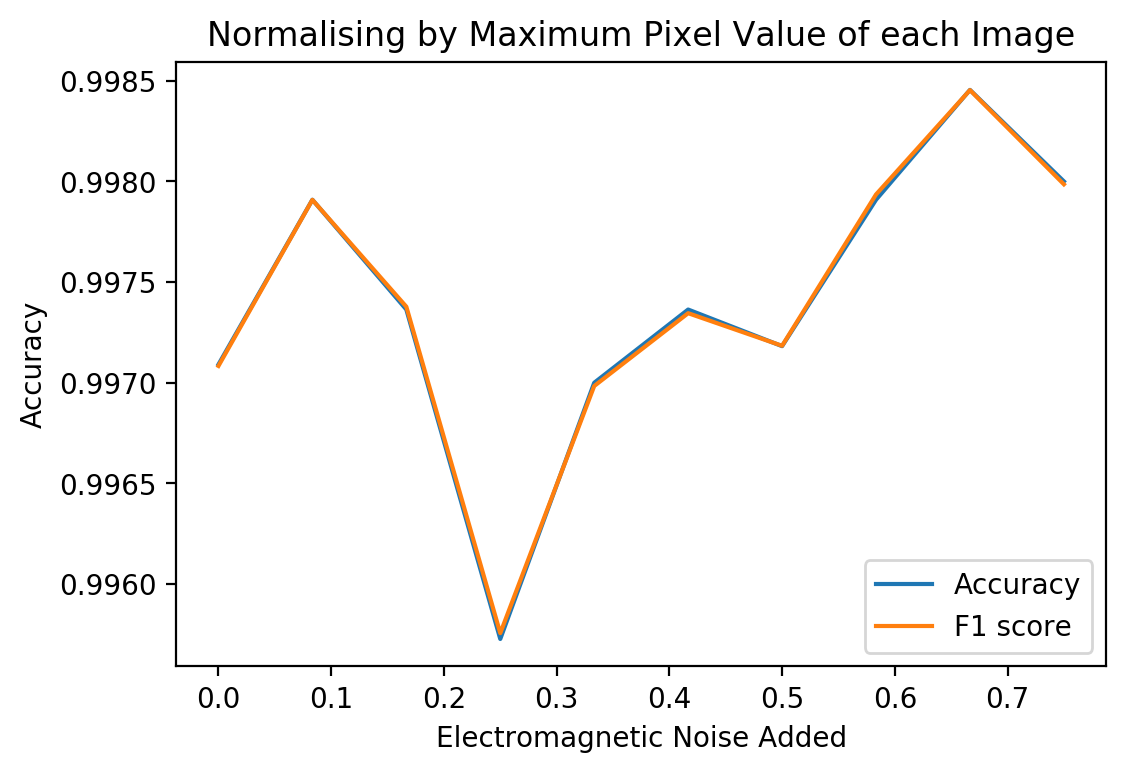

In [671]:
plt.title('Normalising by Maximum Pixel Value of each Image')
plt.plot(noises3,ntb1acc, label = 'Accuracy')
plt.plot(noises3,ntb1f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise Added')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [112]:
#2nd test
noises4 = np.linspace(0.5,2.5,50) #50 values of noise in range of 0.5-2.5
ntb2acc, ntb2f1 = elnoisetoboth(images,noises4,0.1,0.1,'image') #normalising by maximum pixel value of each image

Epoch 1/40
32/32 [==============================] - 10s 304ms/step - loss: 0.8623 - accuracy: 0.5175 - val_loss: 0.6877 - val_accuracy: 0.6300
Epoch 2/40
32/32 [==============================] - 9s 296ms/step - loss: 0.6635 - accuracy: 0.5941 - val_loss: 0.6780 - val_accuracy: 0.7800
Epoch 3/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5609 - accuracy: 0.7159 - val_loss: 0.6501 - val_accuracy: 0.8810
Epoch 4/40
32/32 [==============================] - 9s 294ms/step - loss: 0.4181 - accuracy: 0.8330 - val_loss: 0.5756 - val_accuracy: 0.9340
Epoch 5/40
32/32 [==============================] - 9s 295ms/step - loss: 0.2687 - accuracy: 0.8997 - val_loss: 0.4577 - val_accuracy: 0.9870
Epoch 6/40
32/32 [==============================] - 10s 319ms/step - loss: 0.1700 - accuracy: 0.9409 - val_loss: 0.3625 - val_accuracy: 0.9760
Epoch 7/40
32/32 [==============================] - 10s 320ms/step - loss: 0.1199 - accuracy: 0.9592 - val_loss: 0.3347 - val_accuracy: 0.9800
Epo

32/32 [==============================] - 9s 281ms/step - loss: 0.0247 - accuracy: 0.9937 - val_loss: 0.0286 - val_accuracy: 0.9960
Epoch 19/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.0239 - val_accuracy: 0.9960
Epoch 20/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0228 - accuracy: 0.9935 - val_loss: 0.0230 - val_accuracy: 0.9940
Epoch 21/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.0195 - val_accuracy: 0.9940
Epoch 22/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.0156 - val_accuracy: 0.9970
Epoch 23/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0186 - val_accuracy: 0.9940
Epoch 24/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0141 - val_accuracy: 0.9950
Epoch 25/40

32/32 [==============================] - 9s 286ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.0122 - val_accuracy: 0.9960
Epoch 36/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0111 - val_accuracy: 0.9960
Epoch 37/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0113 - val_accuracy: 0.9960
Epoch 38/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0116 - val_accuracy: 0.9970
Epoch 39/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0116 - val_accuracy: 0.9970
Epoch 40/40
32/32 [==============================] - 10s 298ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0110 - val_accuracy: 0.9960
Epoch 1/40
32/32 [==============================] - 10s 315ms/step - loss: 0.8075 - accuracy: 0.5564 - val_loss: 0.6837 - val_accuracy: 0.6840
Epoch 2/40

32/32 [==============================] - 11s 328ms/step - loss: 0.0758 - accuracy: 0.9747 - val_loss: 0.0820 - val_accuracy: 0.9910
Epoch 13/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0681 - accuracy: 0.9784 - val_loss: 0.0661 - val_accuracy: 0.9910
Epoch 14/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0654 - accuracy: 0.9789 - val_loss: 0.0503 - val_accuracy: 0.9890
Epoch 15/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.0411 - val_accuracy: 0.9930
Epoch 16/40
32/32 [==============================] - 9s 293ms/step - loss: 0.0553 - accuracy: 0.9822 - val_loss: 0.0350 - val_accuracy: 0.9920
Epoch 17/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0464 - accuracy: 0.9856 - val_loss: 0.0313 - val_accuracy: 0.9930
Epoch 18/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.0274 - val_accuracy: 0.9930
Epoch 19/

32/32 [==============================] - 9s 290ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0123 - val_accuracy: 0.9990
Epoch 30/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.0102 - val_accuracy: 0.9980
Epoch 31/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0088 - val_accuracy: 0.9970
Epoch 32/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0104 - accuracy: 0.9973 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 33/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0101 - val_accuracy: 0.9980
Epoch 34/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 35/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0092 - accuracy: 0.9967 - val_loss: 0.0107 - val_accuracy: 0.9990
Epoch 36/40

32/32 [==============================] - 9s 291ms/step - loss: 0.1417 - accuracy: 0.9507 - val_loss: 0.2882 - val_accuracy: 0.9670
Epoch 7/40
32/32 [==============================] - 9s 288ms/step - loss: 0.1132 - accuracy: 0.9644 - val_loss: 0.2669 - val_accuracy: 0.9570
Epoch 8/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0989 - accuracy: 0.9672 - val_loss: 0.2776 - val_accuracy: 0.9530
Epoch 9/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0888 - accuracy: 0.9721 - val_loss: 0.2482 - val_accuracy: 0.9850
Epoch 10/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.2031 - val_accuracy: 0.9940
Epoch 11/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0661 - accuracy: 0.9790 - val_loss: 0.1600 - val_accuracy: 0.9960
Epoch 12/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0569 - accuracy: 0.9833 - val_loss: 0.1352 - val_accuracy: 0.9960
Epoch 13/40
32

32/32 [==============================] - 10s 311ms/step - loss: 0.0208 - accuracy: 0.9948 - val_loss: 0.0111 - val_accuracy: 0.9990
Epoch 24/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.0128 - val_accuracy: 0.9990
Epoch 25/40
32/32 [==============================] - 10s 318ms/step - loss: 0.0205 - accuracy: 0.9940 - val_loss: 0.0153 - val_accuracy: 0.9980
Epoch 26/40
32/32 [==============================] - 10s 314ms/step - loss: 0.0192 - accuracy: 0.9933 - val_loss: 0.0122 - val_accuracy: 0.9980
Epoch 27/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0178 - accuracy: 0.9937 - val_loss: 0.0101 - val_accuracy: 0.9980
Epoch 28/40
32/32 [==============================] - 10s 314ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0102 - val_accuracy: 0.9980
Epoch 29/40
32/32 [==============================] - 10s 314ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0076 - val_accuracy: 0.9990
Epoc

32/32 [==============================] - 10s 311ms/step - loss: 0.0142 - accuracy: 0.9966 - val_loss: 0.0104 - val_accuracy: 0.9970
Epoch 1/40
32/32 [==============================] - 10s 301ms/step - loss: 0.9372 - accuracy: 0.5408 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 2/40
32/32 [==============================] - 10s 307ms/step - loss: 0.6265 - accuracy: 0.6459 - val_loss: 0.7004 - val_accuracy: 0.5200
Epoch 3/40
32/32 [==============================] - 10s 310ms/step - loss: 0.4508 - accuracy: 0.7981 - val_loss: 0.6804 - val_accuracy: 0.5200
Epoch 4/40
32/32 [==============================] - 10s 317ms/step - loss: 0.3083 - accuracy: 0.8776 - val_loss: 0.5577 - val_accuracy: 0.5290
Epoch 5/40
32/32 [==============================] - 10s 314ms/step - loss: 0.2134 - accuracy: 0.9240 - val_loss: 0.6088 - val_accuracy: 0.5200
Epoch 6/40
32/32 [==============================] - 10s 315ms/step - loss: 0.1677 - accuracy: 0.9409 - val_loss: 0.3923 - val_accuracy: 0.8140
Epoch 7/40

32/32 [==============================] - 10s 310ms/step - loss: 0.0317 - accuracy: 0.9908 - val_loss: 0.0162 - val_accuracy: 0.9990
Epoch 18/40
32/32 [==============================] - 10s 314ms/step - loss: 0.0282 - accuracy: 0.9902 - val_loss: 0.0126 - val_accuracy: 0.9990
Epoch 19/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 20/40
32/32 [==============================] - 10s 317ms/step - loss: 0.0289 - accuracy: 0.9918 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 21/40
32/32 [==============================] - 10s 319ms/step - loss: 0.0246 - accuracy: 0.9933 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 22/40
32/32 [==============================] - 10s 319ms/step - loss: 0.0252 - accuracy: 0.9925 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 23/40
32/32 [==============================] - 10s 313ms/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoc

32/32 [==============================] - 10s 315ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.0072 - val_accuracy: 0.9990
Epoch 35/40
32/32 [==============================] - 10s 310ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0079 - val_accuracy: 0.9990
Epoch 36/40
32/32 [==============================] - 10s 314ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 37/40
32/32 [==============================] - 10s 311ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 38/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0078 - val_accuracy: 0.9990
Epoch 39/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 40/40
32/32 [==============================] - 10s 308ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0047 - val_accuracy: 0.9990
Epoc

32/32 [==============================] - 10s 317ms/step - loss: 0.0582 - accuracy: 0.9812 - val_loss: 0.0909 - val_accuracy: 0.9880
Epoch 12/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0447 - accuracy: 0.9861 - val_loss: 0.0702 - val_accuracy: 0.9890
Epoch 13/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0431 - accuracy: 0.9865 - val_loss: 0.0538 - val_accuracy: 0.9860
Epoch 14/40
32/32 [==============================] - 10s 316ms/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 0.0415 - val_accuracy: 0.9880
Epoch 15/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0341 - val_accuracy: 0.9890
Epoch 16/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0334 - accuracy: 0.9900 - val_loss: 0.0339 - val_accuracy: 0.9870
Epoch 17/40
32/32 [==============================] - 10s 311ms/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.0260 - val_accuracy: 0.9910
Epoc

32/32 [==============================] - 10s 314ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0139 - val_accuracy: 0.9970
Epoch 29/40
32/32 [==============================] - 10s 311ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.0097 - val_accuracy: 0.9960
Epoch 30/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.0101 - val_accuracy: 0.9970
Epoch 31/40
32/32 [==============================] - 10s 313ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0133 - val_accuracy: 0.9970
Epoch 32/40
32/32 [==============================] - 10s 313ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.0101 - val_accuracy: 0.9970
Epoch 33/40
32/32 [==============================] - 10s 315ms/step - loss: 0.0108 - accuracy: 0.9960 - val_loss: 0.0110 - val_accuracy: 0.9970
Epoch 34/40
32/32 [==============================] - 10s 311ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoc

32/32 [==============================] - 11s 337ms/step - loss: 0.1802 - accuracy: 0.9300 - val_loss: 0.5019 - val_accuracy: 0.6630
Epoch 6/40
32/32 [==============================] - 11s 347ms/step - loss: 0.1270 - accuracy: 0.9542 - val_loss: 0.2394 - val_accuracy: 0.9720
Epoch 7/40
32/32 [==============================] - 10s 308ms/step - loss: 0.0927 - accuracy: 0.9675 - val_loss: 0.2776 - val_accuracy: 0.8890
Epoch 8/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0764 - accuracy: 0.9739 - val_loss: 0.3986 - val_accuracy: 0.7330
Epoch 9/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0625 - accuracy: 0.9795 - val_loss: 0.3167 - val_accuracy: 0.8360
Epoch 10/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.1657 - val_accuracy: 0.9800
Epoch 11/40
32/32 [==============================] - 9s 293ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0929 - val_accuracy: 0.9960
Epoch 12/40

32/32 [==============================] - 9s 288ms/step - loss: 0.0235 - accuracy: 0.9919 - val_loss: 0.0392 - val_accuracy: 0.9950
Epoch 23/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0238 - accuracy: 0.9930 - val_loss: 0.0393 - val_accuracy: 0.9950
Epoch 24/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0339 - val_accuracy: 0.9970
Epoch 25/40
32/32 [==============================] - 9s 284ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0295 - val_accuracy: 0.9970
Epoch 26/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0267 - val_accuracy: 0.9970
Epoch 27/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0379 - val_accuracy: 0.9970
Epoch 28/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0227 - accuracy: 0.9936 - val_loss: 0.0364 - val_accuracy: 0.9980
Epoch 29/40

32/32 [==============================] - 9s 294ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.0056 - val_accuracy: 0.9980
Epoch 40/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 1/40
32/32 [==============================] - 9s 291ms/step - loss: 0.7655 - accuracy: 0.5585 - val_loss: 0.6776 - val_accuracy: 0.7500
Epoch 2/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5607 - accuracy: 0.7114 - val_loss: 0.6472 - val_accuracy: 0.5930
Epoch 3/40
32/32 [==============================] - 9s 290ms/step - loss: 0.3817 - accuracy: 0.8501 - val_loss: 0.7451 - val_accuracy: 0.5350
Epoch 4/40
32/32 [==============================] - 9s 284ms/step - loss: 0.2390 - accuracy: 0.9141 - val_loss: 0.8697 - val_accuracy: 0.5360
Epoch 5/40
32/32 [==============================] - 9s 290ms/step - loss: 0.1738 - accuracy: 0.9377 - val_loss: 0.7413 - val_accuracy: 0.5720
Epoch 6/40
32/32

32/32 [==============================] - 10s 302ms/step - loss: 0.0320 - accuracy: 0.9900 - val_loss: 0.0288 - val_accuracy: 0.9960
Epoch 17/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0231 - val_accuracy: 0.9950
Epoch 18/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 0.0195 - val_accuracy: 0.9950
Epoch 19/40
32/32 [==============================] - 9s 296ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 20/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0225 - accuracy: 0.9942 - val_loss: 0.0153 - val_accuracy: 0.9950
Epoch 21/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0237 - accuracy: 0.9934 - val_loss: 0.0142 - val_accuracy: 0.9960
Epoch 22/40
32/32 [==============================] - 10s 323ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0129 - val_accuracy: 0.9980
Epoch 

32/32 [==============================] - 10s 307ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0177 - val_accuracy: 0.9960
Epoch 34/40
32/32 [==============================] - 10s 321ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 35/40
32/32 [==============================] - 9s 293ms/step - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.0162 - val_accuracy: 0.9960
Epoch 36/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.0158 - val_accuracy: 0.9950
Epoch 37/40
32/32 [==============================] - 11s 334ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0158 - val_accuracy: 0.9960
Epoch 38/40
32/32 [==============================] - 10s 304ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0156 - val_accuracy: 0.9960
Epoch 39/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0147 - val_accuracy: 0.9970
Epoch 

32/32 [==============================] - 9s 294ms/step - loss: 0.0870 - accuracy: 0.9712 - val_loss: 0.1095 - val_accuracy: 0.9840
Epoch 11/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0745 - accuracy: 0.9737 - val_loss: 0.0841 - val_accuracy: 0.9870
Epoch 12/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0591 - accuracy: 0.9821 - val_loss: 0.0734 - val_accuracy: 0.9870
Epoch 13/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0544 - accuracy: 0.9821 - val_loss: 0.0713 - val_accuracy: 0.9850
Epoch 14/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0471 - accuracy: 0.9844 - val_loss: 0.0681 - val_accuracy: 0.9840
Epoch 15/40
32/32 [==============================] - 9s 292ms/step - loss: 0.0483 - accuracy: 0.9844 - val_loss: 0.0549 - val_accuracy: 0.9860
Epoch 16/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0484 - accuracy: 0.9854 - val_loss: 0.0495 - val_accuracy: 0.9860
Epoch 17/

32/32 [==============================] - 10s 327ms/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 0.0173 - val_accuracy: 0.9960
Epoch 28/40
32/32 [==============================] - 10s 317ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0169 - val_accuracy: 0.9960
Epoch 29/40
32/32 [==============================] - 11s 340ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0171 - val_accuracy: 0.9960
Epoch 30/40
32/32 [==============================] - 10s 304ms/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.0188 - val_accuracy: 0.9960
Epoch 31/40
32/32 [==============================] - 10s 297ms/step - loss: 0.0134 - accuracy: 0.9954 - val_loss: 0.0177 - val_accuracy: 0.9960
Epoch 32/40
32/32 [==============================] - 9s 284ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.0177 - val_accuracy: 0.9960
Epoch 33/40
32/32 [==============================] - 9s 292ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0187 - val_accuracy: 0.9960
Epoch 

32/32 [==============================] - 10s 299ms/step - loss: 0.2166 - accuracy: 0.9115 - val_loss: 0.5901 - val_accuracy: 0.5730
Epoch 5/40
32/32 [==============================] - 9s 286ms/step - loss: 0.1567 - accuracy: 0.9415 - val_loss: 0.4277 - val_accuracy: 0.7530
Epoch 6/40
32/32 [==============================] - 9s 288ms/step - loss: 0.1193 - accuracy: 0.9585 - val_loss: 0.9260 - val_accuracy: 0.5170
Epoch 7/40
32/32 [==============================] - 9s 288ms/step - loss: 0.1000 - accuracy: 0.9635 - val_loss: 2.2100 - val_accuracy: 0.5170
Epoch 8/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0905 - accuracy: 0.9711 - val_loss: 1.4800 - val_accuracy: 0.5170
Epoch 9/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0797 - accuracy: 0.9732 - val_loss: 1.5967 - val_accuracy: 0.5180
Epoch 10/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0647 - accuracy: 0.9793 - val_loss: 1.1850 - val_accuracy: 0.5280
Epoch 11/40
32/

32/32 [==============================] - 9s 283ms/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.0201 - val_accuracy: 0.9980
Epoch 22/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0292 - accuracy: 0.9906 - val_loss: 0.0178 - val_accuracy: 0.9980
Epoch 23/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0249 - accuracy: 0.9927 - val_loss: 0.0158 - val_accuracy: 0.9980
Epoch 24/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0149 - val_accuracy: 0.9980
Epoch 25/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.0143 - val_accuracy: 0.9980
Epoch 26/40
32/32 [==============================] - 9s 282ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0148 - val_accuracy: 0.9980
Epoch 27/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0195 - accuracy: 0.9948 - val_loss: 0.0146 - val_accuracy: 0.9980
Epoch 28/40

32/32 [==============================] - 9s 287ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 39/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 40/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 1/40
32/32 [==============================] - 9s 281ms/step - loss: 0.7458 - accuracy: 0.5366 - val_loss: 0.6919 - val_accuracy: 0.5900
Epoch 2/40
32/32 [==============================] - 9s 284ms/step - loss: 0.6484 - accuracy: 0.6127 - val_loss: 0.6860 - val_accuracy: 0.7430
Epoch 3/40
32/32 [==============================] - 9s 284ms/step - loss: 0.4812 - accuracy: 0.7946 - val_loss: 0.7067 - val_accuracy: 0.5050
Epoch 4/40
32/32 [==============================] - 9s 286ms/step - loss: 0.2364 - accuracy: 0.9181 - val_loss: 0.8746 - val_accuracy: 0.5080
Epoch 5/40
32/3

32/32 [==============================] - 9s 293ms/step - loss: 0.0498 - accuracy: 0.9833 - val_loss: 0.1315 - val_accuracy: 0.9620
Epoch 16/40
32/32 [==============================] - 10s 320ms/step - loss: 0.0519 - accuracy: 0.9836 - val_loss: 0.0547 - val_accuracy: 0.9920
Epoch 17/40
32/32 [==============================] - 10s 319ms/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0408 - val_accuracy: 0.9970
Epoch 18/40
32/32 [==============================] - 10s 327ms/step - loss: 0.0407 - accuracy: 0.9868 - val_loss: 0.0447 - val_accuracy: 0.9930
Epoch 19/40
32/32 [==============================] - 11s 339ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0352 - val_accuracy: 0.9950
Epoch 20/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 0.0271 - val_accuracy: 0.9970
Epoch 21/40
32/32 [==============================] - 10s 313ms/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.0239 - val_accuracy: 0.9970
Epoch

32/32 [==============================] - 9s 293ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0182 - val_accuracy: 0.9950
Epoch 33/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.0159 - val_accuracy: 0.9960
Epoch 34/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 0.0155 - val_accuracy: 0.9960
Epoch 35/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 0.0152 - val_accuracy: 0.9960
Epoch 36/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.0150 - val_accuracy: 0.9960
Epoch 37/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.0158 - val_accuracy: 0.9960
Epoch 38/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 39/40

32/32 [==============================] - 10s 305ms/step - loss: 0.0686 - accuracy: 0.9786 - val_loss: 0.1509 - val_accuracy: 0.9770
Epoch 10/40
32/32 [==============================] - 10s 298ms/step - loss: 0.0564 - accuracy: 0.9822 - val_loss: 0.1019 - val_accuracy: 0.9920
Epoch 11/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0474 - accuracy: 0.9868 - val_loss: 0.0831 - val_accuracy: 0.9920
Epoch 12/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0411 - accuracy: 0.9885 - val_loss: 0.0661 - val_accuracy: 0.9980
Epoch 13/40
32/32 [==============================] - 10s 298ms/step - loss: 0.0386 - accuracy: 0.9891 - val_loss: 0.0562 - val_accuracy: 0.9970
Epoch 14/40
32/32 [==============================] - 10s 301ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.0419 - val_accuracy: 0.9980
Epoch 15/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0314 - accuracy: 0.9909 - val_loss: 0.0348 - val_accuracy: 0.9980
Epoch

32/32 [==============================] - 10s 300ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0109 - val_accuracy: 0.9990
Epoch 27/40
32/32 [==============================] - 10s 306ms/step - loss: 0.0272 - accuracy: 0.9910 - val_loss: 0.0172 - val_accuracy: 0.9970
Epoch 28/40
32/32 [==============================] - 10s 304ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0117 - val_accuracy: 0.9980
Epoch 29/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.0146 - val_accuracy: 0.9970
Epoch 30/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0154 - val_accuracy: 0.9980
Epoch 31/40
32/32 [==============================] - 10s 312ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0109 - val_accuracy: 0.9980
Epoch 32/40
32/32 [==============================] - 10s 302ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0129 - val_accuracy: 0.9970
Epoch

32/32 [==============================] - 9s 290ms/step - loss: 0.6615 - accuracy: 0.6130 - val_loss: 0.6857 - val_accuracy: 0.8210
Epoch 4/40
32/32 [==============================] - 10s 324ms/step - loss: 0.5642 - accuracy: 0.7070 - val_loss: 0.6485 - val_accuracy: 0.6980
Epoch 5/40
32/32 [==============================] - 10s 324ms/step - loss: 0.4640 - accuracy: 0.7857 - val_loss: 0.6058 - val_accuracy: 0.5740
Epoch 6/40
32/32 [==============================] - 10s 325ms/step - loss: 0.3534 - accuracy: 0.8509 - val_loss: 0.5055 - val_accuracy: 0.9580
Epoch 7/40
32/32 [==============================] - 10s 311ms/step - loss: 0.2673 - accuracy: 0.8924 - val_loss: 0.4230 - val_accuracy: 0.9470
Epoch 8/40
32/32 [==============================] - 11s 338ms/step - loss: 0.2136 - accuracy: 0.9172 - val_loss: 0.4735 - val_accuracy: 0.6170
Epoch 9/40
32/32 [==============================] - 10s 304ms/step - loss: 0.1631 - accuracy: 0.9424 - val_loss: 0.4967 - val_accuracy: 0.6050
Epoch 10/40

32/32 [==============================] - 10s 310ms/step - loss: 0.0453 - accuracy: 0.9855 - val_loss: 0.0263 - val_accuracy: 0.9950
Epoch 21/40
32/32 [==============================] - 10s 303ms/step - loss: 0.0366 - accuracy: 0.9901 - val_loss: 0.0250 - val_accuracy: 0.9940
Epoch 22/40
32/32 [==============================] - 9s 293ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.0229 - val_accuracy: 0.9950
Epoch 23/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0180 - val_accuracy: 0.9950
Epoch 24/40
32/32 [==============================] - 9s 292ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0178 - val_accuracy: 0.9960
Epoch 25/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.0172 - val_accuracy: 0.9960
Epoch 26/40
32/32 [==============================] - 10s 297ms/step - loss: 0.0359 - accuracy: 0.9877 - val_loss: 0.0212 - val_accuracy: 0.9970
Epoch 2

32/32 [==============================] - 10s 303ms/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.0085 - val_accuracy: 0.9980
Epoch 38/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0093 - val_accuracy: 0.9980
Epoch 39/40
32/32 [==============================] - 10s 304ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.0077 - val_accuracy: 0.9980
Epoch 40/40
32/32 [==============================] - 10s 297ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.0076 - val_accuracy: 0.9980
Epoch 1/40
32/32 [==============================] - 9s 295ms/step - loss: 0.8240 - accuracy: 0.5309 - val_loss: 0.6881 - val_accuracy: 0.5450
Epoch 2/40
32/32 [==============================] - 10s 302ms/step - loss: 0.6279 - accuracy: 0.6490 - val_loss: 0.6857 - val_accuracy: 0.4990
Epoch 3/40
32/32 [==============================] - 10s 302ms/step - loss: 0.5131 - accuracy: 0.7730 - val_loss: 0.6885 - val_accuracy: 0.4990
Epoch 4/

32/32 [==============================] - 10s 321ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.1102 - val_accuracy: 0.9880
Epoch 15/40
32/32 [==============================] - 9s 297ms/step - loss: 0.0617 - accuracy: 0.9796 - val_loss: 0.0956 - val_accuracy: 0.9940
Epoch 16/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0550 - accuracy: 0.9844 - val_loss: 0.0964 - val_accuracy: 0.9910
Epoch 17/40
32/32 [==============================] - 9s 293ms/step - loss: 0.0491 - accuracy: 0.9852 - val_loss: 0.0701 - val_accuracy: 0.9940
Epoch 18/40
32/32 [==============================] - 9s 292ms/step - loss: 0.0455 - accuracy: 0.9856 - val_loss: 0.0649 - val_accuracy: 0.9940
Epoch 19/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0405 - accuracy: 0.9886 - val_loss: 0.0487 - val_accuracy: 0.9950
Epoch 20/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0321 - accuracy: 0.9894 - val_loss: 0.0368 - val_accuracy: 0.9950
Epoch 21/4

32/32 [==============================] - 9s 286ms/step - loss: 0.0130 - accuracy: 0.9965 - val_loss: 0.0144 - val_accuracy: 0.9970
Epoch 32/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.0103 - val_accuracy: 0.9990
Epoch 33/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0090 - val_accuracy: 0.9990
Epoch 34/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0105 - val_accuracy: 0.9990
Epoch 35/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0110 - val_accuracy: 0.9990
Epoch 36/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0090 - val_accuracy: 0.9990
Epoch 37/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0084 - val_accuracy: 0.9990
Epoch 38/40

32/32 [==============================] - 9s 285ms/step - loss: 0.0784 - accuracy: 0.9747 - val_loss: 0.9759 - val_accuracy: 0.6230
Epoch 9/40
32/32 [==============================] - 9s 285ms/step - loss: 0.0711 - accuracy: 0.9775 - val_loss: 0.4064 - val_accuracy: 0.8040
Epoch 10/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0568 - accuracy: 0.9827 - val_loss: 0.1489 - val_accuracy: 0.9350
Epoch 11/40
32/32 [==============================] - 11s 330ms/step - loss: 0.0563 - accuracy: 0.9818 - val_loss: 0.0724 - val_accuracy: 0.9720
Epoch 12/40
32/32 [==============================] - 10s 299ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0475 - val_accuracy: 0.9880
Epoch 13/40
32/32 [==============================] - 9s 283ms/step - loss: 0.0441 - accuracy: 0.9854 - val_loss: 0.0375 - val_accuracy: 0.9910
Epoch 14/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.0344 - val_accuracy: 0.9960
Epoch 15/4

32/32 [==============================] - 11s 336ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0182 - val_accuracy: 0.9960
Epoch 26/40
32/32 [==============================] - 10s 320ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0176 - val_accuracy: 0.9960
Epoch 27/40
32/32 [==============================] - 10s 323ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 0.0166 - val_accuracy: 0.9960
Epoch 28/40
32/32 [==============================] - 10s 306ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.0170 - val_accuracy: 0.9960
Epoch 29/40
32/32 [==============================] - 10s 326ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.0164 - val_accuracy: 0.9960
Epoch 30/40
32/32 [==============================] - 10s 321ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0159 - val_accuracy: 0.9960
Epoch 31/40
32/32 [==============================] - 11s 333ms/step - loss: 0.0154 - accuracy: 0.9955 - val_loss: 0.0157 - val_accuracy: 0.9960
Epoc

32/32 [==============================] - 9s 286ms/step - loss: 0.6083 - accuracy: 0.6596 - val_loss: 0.9025 - val_accuracy: 0.4960
Epoch 3/40
32/32 [==============================] - 10s 301ms/step - loss: 0.3666 - accuracy: 0.8434 - val_loss: 1.2776 - val_accuracy: 0.5040
Epoch 4/40
32/32 [==============================] - 9s 285ms/step - loss: 0.2386 - accuracy: 0.9086 - val_loss: 1.2387 - val_accuracy: 0.5040
Epoch 5/40
32/32 [==============================] - 9s 290ms/step - loss: 0.1849 - accuracy: 0.9315 - val_loss: 0.4748 - val_accuracy: 0.6960
Epoch 6/40
32/32 [==============================] - 10s 302ms/step - loss: 0.1430 - accuracy: 0.9486 - val_loss: 1.4201 - val_accuracy: 0.4960
Epoch 7/40
32/32 [==============================] - 9s 286ms/step - loss: 0.1279 - accuracy: 0.9549 - val_loss: 0.1770 - val_accuracy: 0.9790
Epoch 8/40
32/32 [==============================] - 10s 303ms/step - loss: 0.1171 - accuracy: 0.9613 - val_loss: 1.6613 - val_accuracy: 0.5360
Epoch 9/40
32/

32/32 [==============================] - 10s 300ms/step - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.0298 - val_accuracy: 0.9950
Epoch 20/40
32/32 [==============================] - 10s 297ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.0222 - val_accuracy: 0.9950
Epoch 21/40
32/32 [==============================] - 9s 295ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0199 - val_accuracy: 0.9950
Epoch 22/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.0265 - val_accuracy: 0.9950
Epoch 23/40
32/32 [==============================] - 9s 294ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.0238 - val_accuracy: 0.9960
Epoch 24/40
32/32 [==============================] - 10s 300ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0193 - val_accuracy: 0.9960
Epoch 25/40
32/32 [==============================] - 10s 298ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0200 - val_accuracy: 0.9960
Epoch 2

32/32 [==============================] - 10s 309ms/step - loss: 0.0151 - accuracy: 0.9948 - val_loss: 0.0166 - val_accuracy: 0.9970
Epoch 37/40
32/32 [==============================] - 10s 297ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0173 - val_accuracy: 0.9970
Epoch 38/40
32/32 [==============================] - 10s 308ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0153 - val_accuracy: 0.9970
Epoch 39/40
32/32 [==============================] - 10s 313ms/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 0.0161 - val_accuracy: 0.9970
Epoch 40/40
32/32 [==============================] - 10s 310ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0157 - val_accuracy: 0.9970


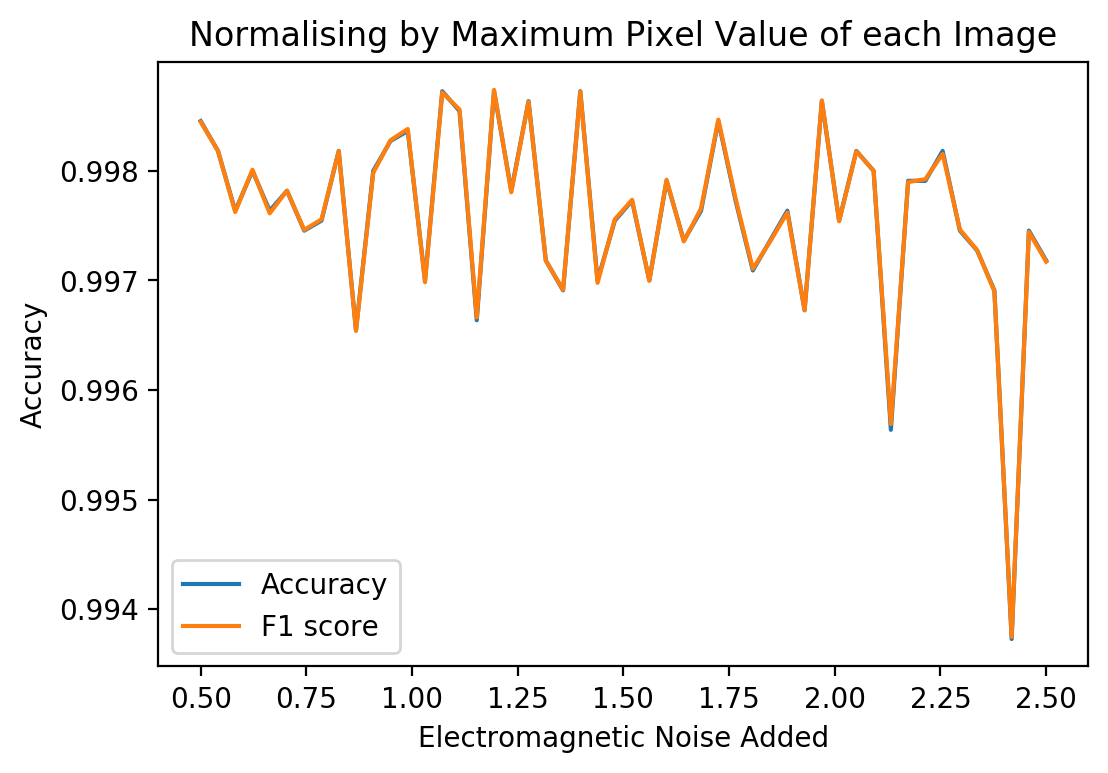

In [672]:
plt.title('Normalising by Maximum Pixel Value of each Image')
plt.plot(noises4,ntb2acc, label = 'Accuracy')
plt.plot(noises4,ntb2f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise Added')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [241]:
#test 3 with 10 values of noise over the range 0-0.75
ntb3acc, ntb3f1 = elnoisetoboth(images,noises3,0.1,0.1,'array') #normalising by maximum pixel values of all images

Epoch 1/40
32/32 [==============================] - 10s 314ms/step - loss: 1.2272 - accuracy: 0.4958 - val_loss: 0.6942 - val_accuracy: 0.4910
Epoch 2/40
32/32 [==============================] - 10s 320ms/step - loss: 0.8084 - accuracy: 0.5019 - val_loss: 0.6938 - val_accuracy: 0.4900
Epoch 3/40
32/32 [==============================] - 10s 318ms/step - loss: 0.7590 - accuracy: 0.4952 - val_loss: 0.6936 - val_accuracy: 0.4920
Epoch 4/40
32/32 [==============================] - 11s 329ms/step - loss: 0.7321 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5100
Epoch 5/40
32/32 [==============================] - 10s 328ms/step - loss: 0.7210 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5110
Epoch 6/40
32/32 [==============================] - 9s 289ms/step - loss: 0.7125 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/40
32/32 [==============================] - 10s 303ms/step - loss: 0.7043 - accuracy: 0.5055 - val_loss: 0.6931 - val_accuracy: 0.5080


Epoch 32/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5594 - accuracy: 0.7064 - val_loss: 0.5872 - val_accuracy: 0.6910
Epoch 33/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5576 - accuracy: 0.7135 - val_loss: 0.5872 - val_accuracy: 0.6910
Epoch 34/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5553 - accuracy: 0.7130 - val_loss: 0.5868 - val_accuracy: 0.6930
Epoch 35/40
32/32 [==============================] - 9s 293ms/step - loss: 0.5492 - accuracy: 0.7166 - val_loss: 0.5963 - val_accuracy: 0.6640
Epoch 36/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5472 - accuracy: 0.7151 - val_loss: 0.5818 - val_accuracy: 0.6910
Epoch 37/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5455 - accuracy: 0.7230 - val_loss: 0.5880 - val_accuracy: 0.6820
Epoch 38/40
32/32 [==============================] - 10s 298ms/step - loss: 0.5425 - accuracy: 0.7247 - val_loss: 0.5889 - val_accuracy: 0.687

32/32 [==============================] - 10s 307ms/step - loss: 0.6921 - accuracy: 0.5325 - val_loss: 0.6924 - val_accuracy: 0.5480
Epoch 10/40
32/32 [==============================] - 10s 324ms/step - loss: 0.6896 - accuracy: 0.5340 - val_loss: 0.6921 - val_accuracy: 0.5400
Epoch 11/40
32/32 [==============================] - 10s 313ms/step - loss: 0.6879 - accuracy: 0.5414 - val_loss: 0.6912 - val_accuracy: 0.5580
Epoch 12/40
32/32 [==============================] - 10s 304ms/step - loss: 0.6842 - accuracy: 0.5515 - val_loss: 0.6896 - val_accuracy: 0.5670
Epoch 13/40
32/32 [==============================] - 10s 306ms/step - loss: 0.6833 - accuracy: 0.5570 - val_loss: 0.6870 - val_accuracy: 0.5880
Epoch 14/40
32/32 [==============================] - 10s 315ms/step - loss: 0.6800 - accuracy: 0.5612 - val_loss: 0.6832 - val_accuracy: 0.6020
Epoch 15/40
32/32 [==============================] - 10s 315ms/step - loss: 0.6644 - accuracy: 0.5953 - val_loss: 0.6711 - val_accuracy: 0.6450
Epoc

32/32 [==============================] - 10s 315ms/step - loss: 0.5889 - accuracy: 0.6786 - val_loss: 0.5989 - val_accuracy: 0.6970
Epoch 27/40
32/32 [==============================] - 10s 310ms/step - loss: 0.5926 - accuracy: 0.6833 - val_loss: 0.5957 - val_accuracy: 0.6990
Epoch 28/40
32/32 [==============================] - 10s 320ms/step - loss: 0.5829 - accuracy: 0.6920 - val_loss: 0.5949 - val_accuracy: 0.7040
Epoch 29/40
32/32 [==============================] - 10s 328ms/step - loss: 0.5824 - accuracy: 0.6957 - val_loss: 0.5899 - val_accuracy: 0.7000
Epoch 30/40
32/32 [==============================] - 11s 334ms/step - loss: 0.5791 - accuracy: 0.6969 - val_loss: 0.5899 - val_accuracy: 0.6950
Epoch 31/40
32/32 [==============================] - 10s 328ms/step - loss: 0.5740 - accuracy: 0.6986 - val_loss: 0.5888 - val_accuracy: 0.6940
Epoch 32/40
32/32 [==============================] - 10s 322ms/step - loss: 0.5719 - accuracy: 0.7031 - val_loss: 0.5852 - val_accuracy: 0.6930
Epoc

32/32 [==============================] - 11s 329ms/step - loss: 0.7483 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4680
Epoch 4/40
32/32 [==============================] - 11s 337ms/step - loss: 0.7157 - accuracy: 0.5114 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 5/40
32/32 [==============================] - 10s 324ms/step - loss: 0.7095 - accuracy: 0.5080 - val_loss: 0.6933 - val_accuracy: 0.4620
Epoch 6/40
32/32 [==============================] - 10s 328ms/step - loss: 0.7009 - accuracy: 0.5113 - val_loss: 0.6931 - val_accuracy: 0.5340
Epoch 7/40
32/32 [==============================] - 11s 330ms/step - loss: 0.6980 - accuracy: 0.5148 - val_loss: 0.6932 - val_accuracy: 0.4730
Epoch 8/40
32/32 [==============================] - 10s 328ms/step - loss: 0.6980 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4630
Epoch 9/40
32/32 [==============================] - 11s 329ms/step - loss: 0.6949 - accuracy: 0.5176 - val_loss: 0.6935 - val_accuracy: 0.4590
Epoch 10/4

Epoch 2/40
32/32 [==============================] - 9s 288ms/step - loss: 0.7189 - accuracy: 0.5052 - val_loss: 0.6930 - val_accuracy: 0.5240
Epoch 3/40
32/32 [==============================] - 9s 290ms/step - loss: 0.7008 - accuracy: 0.5141 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 4/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6986 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.4770
Epoch 5/40
32/32 [==============================] - 10s 297ms/step - loss: 0.6923 - accuracy: 0.5236 - val_loss: 0.6932 - val_accuracy: 0.4760
Epoch 6/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6932 - accuracy: 0.5182 - val_loss: 0.6933 - val_accuracy: 0.4780
Epoch 7/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6926 - accuracy: 0.5236 - val_loss: 0.6934 - val_accuracy: 0.4780
Epoch 8/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6912 - accuracy: 0.5259 - val_loss: 0.6937 - val_accuracy: 0.4780
Epoch

32/32 [==============================] - 9s 289ms/step - loss: 0.6937 - accuracy: 0.5128 - val_loss: 0.6929 - val_accuracy: 0.5070
Epoch 20/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6917 - accuracy: 0.5244 - val_loss: 0.6928 - val_accuracy: 0.5090
Epoch 21/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6917 - accuracy: 0.5230 - val_loss: 0.6927 - val_accuracy: 0.5160
Epoch 22/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6906 - accuracy: 0.5204 - val_loss: 0.6926 - val_accuracy: 0.5100
Epoch 23/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6907 - accuracy: 0.5268 - val_loss: 0.6924 - val_accuracy: 0.5180
Epoch 24/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6906 - accuracy: 0.5319 - val_loss: 0.6922 - val_accuracy: 0.5190
Epoch 25/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6886 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.5230
Epoch 26/40

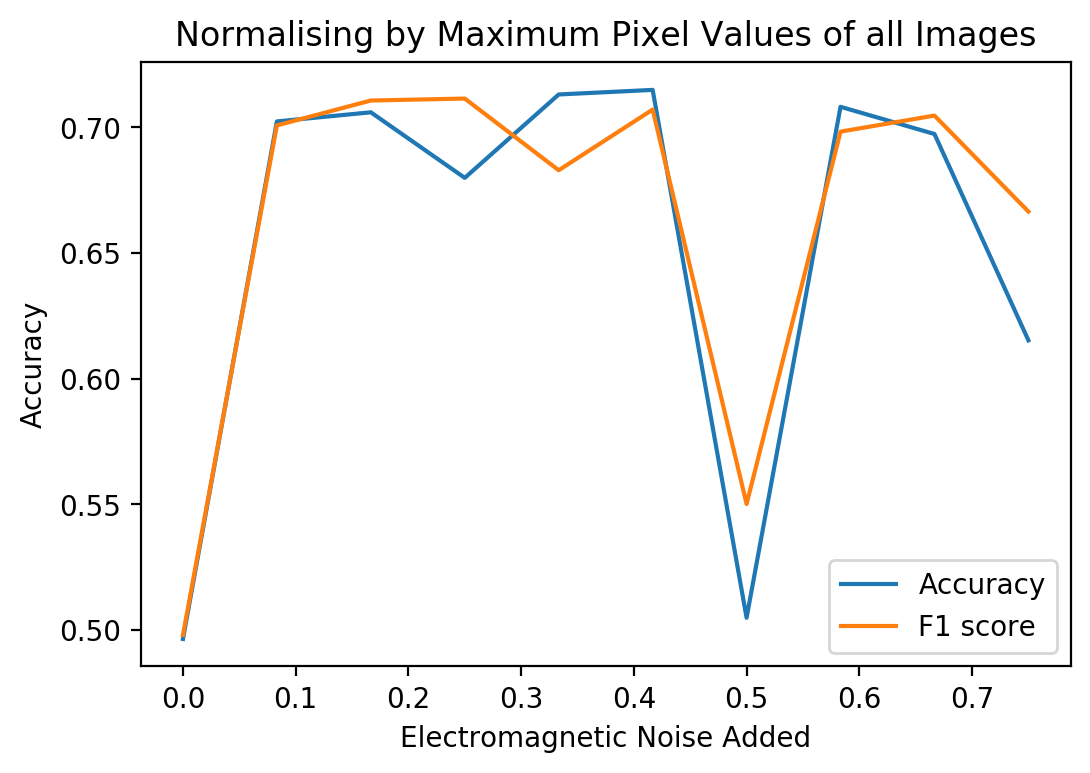

In [673]:
plt.title('Normalising by Maximum Pixel Values of all Images')
plt.plot(noises3,ntb3acc, label = 'Accuracy')
plt.plot(noises3,ntb3f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise Added')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [204]:
#4th test with 50 values of noise in range 0.5-2.5 
ntb4acc,ntb4f1 = elnoisetoboth(images,noises4,0.1,0.1,'array') #normalising by maximum pixel values of all images

Epoch 1/40
32/32 [==============================] - 10s 316ms/step - loss: 0.7848 - accuracy: 0.4970 - val_loss: 0.6933 - val_accuracy: 0.4890
Epoch 2/40
32/32 [==============================] - 10s 314ms/step - loss: 0.7133 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 3/40
32/32 [==============================] - 10s 310ms/step - loss: 0.6982 - accuracy: 0.5221 - val_loss: 0.6931 - val_accuracy: 0.5130
Epoch 4/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6984 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.4910
Epoch 5/40
32/32 [==============================] - 12s 375ms/step - loss: 0.6956 - accuracy: 0.5106 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 6/40
32/32 [==============================] - 10s 319ms/step - loss: 0.6917 - accuracy: 0.5270 - val_loss: 0.6933 - val_accuracy: 0.4860
Epoch 7/40
32/32 [==============================] - 10s 298ms/step - loss: 0.6918 - accuracy: 0.5224 - val_loss: 0.6933 - val_accuracy: 0.4880


32/32 [==============================] - 9s 290ms/step - loss: 0.6110 - accuracy: 0.6662 - val_loss: 0.6138 - val_accuracy: 0.6830
Epoch 19/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6061 - accuracy: 0.6660 - val_loss: 0.6152 - val_accuracy: 0.6890
Epoch 20/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6103 - accuracy: 0.6586 - val_loss: 0.6066 - val_accuracy: 0.6900
Epoch 21/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6032 - accuracy: 0.6691 - val_loss: 0.6055 - val_accuracy: 0.7010
Epoch 22/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6039 - accuracy: 0.6730 - val_loss: 0.5990 - val_accuracy: 0.7040
Epoch 23/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6017 - accuracy: 0.6702 - val_loss: 0.5963 - val_accuracy: 0.6920
Epoch 24/40
32/32 [==============================] - 10s 302ms/step - loss: 0.6005 - accuracy: 0.6824 - val_loss: 0.5935 - val_accuracy: 0.6920
Epoch 25/4

32/32 [==============================] - 9s 293ms/step - loss: 0.6713 - accuracy: 0.5821 - val_loss: 0.6765 - val_accuracy: 0.5720
Epoch 36/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6650 - accuracy: 0.5920 - val_loss: 0.6720 - val_accuracy: 0.5830
Epoch 37/40
32/32 [==============================] - 9s 297ms/step - loss: 0.6484 - accuracy: 0.6196 - val_loss: 0.6621 - val_accuracy: 0.6150
Epoch 38/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6439 - accuracy: 0.6215 - val_loss: 0.6506 - val_accuracy: 0.6410
Epoch 39/40
32/32 [==============================] - 9s 296ms/step - loss: 0.6330 - accuracy: 0.6345 - val_loss: 0.6405 - val_accuracy: 0.6200
Epoch 40/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6214 - accuracy: 0.6535 - val_loss: 0.6211 - val_accuracy: 0.6550
Epoch 1/40
32/32 [==============================] - 10s 302ms/step - loss: 0.8542 - accuracy: 0.5029 - val_loss: 0.6992 - val_accuracy: 0.4890
Epoch 2/40


32/32 [==============================] - 9s 287ms/step - loss: 0.6926 - accuracy: 0.5171 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 13/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6933 - accuracy: 0.5148 - val_loss: 0.6932 - val_accuracy: 0.4880
Epoch 14/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6925 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 15/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6919 - accuracy: 0.5236 - val_loss: 0.6931 - val_accuracy: 0.5190
Epoch 16/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6919 - accuracy: 0.5238 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 17/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6931 - val_accuracy: 0.5260
Epoch 18/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6923 - accuracy: 0.5163 - val_loss: 0.6930 - val_accuracy: 0.5210
Epoch 19/40

32/32 [==============================] - 9s 291ms/step - loss: 0.5862 - accuracy: 0.6826 - val_loss: 0.5795 - val_accuracy: 0.7090
Epoch 30/40
32/32 [==============================] - 9s 293ms/step - loss: 0.5825 - accuracy: 0.6891 - val_loss: 0.5742 - val_accuracy: 0.7170
Epoch 31/40
32/32 [==============================] - 9s 294ms/step - loss: 0.5743 - accuracy: 0.6979 - val_loss: 0.5691 - val_accuracy: 0.7100
Epoch 32/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5702 - accuracy: 0.6975 - val_loss: 0.5676 - val_accuracy: 0.7180
Epoch 33/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5681 - accuracy: 0.7014 - val_loss: 0.5635 - val_accuracy: 0.7180
Epoch 34/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5659 - accuracy: 0.7023 - val_loss: 0.5629 - val_accuracy: 0.7140
Epoch 35/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5643 - accuracy: 0.7032 - val_loss: 0.5613 - val_accuracy: 0.7120
Epoch 36/40

32/32 [==============================] - 9s 288ms/step - loss: 0.7170 - accuracy: 0.4979 - val_loss: 0.6929 - val_accuracy: 0.5030
Epoch 7/40
32/32 [==============================] - 9s 288ms/step - loss: 0.7058 - accuracy: 0.5115 - val_loss: 0.6928 - val_accuracy: 0.5140
Epoch 8/40
32/32 [==============================] - 9s 287ms/step - loss: 0.7013 - accuracy: 0.5194 - val_loss: 0.6928 - val_accuracy: 0.5080
Epoch 9/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6997 - accuracy: 0.5099 - val_loss: 0.6929 - val_accuracy: 0.5130
Epoch 10/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6977 - accuracy: 0.5145 - val_loss: 0.6930 - val_accuracy: 0.5080
Epoch 11/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6973 - accuracy: 0.5094 - val_loss: 0.6930 - val_accuracy: 0.4980
Epoch 12/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6941 - accuracy: 0.5211 - val_loss: 0.6929 - val_accuracy: 0.4920
Epoch 13/40
32

32/32 [==============================] - 9s 285ms/step - loss: 0.6959 - accuracy: 0.5153 - val_loss: 0.6929 - val_accuracy: 0.5230
Epoch 7/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6938 - accuracy: 0.5259 - val_loss: 0.6928 - val_accuracy: 0.5390
Epoch 8/40
32/32 [==============================] - 9s 284ms/step - loss: 0.6950 - accuracy: 0.5106 - val_loss: 0.6927 - val_accuracy: 0.5350
Epoch 9/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6933 - accuracy: 0.5151 - val_loss: 0.6925 - val_accuracy: 0.5420
Epoch 10/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6929 - accuracy: 0.5169 - val_loss: 0.6925 - val_accuracy: 0.5450
Epoch 11/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6925 - accuracy: 0.5116 - val_loss: 0.6923 - val_accuracy: 0.5410
Epoch 12/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6916 - accuracy: 0.5276 - val_loss: 0.6921 - val_accuracy: 0.5440
Epoch 13/40
32

32/32 [==============================] - 9s 287ms/step - loss: 0.6498 - accuracy: 0.6199 - val_loss: 0.6369 - val_accuracy: 0.6430
Epoch 24/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6352 - accuracy: 0.6341 - val_loss: 0.6237 - val_accuracy: 0.6670
Epoch 25/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6257 - accuracy: 0.6488 - val_loss: 0.6151 - val_accuracy: 0.6750
Epoch 26/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6226 - accuracy: 0.6471 - val_loss: 0.6073 - val_accuracy: 0.6760
Epoch 27/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6095 - accuracy: 0.6635 - val_loss: 0.6015 - val_accuracy: 0.6770
Epoch 28/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6014 - accuracy: 0.6773 - val_loss: 0.5956 - val_accuracy: 0.6820
Epoch 29/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5999 - accuracy: 0.6779 - val_loss: 0.5926 - val_accuracy: 0.6930
Epoch 30/40

32/32 [==============================] - 15s 474ms/step - loss: 0.8111 - accuracy: 0.4889 - val_loss: 0.6930 - val_accuracy: 0.4980
Epoch 3/40
32/32 [==============================] - 9s 274ms/step - loss: 0.7495 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.4790
Epoch 4/40
32/32 [==============================] - 9s 287ms/step - loss: 0.7238 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5150
Epoch 5/40
32/32 [==============================] - 9s 286ms/step - loss: 0.7091 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 6/40
32/32 [==============================] - 9s 290ms/step - loss: 0.7001 - accuracy: 0.5145 - val_loss: 0.6931 - val_accuracy: 0.5090
Epoch 7/40
32/32 [==============================] - 9s 289ms/step - loss: 0.7035 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.4930
Epoch 8/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6967 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5160
Epoch 9/40
32/32

32/32 [==============================] - 9s 296ms/step - loss: 1.1577 - accuracy: 0.5011 - val_loss: 0.6949 - val_accuracy: 0.4990
Epoch 2/40
32/32 [==============================] - 9s 290ms/step - loss: 0.8022 - accuracy: 0.4945 - val_loss: 0.6938 - val_accuracy: 0.4990
Epoch 3/40
32/32 [==============================] - 9s 291ms/step - loss: 0.7449 - accuracy: 0.5131 - val_loss: 0.6936 - val_accuracy: 0.4990
Epoch 4/40
32/32 [==============================] - 9s 290ms/step - loss: 0.7322 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/40
32/32 [==============================] - 9s 290ms/step - loss: 0.7185 - accuracy: 0.5020 - val_loss: 0.6927 - val_accuracy: 0.5040
Epoch 6/40
32/32 [==============================] - 9s 288ms/step - loss: 0.7051 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5130
Epoch 7/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6998 - accuracy: 0.5116 - val_loss: 0.6928 - val_accuracy: 0.5290
Epoch 8/40
32/32 

32/32 [==============================] - 9s 291ms/step - loss: 0.6773 - accuracy: 0.5664 - val_loss: 0.6842 - val_accuracy: 0.5840
Epoch 19/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6674 - accuracy: 0.5860 - val_loss: 0.6758 - val_accuracy: 0.5930
Epoch 20/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6594 - accuracy: 0.6114 - val_loss: 0.6623 - val_accuracy: 0.6340
Epoch 21/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6491 - accuracy: 0.6120 - val_loss: 0.6493 - val_accuracy: 0.6320
Epoch 22/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6440 - accuracy: 0.6209 - val_loss: 0.6409 - val_accuracy: 0.6460
Epoch 23/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6279 - accuracy: 0.6416 - val_loss: 0.6239 - val_accuracy: 0.6810
Epoch 24/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6230 - accuracy: 0.6457 - val_loss: 0.6257 - val_accuracy: 0.6730
Epoch 25/40

32/32 [==============================] - 9s 290ms/step - loss: 0.5278 - accuracy: 0.7412 - val_loss: 0.5562 - val_accuracy: 0.7090
Epoch 36/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5288 - accuracy: 0.7360 - val_loss: 0.5528 - val_accuracy: 0.7130
Epoch 37/40
32/32 [==============================] - 9s 286ms/step - loss: 0.5242 - accuracy: 0.7365 - val_loss: 0.5464 - val_accuracy: 0.7290
Epoch 38/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5234 - accuracy: 0.7386 - val_loss: 0.5523 - val_accuracy: 0.7160
Epoch 39/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5240 - accuracy: 0.7401 - val_loss: 0.5440 - val_accuracy: 0.7330
Epoch 40/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5172 - accuracy: 0.7448 - val_loss: 0.5507 - val_accuracy: 0.7180
Epoch 1/40
32/32 [==============================] - 9s 294ms/step - loss: 0.9280 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5310
Epoch 2/40
3

32/32 [==============================] - 9s 292ms/step - loss: 0.6914 - accuracy: 0.5296 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 13/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6925 - accuracy: 0.5174 - val_loss: 0.6926 - val_accuracy: 0.5330
Epoch 14/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6920 - accuracy: 0.5264 - val_loss: 0.6926 - val_accuracy: 0.5140
Epoch 15/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6903 - accuracy: 0.5305 - val_loss: 0.6920 - val_accuracy: 0.5370
Epoch 16/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6880 - accuracy: 0.5414 - val_loss: 0.6910 - val_accuracy: 0.5430
Epoch 17/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6835 - accuracy: 0.5625 - val_loss: 0.6855 - val_accuracy: 0.5820
Epoch 18/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6800 - accuracy: 0.5658 - val_loss: 0.6765 - val_accuracy: 0.6190
Epoch 19/40

/Users/leo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/40
32/32 [==============================] - 9s 284ms/step - loss: 0.9076 - accuracy: 0.5092 - val_loss: 0.6921 - val_accuracy: 0.5200
Epoch 2/40
32/32 [==============================] - 9s 288ms/step - loss: 0.7381 - accuracy: 0.5091 - val_loss: 0.6984 - val_accuracy: 0.4800
Epoch 3/40
32/32 [==============================] - 9s 287ms/step - loss: 0.7155 - accuracy: 0.5115 - val_loss: 0.6938 - val_accuracy: 0.4800
Epoch 4/40
32/32 [==============================] - 9s 289ms/step - loss: 0.7027 - accuracy: 0.5136 - val_loss: 0.6937 - val_accuracy: 0.4800
Epoch 5/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6971 - accuracy: 0.5284 - val_loss: 0.6935 - val_accuracy: 0.4830
Epoch 6/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6966 - accuracy: 0.5189 - val_loss: 0.6922 - val_accuracy: 0.5330
Epoch 7/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6962 - accuracy: 0.5044 - val_loss: 0.6918 - val_accuracy: 0.5230
Epoch 

32/32 [==============================] - 9s 287ms/step - loss: 0.6920 - accuracy: 0.5229 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 19/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6917 - accuracy: 0.5236 - val_loss: 0.6933 - val_accuracy: 0.4890
Epoch 20/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6924 - accuracy: 0.5149 - val_loss: 0.6933 - val_accuracy: 0.4910
Epoch 21/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6901 - accuracy: 0.5349 - val_loss: 0.6932 - val_accuracy: 0.4920
Epoch 00021: early stopping
Epoch 1/40
32/32 [==============================] - 9s 285ms/step - loss: 0.7093 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 2/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6948 - accuracy: 0.5151 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 3/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6925 - accuracy: 0.5145 - val_loss: 0.6931 - val_acc

32/32 [==============================] - 9s 285ms/step - loss: 0.6150 - accuracy: 0.6550 - val_loss: 0.6199 - val_accuracy: 0.6520
Epoch 14/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6090 - accuracy: 0.6605 - val_loss: 0.6119 - val_accuracy: 0.6610
Epoch 15/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6034 - accuracy: 0.6678 - val_loss: 0.6058 - val_accuracy: 0.6760
Epoch 16/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5946 - accuracy: 0.6810 - val_loss: 0.6041 - val_accuracy: 0.6760
Epoch 17/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5908 - accuracy: 0.6881 - val_loss: 0.5966 - val_accuracy: 0.6820
Epoch 18/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5929 - accuracy: 0.6800 - val_loss: 0.5984 - val_accuracy: 0.6840
Epoch 19/40
32/32 [==============================] - 9s 286ms/step - loss: 0.5831 - accuracy: 0.6901 - val_loss: 0.5940 - val_accuracy: 0.6860
Epoch 20/40

32/32 [==============================] - 9s 286ms/step - loss: 0.5775 - accuracy: 0.6949 - val_loss: 0.5853 - val_accuracy: 0.6840
Epoch 31/40
32/32 [==============================] - 9s 286ms/step - loss: 0.5751 - accuracy: 0.6951 - val_loss: 0.5858 - val_accuracy: 0.6850
Epoch 32/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5818 - accuracy: 0.6948 - val_loss: 0.5856 - val_accuracy: 0.6890
Epoch 33/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5725 - accuracy: 0.7005 - val_loss: 0.5758 - val_accuracy: 0.7160
Epoch 34/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5740 - accuracy: 0.7007 - val_loss: 0.5785 - val_accuracy: 0.7110
Epoch 35/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5745 - accuracy: 0.7028 - val_loss: 0.5773 - val_accuracy: 0.7060
Epoch 36/40
32/32 [==============================] - 9s 286ms/step - loss: 0.5664 - accuracy: 0.7081 - val_loss: 0.5773 - val_accuracy: 0.7000
Epoch 37/40

32/32 [==============================] - 9s 296ms/step - loss: 0.6957 - accuracy: 0.5052 - val_loss: 0.6930 - val_accuracy: 0.5360
Epoch 8/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6962 - accuracy: 0.5029 - val_loss: 0.6929 - val_accuracy: 0.5350
Epoch 9/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6955 - accuracy: 0.5081 - val_loss: 0.6928 - val_accuracy: 0.5290
Epoch 10/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6942 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5460
Epoch 11/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6936 - accuracy: 0.5106 - val_loss: 0.6930 - val_accuracy: 0.5440
Epoch 12/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6926 - accuracy: 0.5214 - val_loss: 0.6928 - val_accuracy: 0.5270
Epoch 13/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6941 - accuracy: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.5350
Epoch 14/40
3

32/32 [==============================] - 9s 294ms/step - loss: 0.5671 - accuracy: 0.7074 - val_loss: 0.5849 - val_accuracy: 0.7090
Epoch 25/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5633 - accuracy: 0.7046 - val_loss: 0.5852 - val_accuracy: 0.7150
Epoch 26/40
32/32 [==============================] - 9s 287ms/step - loss: 0.5649 - accuracy: 0.7086 - val_loss: 0.5784 - val_accuracy: 0.7230
Epoch 27/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5612 - accuracy: 0.7078 - val_loss: 0.5776 - val_accuracy: 0.7180
Epoch 28/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5611 - accuracy: 0.7125 - val_loss: 0.5783 - val_accuracy: 0.7190
Epoch 29/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5618 - accuracy: 0.7125 - val_loss: 0.5845 - val_accuracy: 0.7110
Epoch 30/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5565 - accuracy: 0.7120 - val_loss: 0.5807 - val_accuracy: 0.7130
Epoch 31/40

32/32 [==============================] - 9s 292ms/step - loss: 0.8694 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 2/40
32/32 [==============================] - 9s 280ms/step - loss: 0.7306 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5340
Epoch 3/40
32/32 [==============================] - 9s 285ms/step - loss: 0.7073 - accuracy: 0.5096 - val_loss: 0.6932 - val_accuracy: 0.4800
Epoch 4/40
32/32 [==============================] - 9s 283ms/step - loss: 0.7012 - accuracy: 0.5091 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 5/40
32/32 [==============================] - 9s 284ms/step - loss: 0.6998 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.5270
Epoch 6/40
32/32 [==============================] - 9s 285ms/step - loss: 0.6957 - accuracy: 0.5154 - val_loss: 0.6931 - val_accuracy: 0.5310
Epoch 7/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6978 - accuracy: 0.4992 - val_loss: 0.6930 - val_accuracy: 0.5220
Epoch 8/40
32/32 

32/32 [==============================] - 9s 291ms/step - loss: 0.6916 - accuracy: 0.5226 - val_loss: 0.6928 - val_accuracy: 0.4910
Epoch 19/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6905 - accuracy: 0.5303 - val_loss: 0.6923 - val_accuracy: 0.5190
Epoch 20/40
32/32 [==============================] - 9s 296ms/step - loss: 0.6926 - accuracy: 0.5250 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 21/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6920 - accuracy: 0.5204 - val_loss: 0.6927 - val_accuracy: 0.5010
Epoch 22/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6896 - accuracy: 0.5351 - val_loss: 0.6929 - val_accuracy: 0.4980
Epoch 23/40
32/32 [==============================] - 9s 296ms/step - loss: 0.6871 - accuracy: 0.5493 - val_loss: 0.6914 - val_accuracy: 0.5110
Epoch 24/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6893 - accuracy: 0.5334 - val_loss: 0.6911 - val_accuracy: 0.5350
Epoch 25/40

32/32 [==============================] - 9s 289ms/step - loss: 0.5454 - accuracy: 0.7199 - val_loss: 0.5592 - val_accuracy: 0.7240
Epoch 36/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5420 - accuracy: 0.7291 - val_loss: 0.5662 - val_accuracy: 0.7190
Epoch 37/40
32/32 [==============================] - 9s 294ms/step - loss: 0.5399 - accuracy: 0.7265 - val_loss: 0.5767 - val_accuracy: 0.7070
Epoch 38/40
32/32 [==============================] - 9s 287ms/step - loss: 0.5411 - accuracy: 0.7264 - val_loss: 0.5557 - val_accuracy: 0.7290
Epoch 39/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5382 - accuracy: 0.7324 - val_loss: 0.5603 - val_accuracy: 0.7250
Epoch 40/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5403 - accuracy: 0.7291 - val_loss: 0.5665 - val_accuracy: 0.7140
Epoch 1/40
32/32 [==============================] - 15s 470ms/step - loss: 1.0997 - accuracy: 0.4989 - val_loss: 0.7017 - val_accuracy: 0.4980
Epoch 2/40


32/32 [==============================] - 9s 290ms/step - loss: 0.6237 - accuracy: 0.6520 - val_loss: 0.6179 - val_accuracy: 0.6870
Epoch 13/40
32/32 [==============================] - 9s 294ms/step - loss: 0.6108 - accuracy: 0.6624 - val_loss: 0.5987 - val_accuracy: 0.6960
Epoch 14/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6061 - accuracy: 0.6718 - val_loss: 0.6153 - val_accuracy: 0.6350
Epoch 15/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5878 - accuracy: 0.6910 - val_loss: 0.5930 - val_accuracy: 0.6860
Epoch 16/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5794 - accuracy: 0.6961 - val_loss: 0.5852 - val_accuracy: 0.6800
Epoch 17/40
32/32 [==============================] - 9s 293ms/step - loss: 0.5792 - accuracy: 0.6975 - val_loss: 0.5862 - val_accuracy: 0.6800
Epoch 18/40
32/32 [==============================] - 9s 294ms/step - loss: 0.5830 - accuracy: 0.6946 - val_loss: 0.5819 - val_accuracy: 0.6910
Epoch 19/40

32/32 [==============================] - 9s 293ms/step - loss: 0.6335 - accuracy: 0.6341 - val_loss: 0.6378 - val_accuracy: 0.6550
Epoch 30/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6163 - accuracy: 0.6566 - val_loss: 0.6196 - val_accuracy: 0.6680
Epoch 31/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6101 - accuracy: 0.6625 - val_loss: 0.6128 - val_accuracy: 0.6830
Epoch 32/40
32/32 [==============================] - 9s 287ms/step - loss: 0.5995 - accuracy: 0.6747 - val_loss: 0.6069 - val_accuracy: 0.6830
Epoch 33/40
32/32 [==============================] - 9s 292ms/step - loss: 0.5956 - accuracy: 0.6740 - val_loss: 0.6056 - val_accuracy: 0.6770
Epoch 34/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5887 - accuracy: 0.6845 - val_loss: 0.5983 - val_accuracy: 0.6870
Epoch 35/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5847 - accuracy: 0.6876 - val_loss: 0.5980 - val_accuracy: 0.6830
Epoch 36/40

32/32 [==============================] - 9s 291ms/step - loss: 0.6800 - accuracy: 0.5636 - val_loss: 0.6892 - val_accuracy: 0.5180
Epoch 7/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6746 - accuracy: 0.5784 - val_loss: 0.6879 - val_accuracy: 0.5080
Epoch 8/40
32/32 [==============================] - 9s 294ms/step - loss: 0.6631 - accuracy: 0.5985 - val_loss: 0.6778 - val_accuracy: 0.6230
Epoch 9/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6458 - accuracy: 0.6305 - val_loss: 0.6693 - val_accuracy: 0.5610
Epoch 10/40
32/32 [==============================] - 10s 309ms/step - loss: 0.6321 - accuracy: 0.6349 - val_loss: 0.6511 - val_accuracy: 0.6210
Epoch 11/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6140 - accuracy: 0.6653 - val_loss: 0.6274 - val_accuracy: 0.6730
Epoch 12/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6016 - accuracy: 0.6700 - val_loss: 0.6089 - val_accuracy: 0.6790
Epoch 13/40
3

32/32 [==============================] - 9s 291ms/step - loss: 0.6654 - accuracy: 0.5928 - val_loss: 0.6615 - val_accuracy: 0.6460
Epoch 24/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6637 - accuracy: 0.5945 - val_loss: 0.6532 - val_accuracy: 0.6430
Epoch 25/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6501 - accuracy: 0.6129 - val_loss: 0.6401 - val_accuracy: 0.6710
Epoch 26/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6356 - accuracy: 0.6376 - val_loss: 0.6235 - val_accuracy: 0.6780
Epoch 27/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6289 - accuracy: 0.6410 - val_loss: 0.6139 - val_accuracy: 0.6820
Epoch 28/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6251 - accuracy: 0.6520 - val_loss: 0.6059 - val_accuracy: 0.6890
Epoch 29/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6111 - accuracy: 0.6618 - val_loss: 0.5981 - val_accuracy: 0.7040
Epoch 30/40

32/32 [==============================] - 9s 290ms/step - loss: 0.5835 - accuracy: 0.6871 - val_loss: 0.6030 - val_accuracy: 0.6650
Epoch 1/40
32/32 [==============================] - 9s 293ms/step - loss: 0.7765 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5130
Epoch 2/40
32/32 [==============================] - 9s 281ms/step - loss: 0.7110 - accuracy: 0.5082 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 3/40
32/32 [==============================] - 9s 286ms/step - loss: 0.7010 - accuracy: 0.5070 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 4/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6961 - accuracy: 0.5092 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 5/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6932 - accuracy: 0.5145 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 6/40
32/32 [==============================] - 9s 284ms/step - loss: 0.6925 - accuracy: 0.5174 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 7/40
32/32 

32/32 [==============================] - 9s 288ms/step - loss: 0.6932 - accuracy: 0.5111 - val_loss: 0.6928 - val_accuracy: 0.5450
Epoch 18/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6932 - accuracy: 0.5082 - val_loss: 0.6927 - val_accuracy: 0.5460
Epoch 19/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6921 - accuracy: 0.5166 - val_loss: 0.6931 - val_accuracy: 0.4860
Epoch 20/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6922 - accuracy: 0.5160 - val_loss: 0.6929 - val_accuracy: 0.5270
Epoch 21/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6928 - accuracy: 0.5141 - val_loss: 0.6930 - val_accuracy: 0.5240
Epoch 22/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6934 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 23/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6926 - accuracy: 0.5145 - val_loss: 0.6926 - val_accuracy: 0.5490
Epoch 24/40

32/32 [==============================] - 9s 287ms/step - loss: 0.5692 - accuracy: 0.7042 - val_loss: 0.5758 - val_accuracy: 0.6930
Epoch 35/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5630 - accuracy: 0.7081 - val_loss: 0.5689 - val_accuracy: 0.7050
Epoch 36/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5536 - accuracy: 0.7200 - val_loss: 0.5673 - val_accuracy: 0.7170
Epoch 37/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5623 - accuracy: 0.7106 - val_loss: 0.5700 - val_accuracy: 0.7070
Epoch 38/40
32/32 [==============================] - 9s 285ms/step - loss: 0.5514 - accuracy: 0.7219 - val_loss: 0.5654 - val_accuracy: 0.7160
Epoch 39/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5485 - accuracy: 0.7193 - val_loss: 0.5618 - val_accuracy: 0.7120
Epoch 40/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5516 - accuracy: 0.7206 - val_loss: 0.5650 - val_accuracy: 0.7040
Epoch 1/40


32/32 [==============================] - 9s 292ms/step - loss: 0.6779 - accuracy: 0.5605 - val_loss: 0.6836 - val_accuracy: 0.5520
Epoch 12/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6719 - accuracy: 0.5805 - val_loss: 0.6759 - val_accuracy: 0.5940
Epoch 13/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6571 - accuracy: 0.6021 - val_loss: 0.6591 - val_accuracy: 0.6280
Epoch 14/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6424 - accuracy: 0.6273 - val_loss: 0.6396 - val_accuracy: 0.6420
Epoch 15/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6261 - accuracy: 0.6507 - val_loss: 0.6182 - val_accuracy: 0.6840
Epoch 16/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6069 - accuracy: 0.6644 - val_loss: 0.5960 - val_accuracy: 0.7090
Epoch 17/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5907 - accuracy: 0.6815 - val_loss: 0.5882 - val_accuracy: 0.7260
Epoch 18/40

32/32 [==============================] - 9s 287ms/step - loss: 0.6228 - accuracy: 0.6520 - val_loss: 0.6145 - val_accuracy: 0.6980
Epoch 29/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6114 - accuracy: 0.6706 - val_loss: 0.5934 - val_accuracy: 0.7090
Epoch 30/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6081 - accuracy: 0.6701 - val_loss: 0.5936 - val_accuracy: 0.7070
Epoch 31/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6001 - accuracy: 0.6805 - val_loss: 0.5904 - val_accuracy: 0.7060
Epoch 32/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6004 - accuracy: 0.6760 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 33/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5980 - accuracy: 0.6787 - val_loss: 0.5893 - val_accuracy: 0.7150
Epoch 34/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5893 - accuracy: 0.6889 - val_loss: 0.5807 - val_accuracy: 0.7100
Epoch 35/40

32/32 [==============================] - 9s 281ms/step - loss: 0.6945 - accuracy: 0.5026 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 6/40
32/32 [==============================] - 9s 283ms/step - loss: 0.6938 - accuracy: 0.5138 - val_loss: 0.6929 - val_accuracy: 0.5060
Epoch 7/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6927 - val_accuracy: 0.5140
Epoch 8/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6918 - accuracy: 0.5169 - val_loss: 0.6930 - val_accuracy: 0.5070
Epoch 9/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6928 - accuracy: 0.5136 - val_loss: 0.6923 - val_accuracy: 0.5050
Epoch 10/40
32/32 [==============================] - 9s 289ms/step - loss: 0.6917 - accuracy: 0.5242 - val_loss: 0.6914 - val_accuracy: 0.5070
Epoch 11/40
32/32 [==============================] - 9s 294ms/step - loss: 0.6923 - accuracy: 0.5232 - val_loss: 0.6903 - val_accuracy: 0.5420
Epoch 12/40
32/

32/32 [==============================] - 9s 290ms/step - loss: 0.5878 - accuracy: 0.6856 - val_loss: 0.5951 - val_accuracy: 0.6790
Epoch 23/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5759 - accuracy: 0.7003 - val_loss: 0.5920 - val_accuracy: 0.6760
Epoch 24/40
32/32 [==============================] - 9s 293ms/step - loss: 0.5751 - accuracy: 0.7011 - val_loss: 0.5793 - val_accuracy: 0.6960
Epoch 25/40
32/32 [==============================] - 9s 294ms/step - loss: 0.5658 - accuracy: 0.7080 - val_loss: 0.5771 - val_accuracy: 0.6980
Epoch 26/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5639 - accuracy: 0.7109 - val_loss: 0.5762 - val_accuracy: 0.6960
Epoch 27/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5665 - accuracy: 0.7016 - val_loss: 0.5735 - val_accuracy: 0.6950
Epoch 28/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5727 - accuracy: 0.7000 - val_loss: 0.5782 - val_accuracy: 0.6900
Epoch 29/40

32/32 [==============================] - 9s 288ms/step - loss: 0.5769 - accuracy: 0.6988 - val_loss: 0.5796 - val_accuracy: 0.7030
Epoch 40/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5739 - accuracy: 0.6961 - val_loss: 0.5766 - val_accuracy: 0.7010
Epoch 1/40
32/32 [==============================] - 9s 288ms/step - loss: 0.8153 - accuracy: 0.5124 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 2/40
32/32 [==============================] - 9s 283ms/step - loss: 0.7181 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.4810
Epoch 3/40
32/32 [==============================] - 9s 286ms/step - loss: 0.7047 - accuracy: 0.5073 - val_loss: 0.6931 - val_accuracy: 0.5190
Epoch 4/40
32/32 [==============================] - 9s 282ms/step - loss: 0.6990 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 5/40
32/32 [==============================] - 9s 278ms/step - loss: 0.6966 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5190
Epoch 6/40
32/32

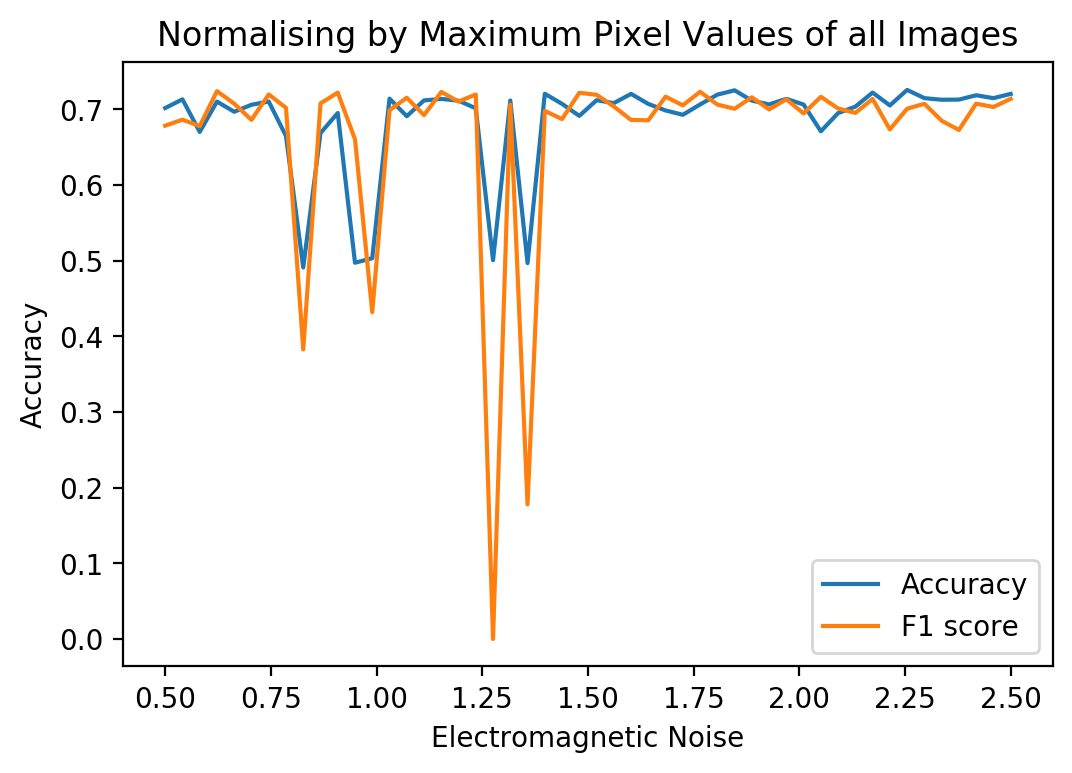

In [674]:
plt.title('Normalising by Maximum Pixel Values of all Images')
plt.plot(noises4,ntb4acc, label = 'Accuracy')
plt.plot(noises4,ntb4f1, label = 'F1 score')
plt.xlabel('Electromagnetic Noise')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

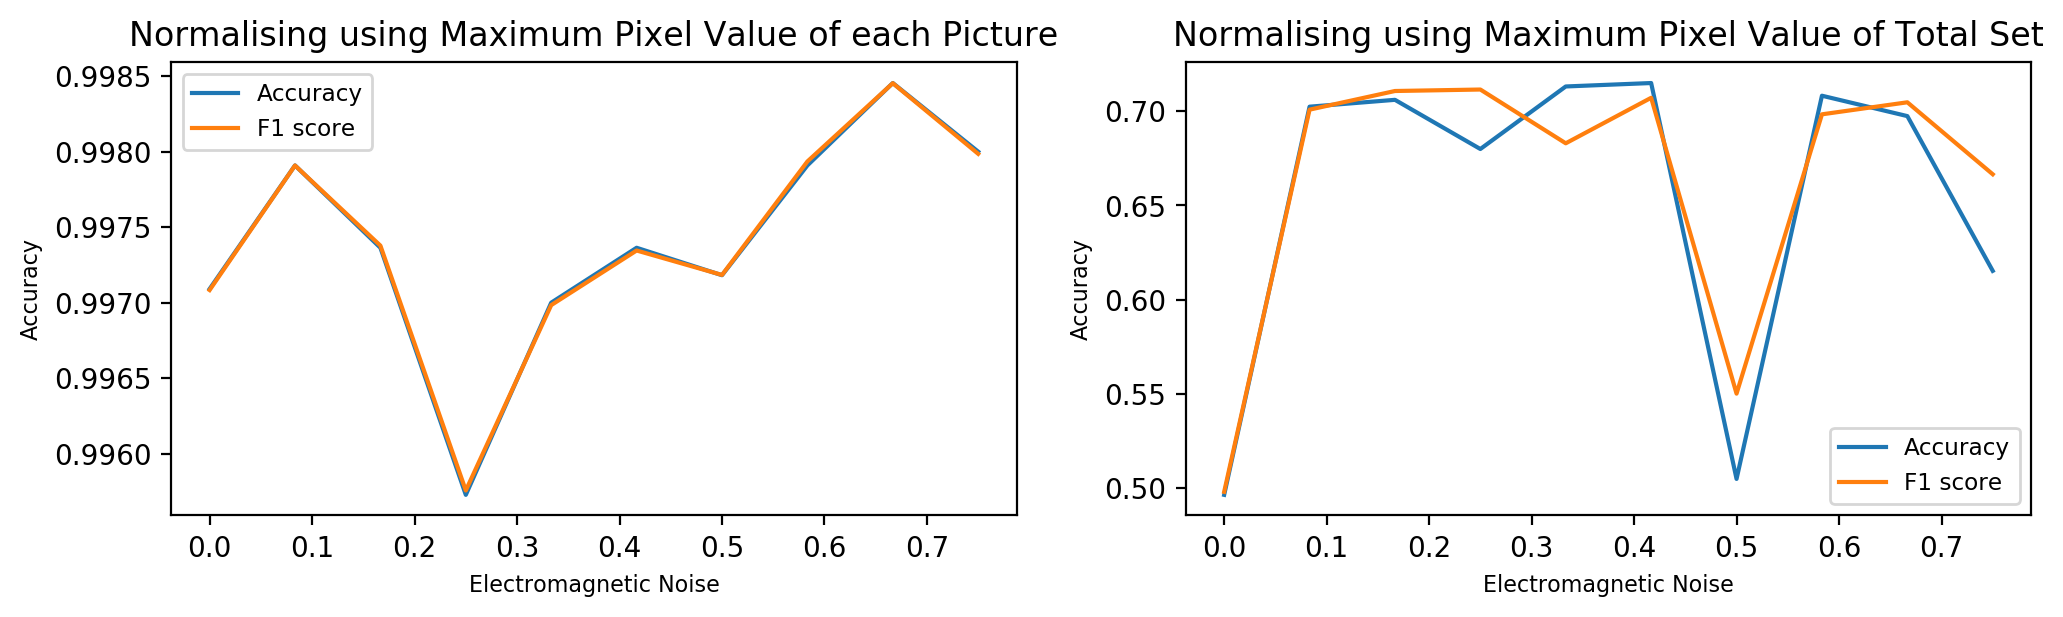

In [675]:
fig2 = plt.figure(figsize=(12,3))
ax1 = fig2.add_subplot(121)
ax1.plot(noises3,ntb1acc, label = 'Accuracy')
ax1.plot(noises3,ntb1f1, label = 'F1 score')
ax1.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax1.set_ylabel('Accuracy',fontsize= 8)
ax1.legend(loc='best',fontsize ='small')
ax1.set_title('Normalising using Maximum Pixel Value of each Picture');

ax2 = fig2.add_subplot(122)
ax2.plot(noises3,ntb3acc, label = 'Accuracy')
ax2.plot(noises3,ntb3f1, label = 'F1 score')
ax2.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax2.set_ylabel('Accuracy',fontsize= 8)
ax2.legend(loc='best',fontsize ='small')
ax2.set_title('Normalising using Maximum Pixel Value of Total Set');

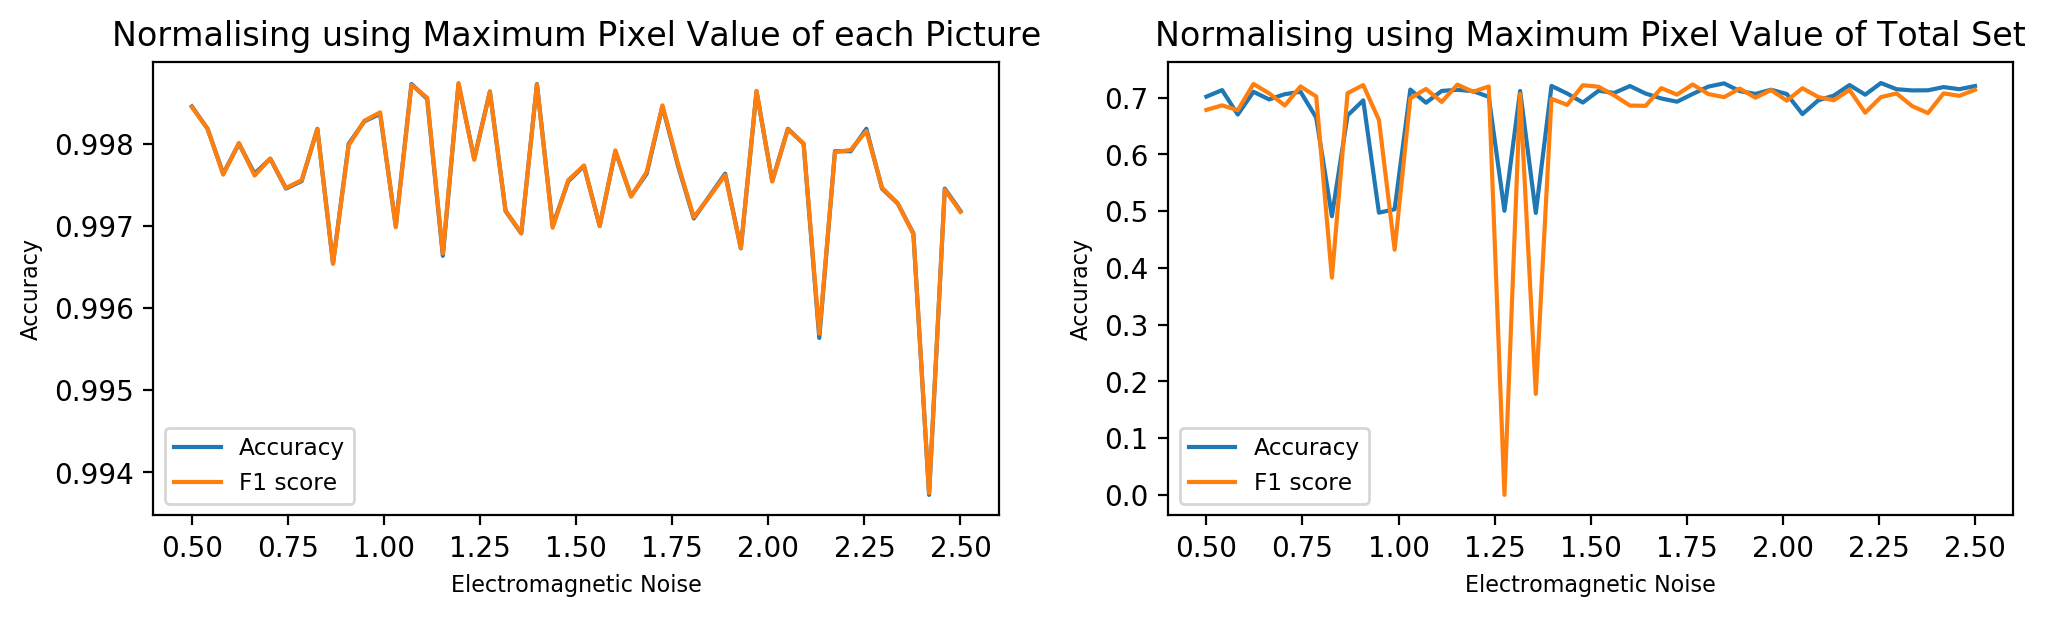

In [676]:
fig3 = plt.figure(figsize=(12,3))
ax1 = fig3.add_subplot(121)
ax1.plot(noises4,ntb2acc, label = 'Accuracy')
ax1.plot(noises4,ntb2f1, label = 'F1 score')
ax1.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax1.set_ylabel('Accuracy',fontsize= 8)
ax1.legend(loc='best',fontsize ='small')
ax1.set_title('Normalising using Maximum Pixel Value of each Picture');

ax2 = fig3.add_subplot(122)
ax2.plot(noises4,ntb4acc, label = 'Accuracy')
ax2.plot(noises4,ntb4f1, label = 'F1 score')
ax2.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax2.set_ylabel('Accuracy',fontsize= 8)
ax2.legend(loc='best',fontsize ='small')
ax2.set_title('Normalising using Maximum Pixel Value of Total Set');

In [207]:
#test 5
noises5 = np.linspace(2.5,15,10) #10 values of noise in range of 2.5-15
ntb5acc, ntb5f1 = elnoisetoboth(images,noises5,0.1,0.1,'image') #normalising by maximum pixel value of each image

Epoch 1/40
32/32 [==============================] - 9s 290ms/step - loss: 0.7976 - accuracy: 0.5224 - val_loss: 0.7006 - val_accuracy: 0.5170
Epoch 2/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6427 - accuracy: 0.6254 - val_loss: 0.6787 - val_accuracy: 0.6850
Epoch 3/40
32/32 [==============================] - 9s 291ms/step - loss: 0.5212 - accuracy: 0.7584 - val_loss: 0.7001 - val_accuracy: 0.4830
Epoch 4/40
32/32 [==============================] - 9s 292ms/step - loss: 0.3454 - accuracy: 0.8684 - val_loss: 2.0313 - val_accuracy: 0.4830
Epoch 5/40
32/32 [==============================] - 9s 293ms/step - loss: 0.2147 - accuracy: 0.9227 - val_loss: 2.2100 - val_accuracy: 0.4830
Epoch 6/40
32/32 [==============================] - 9s 292ms/step - loss: 0.1559 - accuracy: 0.9446 - val_loss: 0.9160 - val_accuracy: 0.5180
Epoch 7/40
32/32 [==============================] - 9s 292ms/step - loss: 0.1158 - accuracy: 0.9613 - val_loss: 0.2142 - val_accuracy: 0.9840
Epoch 

32/32 [==============================] - 9s 290ms/step - loss: 0.0381 - accuracy: 0.9895 - val_loss: 0.0689 - val_accuracy: 0.9870
Epoch 19/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0365 - accuracy: 0.9900 - val_loss: 0.0523 - val_accuracy: 0.9920
Epoch 20/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.0485 - val_accuracy: 0.9940
Epoch 21/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0569 - val_accuracy: 0.9930
Epoch 22/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.0344 - val_accuracy: 0.9970
Epoch 23/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0319 - accuracy: 0.9908 - val_loss: 0.0397 - val_accuracy: 0.9970
Epoch 24/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.0318 - val_accuracy: 0.9970
Epoch 25/40

32/32 [==============================] - 9s 292ms/step - loss: 0.0128 - accuracy: 0.9967 - val_loss: 0.0088 - val_accuracy: 0.9960
Epoch 36/40
32/32 [==============================] - 9s 290ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0074 - val_accuracy: 0.9980
Epoch 37/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 38/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0070 - val_accuracy: 0.9980
Epoch 39/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0069 - val_accuracy: 0.9980
Epoch 40/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.0073 - val_accuracy: 0.9980
Epoch 1/40
32/32 [==============================] - 9s 286ms/step - loss: 1.1143 - accuracy: 0.5549 - val_loss: 9.9634 - val_accuracy: 0.4890
Epoch 2/40
3

32/32 [==============================] - 9s 293ms/step - loss: 0.0836 - accuracy: 0.9711 - val_loss: 0.3099 - val_accuracy: 0.8610
Epoch 13/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0775 - accuracy: 0.9730 - val_loss: 0.0751 - val_accuracy: 0.9770
Epoch 14/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0768 - accuracy: 0.9736 - val_loss: 0.0654 - val_accuracy: 0.9790
Epoch 15/40
32/32 [==============================] - 9s 286ms/step - loss: 0.0633 - accuracy: 0.9787 - val_loss: 0.0599 - val_accuracy: 0.9820
Epoch 16/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0579 - accuracy: 0.9795 - val_loss: 0.0833 - val_accuracy: 0.9680
Epoch 17/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0542 - accuracy: 0.9814 - val_loss: 0.0561 - val_accuracy: 0.9790
Epoch 18/40
32/32 [==============================] - 9s 291ms/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 0.0453 - val_accuracy: 0.9890
Epoch 19/40

32/32 [==============================] - 9s 288ms/step - loss: 0.0404 - accuracy: 0.9898 - val_loss: 0.0442 - val_accuracy: 0.9970
Epoch 30/40
32/32 [==============================] - 9s 287ms/step - loss: 0.0378 - accuracy: 0.9916 - val_loss: 0.0399 - val_accuracy: 0.9970
Epoch 31/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0426 - val_accuracy: 0.9970
Epoch 32/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0382 - accuracy: 0.9923 - val_loss: 0.0342 - val_accuracy: 0.9970
Epoch 33/40
32/32 [==============================] - 9s 289ms/step - loss: 0.0505 - accuracy: 0.9860 - val_loss: 0.0417 - val_accuracy: 0.9970
Epoch 34/40
32/32 [==============================] - 9s 288ms/step - loss: 0.0602 - accuracy: 0.9918 - val_loss: 0.0287 - val_accuracy: 0.9970
Epoch 35/40
32/32 [==============================] - 9s 289ms/step - loss: 0.1349 - accuracy: 0.9726 - val_loss: 0.0555 - val_accuracy: 0.9970
Epoch 36/40

32/32 [==============================] - 9s 289ms/step - loss: 0.3135 - accuracy: 0.8800 - val_loss: 0.6739 - val_accuracy: 0.6540
Epoch 7/40
32/32 [==============================] - 9s 286ms/step - loss: 0.2434 - accuracy: 0.9145 - val_loss: 0.5854 - val_accuracy: 0.9290
Epoch 8/40
32/32 [==============================] - 9s 293ms/step - loss: 0.2145 - accuracy: 0.9273 - val_loss: 0.5018 - val_accuracy: 0.9810
Epoch 9/40
32/32 [==============================] - 9s 289ms/step - loss: 0.2512 - accuracy: 0.9061 - val_loss: 0.5457 - val_accuracy: 0.9040
Epoch 10/40
32/32 [==============================] - 9s 287ms/step - loss: 0.1625 - accuracy: 0.9498 - val_loss: 0.3253 - val_accuracy: 0.9940
Epoch 11/40
32/32 [==============================] - 9s 286ms/step - loss: 0.1883 - accuracy: 0.9416 - val_loss: 0.3345 - val_accuracy: 0.9940
Epoch 12/40
32/32 [==============================] - 9s 287ms/step - loss: 0.1871 - accuracy: 0.9314 - val_loss: 0.3161 - val_accuracy: 0.9950
Epoch 13/40
32

32/32 [==============================] - 9s 287ms/step - loss: 0.1722 - accuracy: 0.9844 - val_loss: 0.1177 - val_accuracy: 0.9880
Epoch 24/40
32/32 [==============================] - 9s 287ms/step - loss: 0.1719 - accuracy: 0.9550 - val_loss: 0.1138 - val_accuracy: 0.9800
Epoch 25/40
32/32 [==============================] - 9s 288ms/step - loss: 0.1484 - accuracy: 0.9843 - val_loss: 0.1223 - val_accuracy: 0.9880
Epoch 26/40
32/32 [==============================] - 9s 285ms/step - loss: 0.1295 - accuracy: 0.9676 - val_loss: 0.1077 - val_accuracy: 0.9790
Epoch 27/40
32/32 [==============================] - 9s 287ms/step - loss: 0.1222 - accuracy: 0.9794 - val_loss: 0.1007 - val_accuracy: 0.9860
Epoch 28/40
32/32 [==============================] - 9s 285ms/step - loss: 0.1251 - accuracy: 0.9653 - val_loss: 0.0972 - val_accuracy: 0.9810
Epoch 29/40
32/32 [==============================] - 9s 289ms/step - loss: 0.1129 - accuracy: 0.9825 - val_loss: 0.0933 - val_accuracy: 0.9870
Epoch 30/40

32/32 [==============================] - 9s 285ms/step - loss: 0.0508 - accuracy: 0.9884 - val_loss: 0.0438 - val_accuracy: 0.9930


In [208]:
#test 6 with 10 values of noise in range of 2.5-15
ntb6acc, ntb6f1 = elnoisetoboth(images,noises5,0.1,0.1,'array') #normalising by maximum pixel value of all images

Epoch 1/40
32/32 [==============================] - 10s 298ms/step - loss: 0.8711 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4830
Epoch 2/40
32/32 [==============================] - 9s 292ms/step - loss: 0.7286 - accuracy: 0.4914 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 3/40
32/32 [==============================] - 9s 295ms/step - loss: 0.7137 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 4/40
32/32 [==============================] - 9s 292ms/step - loss: 0.7047 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 5/40
32/32 [==============================] - 9s 292ms/step - loss: 0.7013 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.4840
Epoch 6/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6996 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5080
Epoch 7/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6957 - accuracy: 0.5126 - val_loss: 0.6932 - val_accuracy: 0.5050
Epoch

32/32 [==============================] - 9s 291ms/step - loss: 0.6664 - accuracy: 0.5880 - val_loss: 0.6564 - val_accuracy: 0.6230
Epoch 19/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6518 - accuracy: 0.6120 - val_loss: 0.6418 - val_accuracy: 0.5980
Epoch 20/40
32/32 [==============================] - 9s 293ms/step - loss: 0.6820 - accuracy: 0.5782 - val_loss: 0.6741 - val_accuracy: 0.6300
Epoch 21/40
32/32 [==============================] - 9s 295ms/step - loss: 0.6637 - accuracy: 0.6043 - val_loss: 0.6495 - val_accuracy: 0.6770
Epoch 22/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6384 - accuracy: 0.6170 - val_loss: 0.6234 - val_accuracy: 0.6830
Epoch 23/40
32/32 [==============================] - 9s 291ms/step - loss: 0.6173 - accuracy: 0.6555 - val_loss: 0.5962 - val_accuracy: 0.6890
Epoch 24/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6059 - accuracy: 0.6660 - val_loss: 0.5934 - val_accuracy: 0.6990
Epoch 25/40

32/32 [==============================] - 9s 285ms/step - loss: 0.6524 - accuracy: 0.6589 - val_loss: 0.6495 - val_accuracy: 0.6770
Epoch 19/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6451 - accuracy: 0.6559 - val_loss: 0.6412 - val_accuracy: 0.6860
Epoch 20/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6364 - accuracy: 0.6531 - val_loss: 0.6334 - val_accuracy: 0.6780
Epoch 21/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6220 - accuracy: 0.6721 - val_loss: 0.6222 - val_accuracy: 0.6860
Epoch 22/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6182 - accuracy: 0.6749 - val_loss: 0.6113 - val_accuracy: 0.6930
Epoch 23/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6092 - accuracy: 0.6758 - val_loss: 0.6031 - val_accuracy: 0.6950
Epoch 24/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6072 - accuracy: 0.6784 - val_loss: 0.5978 - val_accuracy: 0.6890
Epoch 25/40

32/32 [==============================] - 9s 288ms/step - loss: 0.5518 - accuracy: 0.7199 - val_loss: 0.5489 - val_accuracy: 0.7190
Epoch 36/40
32/32 [==============================] - 9s 289ms/step - loss: 0.5592 - accuracy: 0.7101 - val_loss: 0.5518 - val_accuracy: 0.7160
Epoch 37/40
32/32 [==============================] - 9s 284ms/step - loss: 0.5532 - accuracy: 0.7221 - val_loss: 0.5539 - val_accuracy: 0.7150
Epoch 38/40
32/32 [==============================] - 9s 290ms/step - loss: 0.5523 - accuracy: 0.7181 - val_loss: 0.5534 - val_accuracy: 0.7180
Epoch 39/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5520 - accuracy: 0.7220 - val_loss: 0.5572 - val_accuracy: 0.7130
Epoch 40/40
32/32 [==============================] - 9s 288ms/step - loss: 0.5420 - accuracy: 0.7262 - val_loss: 0.5475 - val_accuracy: 0.7160
Epoch 1/40
32/32 [==============================] - 9s 283ms/step - loss: 1.3253 - accuracy: 0.5006 - val_loss: 0.7001 - val_accuracy: 0.5110
Epoch 2/40
3

32/32 [==============================] - 9s 284ms/step - loss: 0.6960 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4680
Epoch 4/40
32/32 [==============================] - 9s 280ms/step - loss: 0.6948 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4680
Epoch 5/40
32/32 [==============================] - 9s 279ms/step - loss: 0.6936 - accuracy: 0.5066 - val_loss: 0.6934 - val_accuracy: 0.4680
Epoch 6/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6934 - val_accuracy: 0.4680
Epoch 7/40
32/32 [==============================] - 9s 285ms/step - loss: 0.6936 - accuracy: 0.4974 - val_loss: 0.6936 - val_accuracy: 0.4680
Epoch 8/40
32/32 [==============================] - 9s 292ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4680
Epoch 9/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6933 - accuracy: 0.4981 - val_loss: 0.6937 - val_accuracy: 0.4680
Epoch 10/40
32/32

32/32 [==============================] - 9s 289ms/step - loss: 0.6960 - accuracy: 0.5096 - val_loss: 1.5157 - val_accuracy: 0.4930
Epoch 4/40
32/32 [==============================] - 9s 287ms/step - loss: 0.6940 - accuracy: 0.5094 - val_loss: 0.7483 - val_accuracy: 0.4930
Epoch 5/40
32/32 [==============================] - 9s 286ms/step - loss: 0.6937 - accuracy: 0.5091 - val_loss: 0.7006 - val_accuracy: 0.4930
Epoch 6/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6934 - accuracy: 0.5109 - val_loss: 0.9803 - val_accuracy: 0.4930
Epoch 7/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6930 - accuracy: 0.5165 - val_loss: 1.7841 - val_accuracy: 0.4930
Epoch 8/40
32/32 [==============================] - 9s 288ms/step - loss: 0.6937 - accuracy: 0.5021 - val_loss: 1.6013 - val_accuracy: 0.4930
Epoch 9/40
32/32 [==============================] - 9s 290ms/step - loss: 0.6929 - accuracy: 0.5178 - val_loss: 0.7249 - val_accuracy: 0.5070
Epoch 10/40
32/32

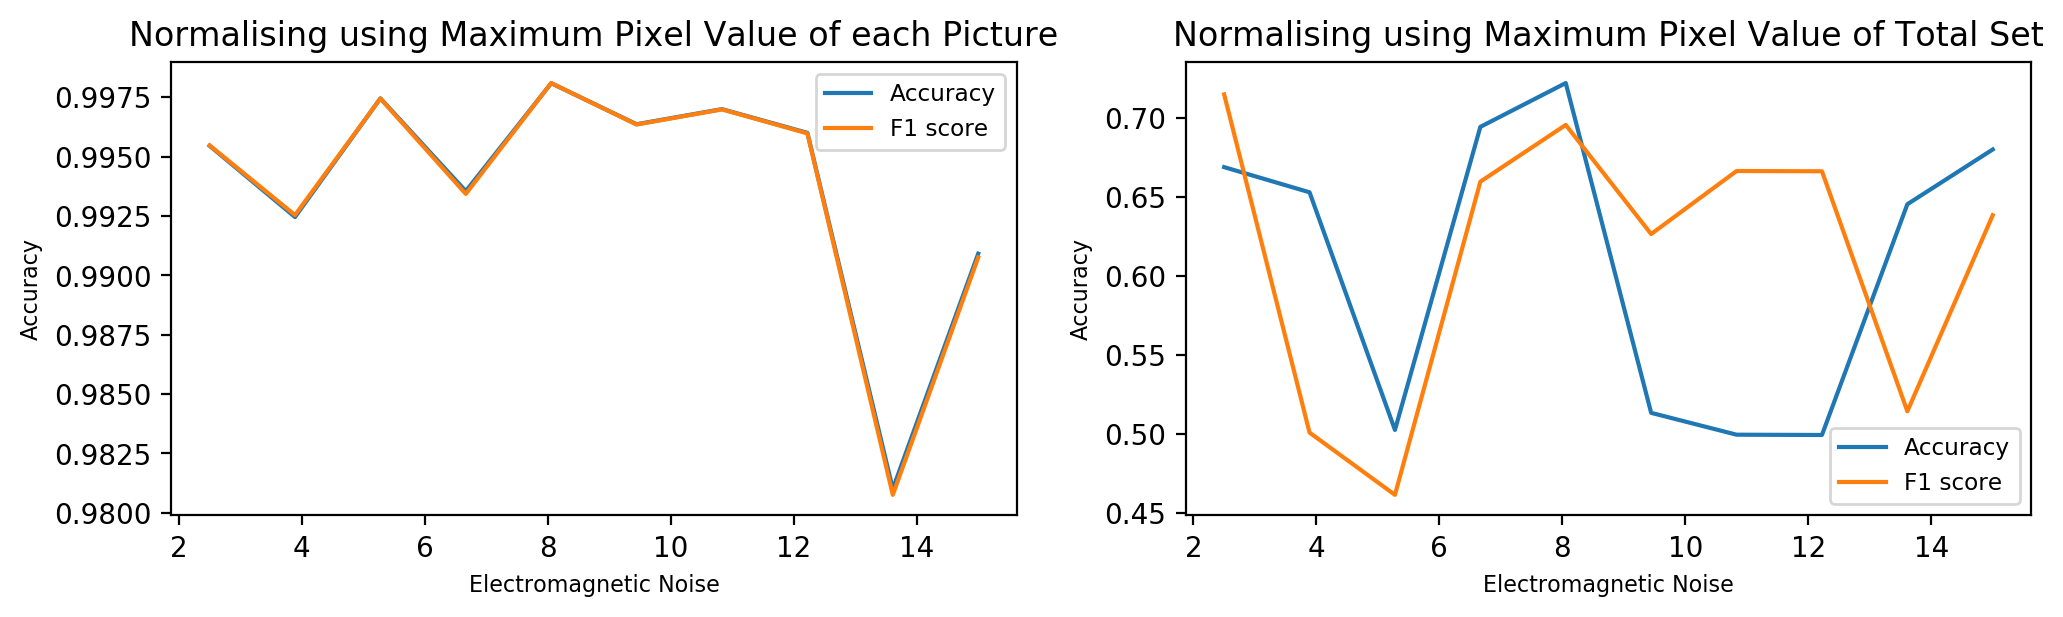

In [677]:
fig4 = plt.figure(figsize=(12,3))
ax1 = fig4.add_subplot(121)
ax1.plot(noises5,ntb5acc, label = 'Accuracy')
ax1.plot(noises5,ntb5f1, label = 'F1 score')
ax1.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax1.set_ylabel('Accuracy',fontsize= 8)
ax1.legend(loc='best',fontsize ='small')
ax1.set_title('Normalising using Maximum Pixel Value of each Picture');

ax2 = fig4.add_subplot(122)
ax2.plot(noises5,ntb6acc, label = 'Accuracy')
ax2.plot(noises5,ntb6f1, label = 'F1 score')
ax2.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax2.set_ylabel('Accuracy',fontsize= 8)
ax2.legend(loc='best',fontsize ='small')
ax2.set_title('Normalising using Maximum Pixel Value of Total Set');

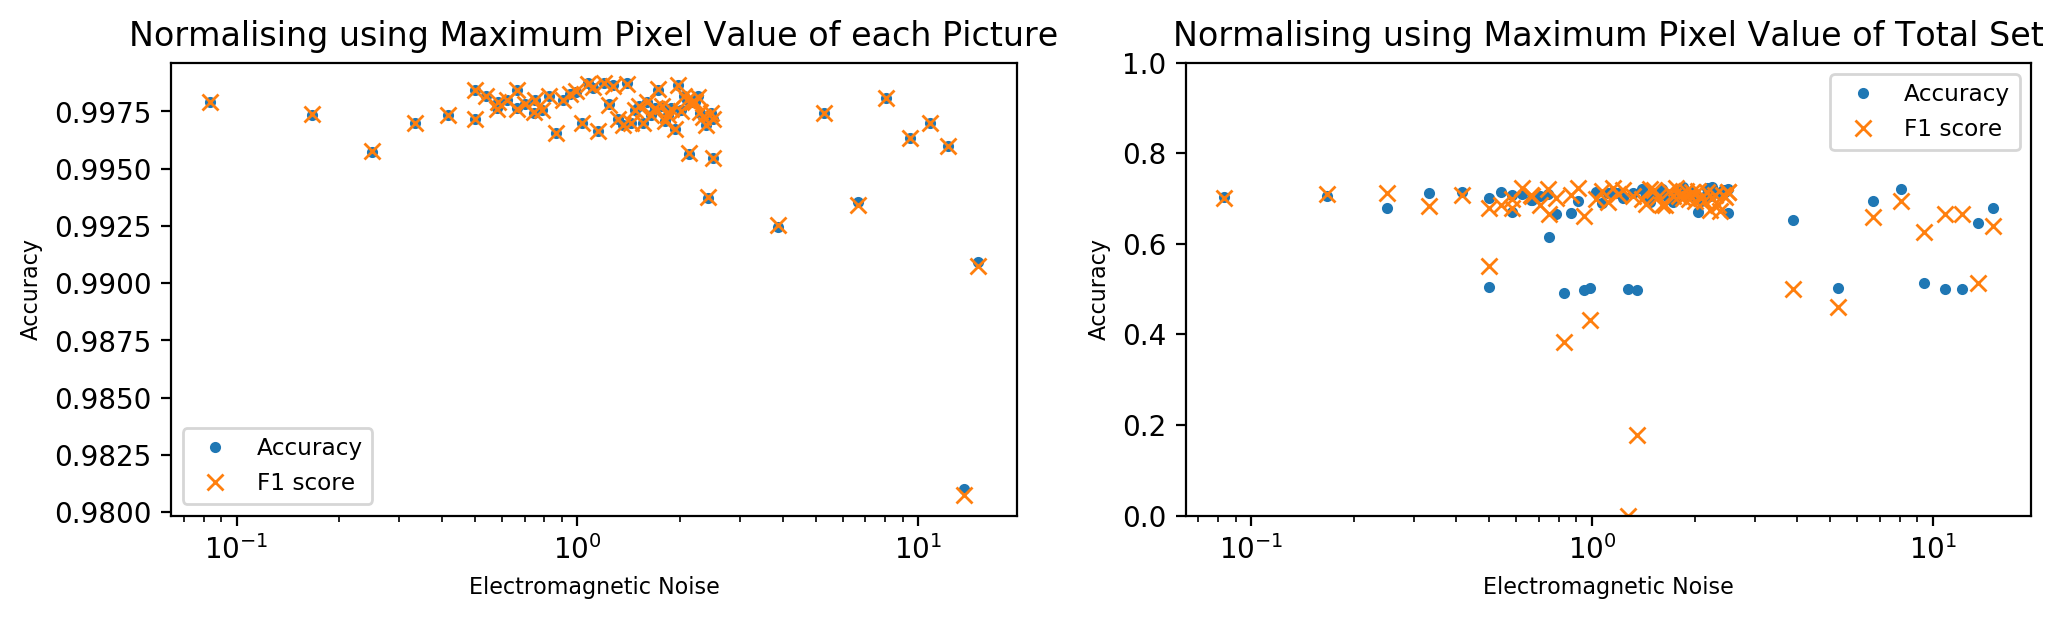

In [678]:
fig5 = plt.figure(figsize=(12,3))
ax1 = fig5.add_subplot(121)
ax1.plot(np.concatenate((noises3,noises4,noises5)),np.concatenate((ntb1acc,ntb2acc,ntb5acc))
                                                                          ,'.', label = 'Accuracy')
ax1.plot(np.concatenate((noises3,noises4,noises5)),np.concatenate((ntb1f1,ntb2f1,ntb5f1))
                                                                          ,'x', label = 'F1 score')
ax1.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy',fontsize= 8)
ax1.legend(loc='best',fontsize ='small')
ax1.set_title('Normalising using Maximum Pixel Value of each Picture');

ax2 = fig5.add_subplot(122)
ax2.plot(np.concatenate((noises3,noises4,noises5)),np.concatenate((ntb3acc,ntb4acc,ntb6acc))
                                                                          ,'.', label = 'Accuracy')
ax2.plot(np.concatenate((noises3,noises4,noises5)),np.concatenate((ntb3f1,ntb4f1,ntb6f1))
                                                                         ,'x', label = 'F1 score')
ax2.set_xlabel('Electromagnetic Noise',fontsize= 8)
ax2.set_xscale('log')
ax2.set_ylim(0,1)
ax2.set_ylabel('Accuracy',fontsize= 8)
ax2.legend(loc='best',fontsize ='small')
ax2.set_title('Normalising using Maximum Pixel Value of Total Set');

In [723]:
print('''Normalised by Image: 
  Noise Range 0-0.7:   Accuracy ={:.4f}, F1 score ={:.4f}
  Noise Range 0.5-2.5: Accuracy ={:.4f}, F1 score ={:.4f}
  Noise Range 2.5-15:  Accuracy ={:.4f}, F1 score ={:.4f}
  Average:             Accuracy= {:.4f}, F1 score= {:.4f}'''.format(np.mean(ntb1acc), np.mean(ntb1f1),
                                                      np.mean(ntb2acc), np.mean(ntb2f1),
                                                      np.mean(ntb5acc), np.mean(ntb5f1),
                                                      np.mean(np.concatenate((ntb1acc,ntb2acc,ntb5acc))),
                                                      np.mean(np.concatenate((ntb1f1,ntb2f1,ntb5f1)))))
print('\n')
print('''Normalised by Array: 
  Noise Range 0-0.7:   Accuracy ={:.4f}, F1 score ={:.4f}
  Noise Range 0.5-2.5: Accuracy ={:.4f}, F1 score ={:.4f}
  Noise Range 2.5-15:  Accuracy ={:.4f}, F1 score ={:.4f}
  Average:             Accuracy= {:.4f}, F1 score= {:.4f}'''.format(np.mean(ntb3acc), np.mean(ntb3f1),
                                                      np.mean(ntb4acc), np.mean(ntb4f1),
                                                      np.mean(ntb6acc), np.mean(ntb6f1),
                                                      np.mean(np.concatenate((ntb3acc,ntb4acc,ntb6acc))),
                                                      np.mean(np.concatenate((ntb3f1,ntb4f1,ntb6f1)))))

Normalised by Image: 
  Noise Range 0-0.7:   Accuracy =0.9974, F1 score =0.9974
  Noise Range 0.5-2.5: Accuracy =0.9976, F1 score =0.9976
  Noise Range 2.5-15:  Accuracy =0.9938, F1 score =0.9938
  Average:             Accuracy= 0.9970, F1 score= 0.9970


Normalised by Array: 
  Noise Range 0-0.7:   Accuracy =0.6538, F1 score =0.6631
  Noise Range 0.5-2.5: Accuracy =0.6849, F1 score =0.6660
  Noise Range 2.5-15:  Accuracy =0.6077, F1 score =0.6143
  Average:             Accuracy= 0.6695, F1 score= 0.6582


The mean accuracies and F$_1$ scores show that normalising each image produces much better results, it has an accuracy and F$_1$ score 0.3 higher in all ranges of noise. This could be due to each neutrino signal having a higher value in comparison to the noise, but if this was the case the both accuracies would have fallen more significantly over this range of noise. The likely difference in accuracy could be due to the variation in the maximum signal strength meaning the model is unable to tell the difference between noise and extreme signals.  

[Back to Contents](#contents)

##  <a id="PNE"></a> Predicting the Neutrino Energy

Having produced a model that is able to classify the neutrino images successfully the next step was to determine the neutrino energy from each image. This information will be useful in learning about the supernova that caused the neutrino production. Giving insight to the life cycle of stars especially those stars that are much larger than ours.

Text(0.5, 1.0, 'Distribution of Neutrino Energy')

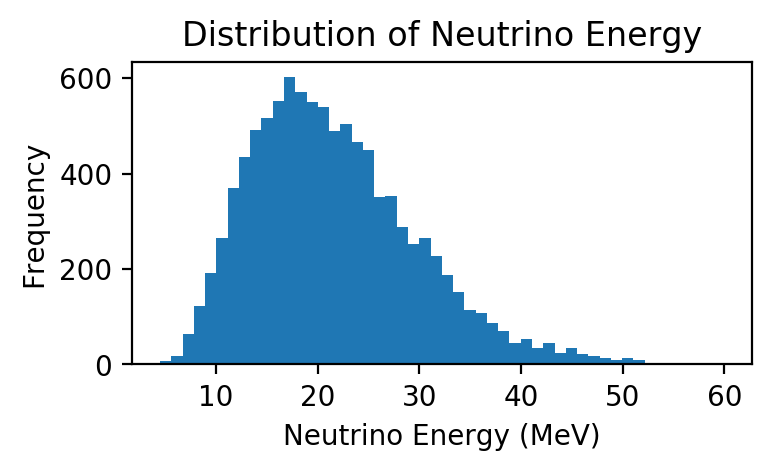

In [545]:
#plotting distribution of neutrino energies
NeutEnergy = meta_df[1].values
plt.figure(figsize=(4,2))
plt.hist(NeutEnergy,bins=50)
plt.xlabel('Neutrino Energy (MeV)')
plt.ylabel('Frequency')
plt.title('Distribution of Neutrino Energy')

In this distribution we can see that most of the neutrino energies have a value of around 20 MeV. This distribution is more rounded than the distribution of maximum pixel values but the two may have links.

In [728]:
#adding the maximum pixel values to the meta data 
meta_df = pd.concat([meta_df,pd.DataFrame(maximageval)], axis=1,ignore_index=True)
meta_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,21.2005,2.0,6.0,12.0,21.2005,0.0,0.0,21.2005,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0
1,21.8617,2.0,3.0,12.0,21.8617,0.0,0.0,21.8617,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,24.0
2,17.6584,2.0,4.0,12.0,17.6584,0.0,0.0,17.6584,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,21.0
3,20.1423,2.0,5.0,12.0,20.1423,0.0,0.0,20.1423,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,24.0
4,23.3148,2.0,5.0,12.0,23.3148,0.0,0.0,23.3148,1.000180e+09,37224.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,26.0


In [731]:
#looking at the correlation between neutrino energy and the maximum pixel value of images
meta_df[[0,63]].corr()

,0,63
0,1.000000,0.236413
63,0.236413,1.000000


There is a possitive correlation but not a significant amount. This correlation would suggest that the best normalising by the maximum pixel value of all the images, as it would not lose data that had a correlation with the target values.

In [580]:
def create_model3():
    """
    Initiates new model used for determining the neutrino energy associated with images of neutrinos. The
    model uses a BatchNormalization layer to accelerate learning by rescalling the inputs. The next three 
    layers are made from a 2D convolutional layer to create a feature map. Folled by a MaxPooling2d layer
    extracting the important structural elements of the feature map. To minimise over fitting a drop out 
    layer is used. The last set of layers are the flatten layer followed by two dense layers, both of which
    use a ReLU activation necessary for solving the regression problem.The dense layers are seperated by
    one final dropout layer to prevent overfitting.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(100,100,1)))
    model.add(keras.layers.Conv2D(2, (3,3),activation='relu',input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Flatten()) 
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dropout(0.1))   
    model.add(keras.layers.Dense(1,activation='relu'))
    return model
create_model3().summary()

Model: "sequential_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_411 (Bat (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d_514 (Conv2D)          (None, 98, 98, 2)         20        
_________________________________________________________________
max_pooling2d_514 (MaxPoolin (None, 49, 49, 2)         0         
_________________________________________________________________
dropout_762 (Dropout)        (None, 49, 49, 2)         0         
_________________________________________________________________
flatten_307 (Flatten)        (None, 4802)              0         
_________________________________________________________________
dense_695 (Dense)            (None, 32)                153696    
_________________________________________________________________
dropout_763 (Dropout)        (None, 32)             

In [353]:
# setting fixed parameters for the model to be tested on
val_sample = 0.1
test_sample=0.1
noise = 0.25

In [354]:
#test 1

#testing the model with a noise of 2.5 and normalising by the maximum of the total set
images_scale1 = images/np.amax(images)
images_scale_noise1 = add_noise(images_scale1,noise)

#setting data for model
X1 = images_scale_noise1
y1 = NeutEnergy 

#splitting data into train, validation and test samples
X1_train = X1[:int(X1.shape[0]*(1-test_sample-val_sample))]
X1_val = X1[int(X1.shape[0]*(1-test_sample-val_sample)):int(X1.shape[0]*(1-test_sample)):]
X1_test = X1[int(X1.shape[0]*(1-test_sample)):]

y1_train = y1[:int(y1.shape[0]*(1-test_sample-val_sample))]
y1_val = y1[int(y1.shape[0]*(1-test_sample-val_sample)):int(y1.shape[0]*(1-test_sample)):]
y1_test = y1[int(y1.shape[0]*(1-test_sample)):]

#reshaping image arrays so that they can be passed through CNN
X1_train = X1_train.reshape(X1_train.shape[0],100,100,1)
X1_val = X1_val.reshape(X1_val.shape[0],100,100,1)
X1_test  = X1_test.reshape(X1_test.shape[0],100,100,1)

y1_train = y1_train.reshape(y1_train.shape[0],1)
y1_val = y1_val.reshape(y1_val.shape[0],1)
y1_test = y1_test.reshape(y1_test.shape[0],1)

In [609]:
#initiating and compiling model
estimator1 = create_model3()
estimator1.compile(optimizer='adam',loss='MAE')

#to prevent overfitting
early_stop1 = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',min_delta=0.1, verbose=1,
                                            restore_best_weights = True, patience=20)

In [610]:
history1 = estimator1.fit(X1_train, y1_train, epochs=100,batch_size= 256,validation_data=(X1_val, y1_val),
                                                                                callbacks=[early_stop1])

Epoch 1/100
32/32 [==============================] - 8s 252ms/step - loss: 7.8877 - val_loss: 21.5609
Epoch 2/100
32/32 [==============================] - 7s 234ms/step - loss: 6.6920 - val_loss: 21.0292
Epoch 3/100
32/32 [==============================] - 8s 255ms/step - loss: 6.5793 - val_loss: 20.3175
Epoch 4/100
32/32 [==============================] - 7s 221ms/step - loss: 6.5869 - val_loss: 19.8452
Epoch 5/100
32/32 [==============================] - 7s 221ms/step - loss: 6.5455 - val_loss: 18.9363
Epoch 6/100
32/32 [==============================] - 7s 224ms/step - loss: 6.5232 - val_loss: 18.2003
Epoch 7/100
32/32 [==============================] - 7s 222ms/step - loss: 6.5389 - val_loss: 16.6800
Epoch 8/100
32/32 [==============================] - 7s 223ms/step - loss: 6.4324 - val_loss: 16.0284
Epoch 9/100
32/32 [==============================] - 7s 228ms/step - loss: 6.3633 - val_loss: 14.1376
Epoch 10/100
32/32 [==============================] - 7s 230ms/step - loss: 6.3653

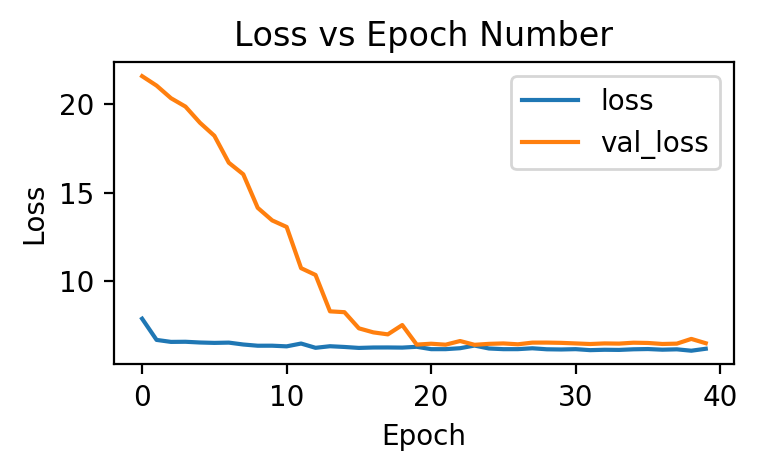

In [683]:
plt.figure(figsize=(4,2))
plt.title('Loss vs Epoch Number')
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

In [687]:
#determining neutrino energy for the test sample data
y1_test_pred = estimator1.predict(X1_test) 

#calculating the resolution of the model
ResTest1 = (y1_test_pred - y1_test)
ResTest1Per = 100*ResTest1/y1_test

print('Mean Resolution = {:.2f} MeV'.format(np.mean(ResTest1)))
print('Mean Resolution = {:.2f}%'.format(np.mean(ResTest1Per)))

Mean Resolution = -1.33 MeV
Mean Resolution = 10.00%


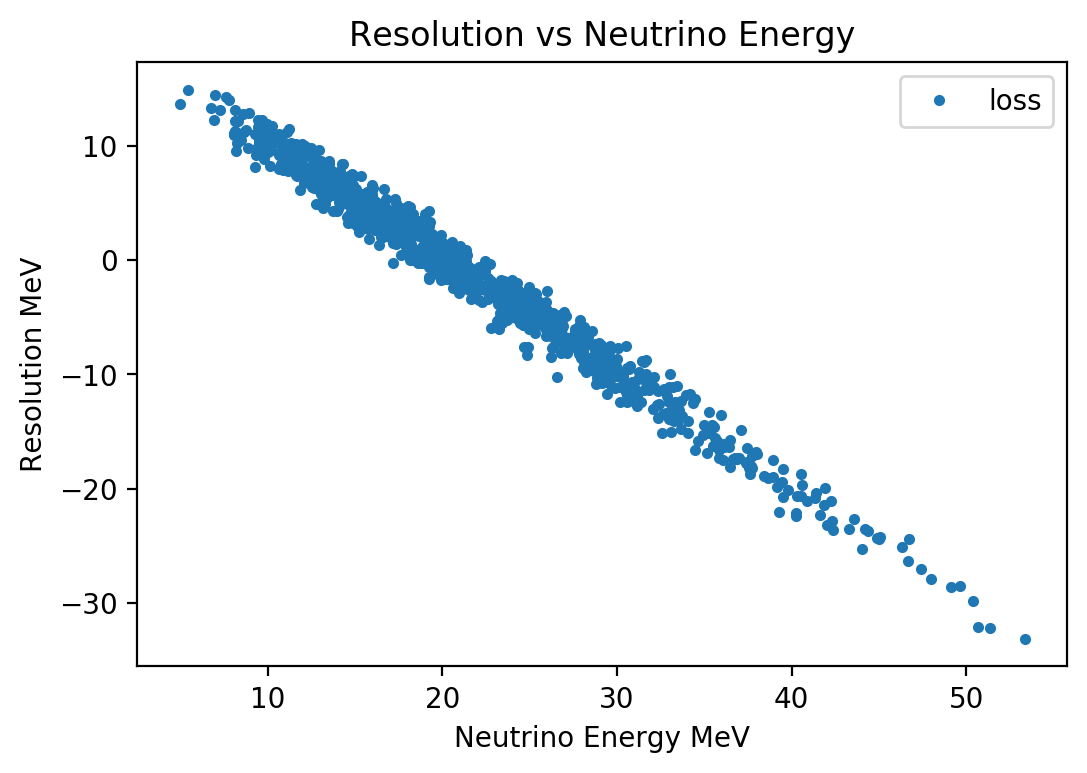

In [691]:
plt.title('Resolution vs Neutrino Energy')
plt.plot(y1_test,ResTest1,'.', label='loss')
plt.xlabel('Neutrino Energy MeV')
plt.ylabel('Resolution MeV')
plt.legend(loc='best')

In [586]:
#test 2

#testing model with noise of 0.25 and normalising by the maximum pixel value of each image
images_scale2 = np.zeros(images.shape)
for i in range(images.shape[0]):
    images_scale2[i] = images[i]/np.amax(images[i])
images_scale_noise2 = add_noise(images_scale2,noise)

In [587]:
#setting data for model
X2 = images_scale_noise2
y2 = NeutEnergy 

#splitting data into train, validation and test samples
X2_train = X2[:int(X2.shape[0]*(1-test_sample-val_sample))]
X2_val = X2[int(X2.shape[0]*(1-test_sample-val_sample)):int(X2.shape[0]*(1-test_sample)):]
X2_test = X2[int(X2.shape[0]*(1-test_sample)):]

y2_train = y2[:int(y2.shape[0]*(1-test_sample-val_sample))]
y2_val = y2[int(y2.shape[0]*(1-test_sample-val_sample)):int(y2.shape[0]*(1-test_sample)):]
y2_test = y2[int(y2.shape[0]*(1-test_sample)):]

#reshaping image arrays so that they can be passed through CNN
X2_train = X2_train.reshape(X2_train.shape[0],100,100,1)
X2_val = X2_val.reshape(X2_val.shape[0],100,100,1)
X2_test  = X2_test.reshape(X2_test.shape[0],100,100,1)

y2_train = y2_train.reshape(y2_train.shape[0],1)
y2_val = y2_val.reshape(y2_val.shape[0],1)
y2_test = y2_test.reshape(y2_test.shape[0],1)

In [614]:
#initiating and starting model
estimator2 = create_model3()
estimator2.compile(optimizer='adam',loss='MAE')

In [615]:
history2 = estimator2.fit(X2_train, y2_train, epochs=100,batch_size= 256,validation_data=(X2_val, y2_val),
                                                                                callbacks=[early_stop1])

Epoch 1/100
32/32 [==============================] - 7s 211ms/step - loss: 7.7692 - val_loss: 14.2239
Epoch 2/100
32/32 [==============================] - 7s 228ms/step - loss: 6.5780 - val_loss: 15.3790
Epoch 3/100
32/32 [==============================] - 7s 217ms/step - loss: 6.5458 - val_loss: 15.7230
Epoch 4/100
32/32 [==============================] - 7s 225ms/step - loss: 6.3689 - val_loss: 14.7064
Epoch 5/100
32/32 [==============================] - 7s 225ms/step - loss: 6.3142 - val_loss: 14.2361
Epoch 6/100
32/32 [==============================] - 7s 223ms/step - loss: 6.1636 - val_loss: 14.5219
Epoch 7/100
32/32 [==============================] - 7s 222ms/step - loss: 6.1483 - val_loss: 13.9902
Epoch 8/100
32/32 [==============================] - 7s 225ms/step - loss: 6.0351 - val_loss: 13.2439
Epoch 9/100
32/32 [==============================] - 7s 221ms/step - loss: 6.0432 - val_loss: 11.8853
Epoch 10/100
32/32 [==============================] - 7s 229ms/step - loss: 6.0320

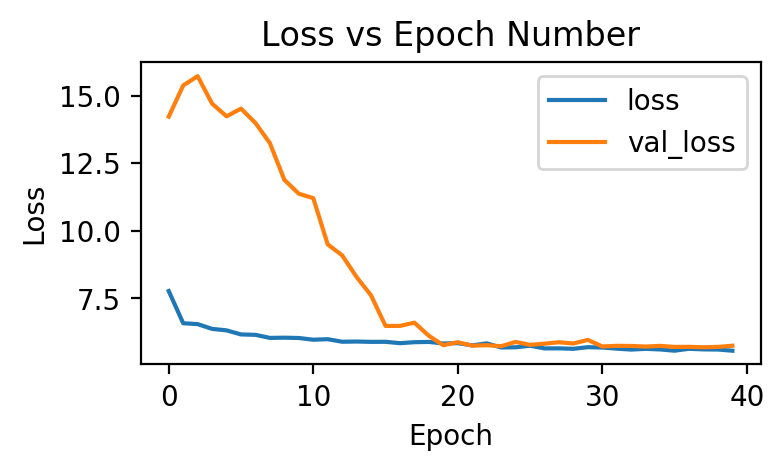

In [688]:
plt.figure(figsize=(4,2))
plt.title('Loss vs Epoch Number')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

In [694]:
#determining the neutrino energy for the test sample data
y2_test_pred = estimator2.predict(X2_test)
ResTest2 = (y2_test_pred - y2_test)
ResTest2Per = 100*ResTest2/y2_test

print('Mean Resolution = {:.2f} MeV'.format(np.mean(ResTest2)))
print('Mean Resolution = {:.2f}%'.format(np.mean(ResTest2Per)))

Mean Resolution = -0.98 MeV
Mean Resolution = 9.35%


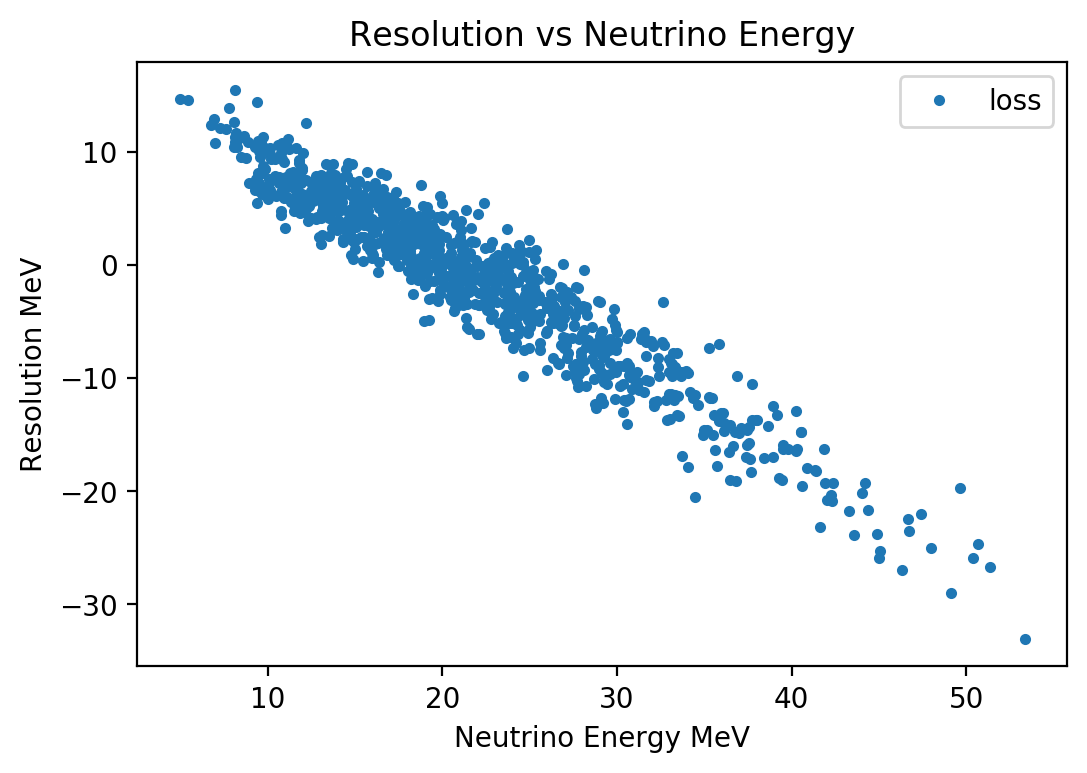

In [690]:
plt.title('Resolution vs Neutrino Energy')
plt.plot(y2_test,ResTest2,'.', label='loss')
plt.xlabel('Neutrino Energy MeV')
plt.ylabel('Resolution MeV')
plt.legend(loc='best')

In [593]:
#test 3

#testing model with no noise and normalising by maximum pixel value of the total set

#setting data for model
X3 = images_scale2
y3 = NeutEnergy 

#splitting data into train, validation and test samples
X3_train = X3[:int(X3.shape[0]*(1-test_sample-val_sample))]
X3_val = X3[int(X3.shape[0]*(1-test_sample-val_sample)):int(X3.shape[0]*(1-test_sample)):]
X3_test = X3[int(X3.shape[0]*(1-test_sample)):]

y3_train = y[:int(y3.shape[0]*(1-test_sample-val_sample))]
y3_val = y[int(y3.shape[0]*(1-test_sample-val_sample)):int(y3.shape[0]*(1-test_sample)):]
y3_test = y[int(y3.shape[0]*(1-test_sample)):]

#reshaping image arrays so that they can be passed through CNN
X3_train = X3_train.reshape(X3_train.shape[0],100,100,1)
X3_val = X3_val.reshape(X3_val.shape[0],100,100,1)
X3_test  = X3_test.reshape(X3_test.shape[0],100,100,1)

y3_train = y3_train.reshape(y3_train.shape[0],1)
y3_val = y3_val.reshape(y3_val.shape[0],1)
y3_test = y3_test.reshape(y3_test.shape[0],1)

In [594]:
#initiating and compiling the model
estimator3 = create_model3()
estimator3.compile(optimizer='adam',loss='MAE')

In [595]:
history3 = estimator3.fit(X3_train, y3_train, epochs=100,batch_size= 256,validation_data=(X3_val, y3_val),
                                                                                callbacks=[early_stop1])

Epoch 1/100
32/32 [==============================] - 8s 236ms/step - loss: 12.0417 - val_loss: 17.0305
Epoch 2/100
32/32 [==============================] - 8s 242ms/step - loss: 6.6793 - val_loss: 16.1259
Epoch 3/100
32/32 [==============================] - 8s 238ms/step - loss: 6.1852 - val_loss: 13.6790
Epoch 4/100
32/32 [==============================] - 7s 221ms/step - loss: 5.8781 - val_loss: 11.9098
Epoch 5/100
32/32 [==============================] - 7s 219ms/step - loss: 5.7268 - val_loss: 10.9209
Epoch 6/100
32/32 [==============================] - 7s 217ms/step - loss: 5.6283 - val_loss: 9.7773
Epoch 7/100
32/32 [==============================] - 7s 222ms/step - loss: 5.5352 - val_loss: 9.5473
Epoch 8/100
32/32 [==============================] - 7s 218ms/step - loss: 5.5259 - val_loss: 9.5443
Epoch 9/100
32/32 [==============================] - 7s 220ms/step - loss: 5.4730 - val_loss: 8.8412
Epoch 10/100
32/32 [==============================] - 8s 262ms/step - loss: 5.5010 - 

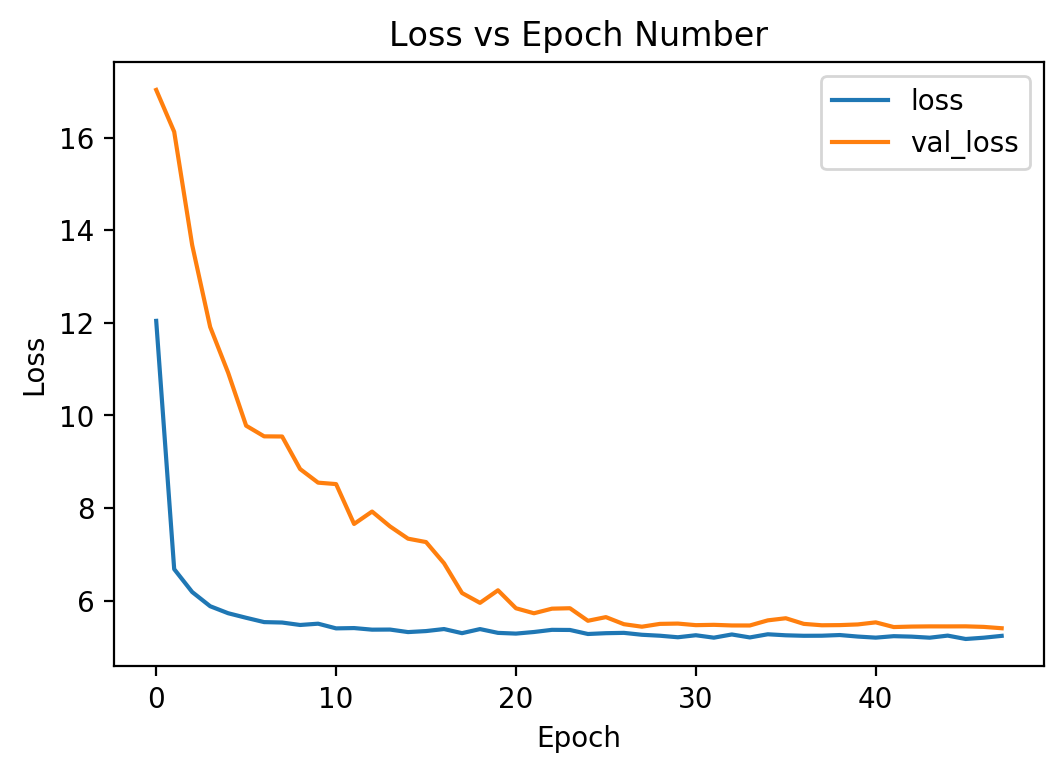

In [692]:
plt.title('Loss vs Epoch Number')
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

In [698]:
#determining neutrino energy for the test sample data
y3_test_pred = estimator3.predict(X3_test)
ResTest3 = (y3_test_pred - y3_test)
ResTest3Per = 100*ResTest3/y3_test

print('Mean Resolution = {:.2f} MeV'.format(np.mean(ResTest3)))
print('Mean Resolution = {:.2f}%'.format(np.mean(ResTest3Per)))

Mean Resolution = -0.75 MeV
Mean Resolution = 8.63%


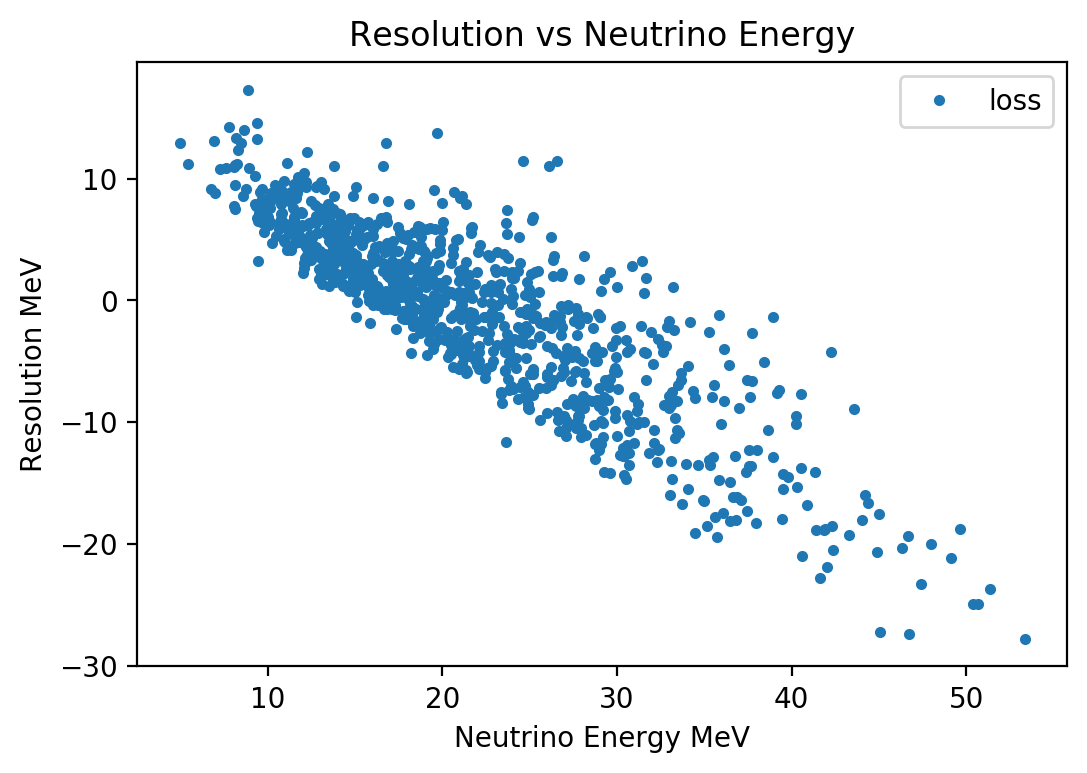

In [695]:
plt.plot(y3_test,ResTest3,'.', label='loss')
plt.title('Resolution vs Neutrino Energy')
plt.xlabel('Neutrino Energy MeV')
plt.ylabel('Resolution MeV')
plt.legend(loc='best')

In [599]:
#test 4

#testing model with no noise and normalising by the maximum pixel value of each image

#setting data for model
X4 = images_scale1
y4 = NeutEnergy 

#splitting the data into train, validation and test samples
X4_train = X4[:int(X4.shape[0]*(1-test_sample-val_sample))]
X4_val = X4[int(X4.shape[0]*(1-test_sample-val_sample)):int(X4.shape[0]*(1-test_sample)):]
X4_test = X4[int(X4.shape[0]*(1-test_sample)):]

y4_train = y4[:int(y4.shape[0]*(1-test_sample-val_sample))]
y4_val = y4[int(y4.shape[0]*(1-test_sample-val_sample)):int(y4.shape[0]*(1-test_sample)):]
y4_test = y4[int(y4.shape[0]*(1-test_sample)):]

#reshaping image arrays so that they can be passed through CNN
X4_train = X4_train.reshape(X4_train.shape[0],100,100,1)
X4_val = X4_val.reshape(X4_val.shape[0],100,100,1)
X4_test  = X4_test.reshape(X4_test.shape[0],100,100,1)

y4_train = y4_train.reshape(y4_train.shape[0],1)
y4_val = y4_val.reshape(y4_val.shape[0],1)
y4_test = y4_test.reshape(y4_test.shape[0],1)

In [600]:
#initiating and compiling model
estimator4 = create_model3()
estimator4.compile(optimizer='adam',loss='MAE')

In [601]:
history4 = estimator4.fit(X4_train, y4_train, epochs=100,batch_size= 256,validation_data=(X4_val, y4_val),
                                                                                callbacks=[early_stop1])

Epoch 1/100
32/32 [==============================] - 7s 215ms/step - loss: 13.8465 - val_loss: 6.2950
Epoch 2/100
32/32 [==============================] - 7s 221ms/step - loss: 5.4549 - val_loss: 8.1072
Epoch 3/100
32/32 [==============================] - 7s 219ms/step - loss: 5.0555 - val_loss: 8.8813
Epoch 4/100
32/32 [==============================] - 7s 218ms/step - loss: 4.8344 - val_loss: 8.9872
Epoch 5/100
32/32 [==============================] - 7s 219ms/step - loss: 4.7410 - val_loss: 8.9003
Epoch 6/100
32/32 [==============================] - 7s 222ms/step - loss: 4.6875 - val_loss: 9.6562
Epoch 7/100
32/32 [==============================] - 7s 220ms/step - loss: 4.6632 - val_loss: 8.8510
Epoch 8/100
32/32 [==============================] - 7s 219ms/step - loss: 4.6477 - val_loss: 8.5435
Epoch 9/100
32/32 [==============================] - 7s 219ms/step - loss: 4.6493 - val_loss: 9.5752
Epoch 10/100
32/32 [==============================] - 7s 218ms/step - loss: 4.6209 - val_l

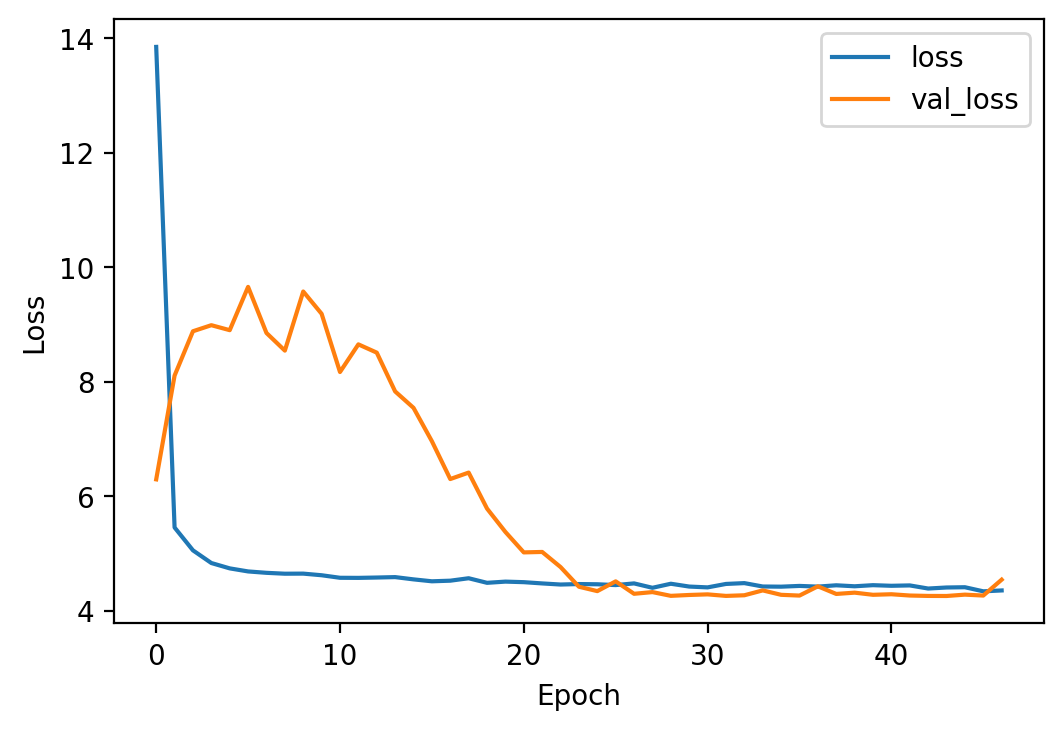

In [602]:
plt.title('Loss vs Epoch Number')
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

In [696]:
#determining neutrino energy for the test sample data
y4_test_pred = estimator4.predict(X4_test)
ResTest4 = (y4_test_pred - y4_test)
ResTest4Per = 100*ResTest4/y4_test

print('Mean Resolution = {:.2f} MeV'.format(np.mean(ResTest4)))
print('Mean Resolution = {:.2f}%'.format(np.mean(ResTest4Per)))

Mean Resolution = -1.41 MeV
Mean Resolution = 1.43%


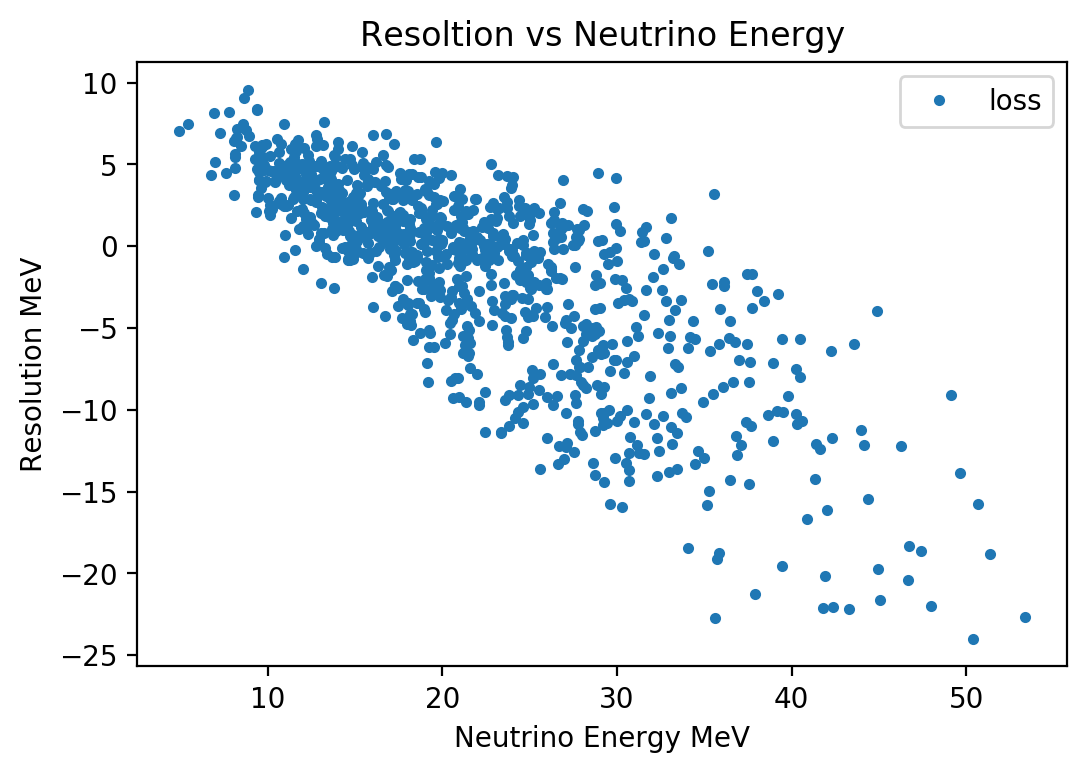

In [697]:
plt.plot(y4_test,ResTest4,'.', label='loss')
plt.title('Resoltion vs Neutrino Energy')
plt.xlabel('Neutrino Energy MeV')
plt.ylabel('Resolution MeV')
plt.legend(loc='best')

In [732]:
#creating plot comparing each different test
fig6 = plt.figure(figsize=(24,5))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 2
maxy = np.amax((ResTest1Per,ResTest2Per,ResTest3Per,ResTest4Per))+2
miny = np.amin((ResTest1Per,ResTest2Per,ResTest3Per,ResTest4Per))-2

ax1 =fig6.add_subplot(141)
ax1.plot(y1_test,ResTest1Per,'.')
ax1.set_xlabel('Neutrino Energy MeV')
ax1.set_ylabel('Resolution (%)')
ax1.set_ylim(miny,maxy)
ax1.set_title('Maximum Pixel Value of Total Set, Noise of 0.25');
labels1 = []
labels1.append("Mean Resolution= {0:.2f}%".format(np.mean(ResTest1Per)))
ax1.legend(handles, labels1, loc='best', fontsize='large', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)



ax2 =fig6.add_subplot(142)
ax2.plot(y2_test,ResTest2Per,'.')
ax2.set_xlabel('Neutrino Energy MeV')
ax2.set_ylabel('Resolution (%)')
ax2.set_ylim(miny,maxy)
ax2.set_title('Maximum Pixel Value of Image, Noise of 0.25');

labels2 = []
labels2.append("Mean Resolution= {0:.2f}%".format(np.mean(ResTest2Per)))
ax2.legend(handles, labels2, loc='best', fontsize='large', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

ax3 =fig6.add_subplot(143)
ax3.plot(y3_test,ResTest3Per,'.')
ax3.set_xlabel('Neutrino Energy MeV')
ax3.set_ylabel('Resolution (%)')
ax3.set_ylim(miny,maxy)
ax3.set_title('Maximum Pixel Value of Total Set, No Noise');

labels3 = []
labels3.append("Mean Resolution= {0:.2f}%".format(np.mean(ResTest3Per)))
ax3.legend(handles, labels3, loc='best', fontsize='large', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

ax4 =fig6.add_subplot(144)
ax4.plot(y4_test,ResTest4Per,'.')
ax4.set_xlabel('Neutrino Energy MeV')
ax4.set_ylabel('Resolution (%)')
ax4.set_ylim(miny,maxy)
ax4.set_title('Maximum Pixel Value of Image, No Noise');

labels4 = []
labels4.append("Mean Resolution= {0:.2f}%".format(np.mean(ResTest4Per)))
ax4.legend(handles, labels4, loc='best', fontsize='large', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f82871fe4d0> (for post_execute):


KeyError: (7331.0, 0.0, '7331', 'black', 'top', 'center', 2262668676990938563, 90, None, 200.0, <weakref at 0x7f7abef2c8f0; to 'RendererAgg' at 0x7f7af5a6eb50>, 1.2)

KeyError: (7331.0, 0.0, '7331', 'black', 'top', 'center', 2262668676990938563, 90, None, 200.0, <weakref at 0x7f7abef2c8f0; to 'RendererAgg' at 0x7f7af5a6eb50>, 1.2)

<Figure size 4800x1000 with 4 Axes>

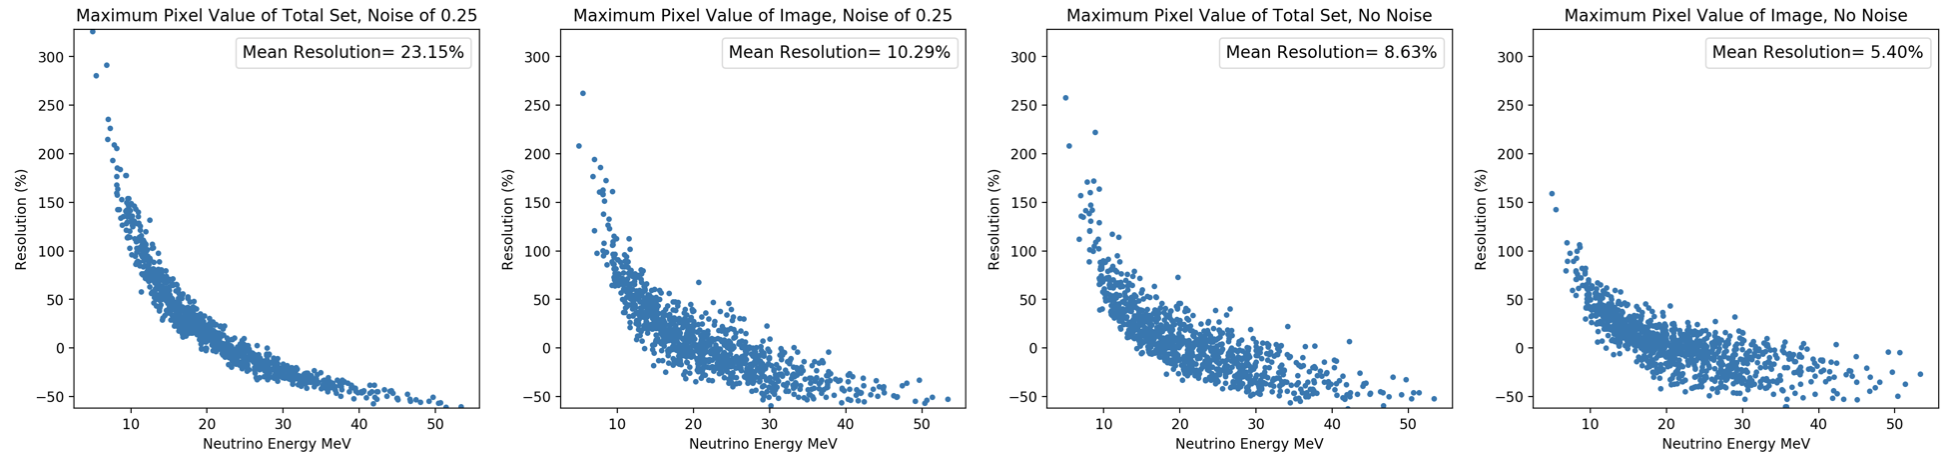

The most promising model was when the noise was added to the images that had been normalised by the maximum pixel value of the total set. The reason that this result is the most promising is shown by how all the point are close together and form a thinner line indicating the model was more ‘decisive’ with each input image. The overall accuracy of the models which were trained and tested with images with simulated noise added are low, both methods of normalisation achieved a mean resolution of around 10%. The resolution of the models improves when the images had no noise. The best mean resolution was achieved when normalising by the maximum pixel value of each image and has a value of 1.43%. This seemingly good resolution however is a result of the model having a more balanced prediction outside of the range 20-30 MeV for the neutrino, meaning that the over and underestimates almost cancelled out.

[Back to Contents](#contents)

##  <a id="PNFSP"></a> Predicting the Number of Final State Particles

Predicting the number of final state particles is useful to learn about how neutrinos of certain energies interact with different particles and learning more about sub-atomic particles.

In [726]:
finalstate = meta_df[2].values             #number of final state particles for each image
valuefstate = np.sort(meta_df[2].unique()) #all unique number of final state particles
print(valuefstate)

[ 3.  4.  5.  6.  7.  8.  9. 10.]


In [399]:
def chlab(oglabels):
    """
    Function used to change a numpy array of final state particles in a form that works for a
    'SparseCategoricalCrossentropy' loss function.
    
    Input:  oglabels  - list of numbers representing the number of final state particles
    Output: newlabels - list of labels with values from 0 to n where n is the number of
                        unique number of values in finalstate, each number mapping to the 
                        number of final state particles
    """
    l = len(oglabels)
    newlabels = np.zeros(l)
    for i in range(l):
        for j in range(len(valuefstate)):
            if oglabels[i] == valuefstate[j]:
                newlabels[i] = j               
    return newlabels

In [400]:
def retlab(newlabels):
    """
    Function used to return labels from a model using a 'SparseCategoricalCrossentropy' loss function
    to the original number of final state particles.
    
    Input: newlabels - list of labels with values from 0 to n where n is the number of
                        unique number of values in finalstate, each number mapping to the 
                        number of final state particles
    Output:  oglabels  - list of numbers representing the number of final state particles
    """
    l = len(newlabels)
    oglabels = np.zeros(l)
    for i in range(l):
        for j in range(len(valuefstate)):
            if newlabels[i] == j:
                oglabels[i] = valuefstate[j]               
    return oglabels

In [402]:
print('FS5 =',finalstate[:5],'-> FS5n = chlab(FS5) =',chlab(finalstate[:5]),
                        '-> retlab(FS5n)=',retlab(chlab(finalstate[:5])),'= FS5')

FS5 = [6. 3. 4. 5. 5.] -> FS5n = chlab(FS5) = [3. 0. 1. 2. 2.] -> retlab(FS5n)= [6. 3. 4. 5. 5.] = FS5


In [644]:
def create_model4():
    """
    *** THIS FUNCTION SHOULD BE USED WITH A 'SparseCategoricalCrossentropy' LOSS FUNCTION ***
    
    Initiates new model used for the categorical classification of neutrino signals to predict the number
    of final state particles. The model uses a BatchNormalization layer to accelerate learning by rescalling the inputs.
    Then a 2D convolutional layer to create a feature map. Folled by a MaxPooling2d layer extracting the
    important structural elements of the feature map. To minimise over fitting a drop out layer is used.
    The last set of layers are the flatten layer followed by two dense layers, the last of which uses a 
    softmax activation necessary for Sparse Categorical Crossentropy classification.
    
    """
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(100,100,1)))
    model.add(keras.layers.Conv2D(32, (3,3),activation='relu',input_shape=(100,100,1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Dropout(0.5))    
    model.add(keras.layers.Flatten())  

    
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dense(len(valuefstate),activation='softmax'))
    return model
create_model4().summary()

Model: "sequential_320"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_424 (Bat (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d_527 (Conv2D)          (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_527 (MaxPoolin (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_783 (Dropout)        (None, 49, 49, 32)        0         
_________________________________________________________________
flatten_320 (Flatten)        (None, 76832)             0         
_________________________________________________________________
dense_721 (Dense)            (None, 32)                2458656   
_________________________________________________________________
dense_722 (Dense)            (None, 8)              

In [645]:
#setting data for model
X5 = add_noise(images_scale1,noise)
y5 = chlab(finalstate)
X5, y5 = shuffle(X5,y5) 

#splitting the data into train, valiation and test samples 
X5_train = X5[:int(X5.shape[0]*(1-test_sample-val_sample))]
X5_val = X5[int(X5.shape[0]*(1-test_sample-val_sample)):int(X5.shape[0]*(1-test_sample)):]
X5_test = X5[int(X5.shape[0]*(1-test_sample)):]

y5_train = y5[:int(y5.shape[0]*(1-test_sample-val_sample))]
y5_val = y5[int(y5.shape[0]*(1-test_sample-val_sample)):int(y5.shape[0]*(1-test_sample)):]
y5_test = y5[int(y5.shape[0]*(1-test_sample)):]

#reshaping image arrays so that they can be passed through CNN
X5_train = X5_train.reshape(X5_train.shape[0],100,100,1)
X5_val = X5_val.reshape(X5_val.shape[0],100,100,1)
X5_test  = X5_test.reshape(X5_test.shape[0],100,100,1)

y5_train = y5_train.reshape(y5_train.shape[0],1)
y5_val = y5_val.reshape(y5_val.shape[0],1)
y5_test = y5_test.reshape(y5_test.shape[0],1)

In [646]:
#initiating and compiling the model
estimator5= create_model4()
estimator5.compile(optimizer='adam', metrics=['accuracy'],
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [647]:
history5 = estimator5.fit(X5_train, y5_train, epochs=10,
                            validation_data=(X5_test,y5_test))

Epoch 1/10
250/250 [==============================] - 34s 135ms/step - loss: 5496.7075 - accuracy: 0.5089 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 2/10
250/250 [==============================] - 22s 87ms/step - loss: 5487.7896 - accuracy: 0.5107 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 3/10
250/250 [==============================] - 23s 90ms/step - loss: 5487.7871 - accuracy: 0.5107 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 4/10
250/250 [==============================] - 23s 90ms/step - loss: 5487.7886 - accuracy: 0.5107 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 5/10
250/250 [==============================] - 23s 92ms/step - loss: 5487.7866 - accuracy: 0.5107 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 6/10
250/250 [==============================] - 23s 90ms/step - loss: 5487.7881 - accuracy: 0.5107 - val_loss: 1.7710 - val_accuracy: 0.5030
Epoch 7/10
250/250 [==============================] - 23s 94ms/step - loss: 5487.7891 - accuracy: 0.5107 - val_loss: 

In [648]:
#predicting the number of final state particles
predlabel5 = retlab(np.argmax(estimator5.predict(X5_test), axis=-1))

In [649]:
#used to gain insight on the predictions 
cm5 = confusion_matrix(retlab(y5_test), predlabel5)
print(cm5)
print(classification_report(retlab(y5_test), predlabel5))

[[  0   0  52   0   0]
 [  0   0 107   0   0]
 [  0   0 503   0   0]
 [  0   0 286   0   0]
 [  0   0  52   0   0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        52
         4.0       0.00      0.00      0.00       107
         5.0       0.50      1.00      0.67       503
         6.0       0.00      0.00      0.00       286
         7.0       0.00      0.00      0.00        52

    accuracy                           0.50      1000
   macro avg       0.10      0.20      0.13      1000
weighted avg       0.25      0.50      0.34      1000



/Users/leo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [727]:
#distribution of number of final state particles
meta_df[2].value_counts()

5.0     5106
6.0     2833
4.0     1002
3.0      536
7.0      500
8.0       20
9.0        2
10.0       1
Name: 2, dtype: int64

When looking at the distribution of the number of final state models, it is clear this data set is unbalanced making it more difficult for model to learn for the various possible outcomes. A possible method for overcoming this problem would be assigning weights to each class, the drawback with this solution would be that with unseen data the weighting will have to be an estimate which may cause more problems when training. The best solution would be using a larger dataset, allowing for all possible outcomes to have a significant number of values to both train and test on.

[Back to Contents](#contents)

##  <a id="conc"></a> Conclusion
The results show that when classifying the images normalising them by the maximum pixel strength of each image produces a more robust and accurate model, thus allowing for better predictions of supernova events. Extracting information from these images at this stage is difficult due to the small amount of data available. With a larger data set and more computational power it should be possible to successfully predict the number of final state particles and determine the neutrino energy.

[Back to Contents](#contents)

##  <a id="bib"></a> Bibliograohy

J.A Formaggio, G.P. Zeller ‘From eV to EeV: Neutrino Cross Sections Across Energy Scales’
Aprile, Elena ; Doke, Tadayoshi ; Bolozdynya, Alexander I ; Bolotnikov, Aleksey E. "Applications." Noble Gas Detectors. Weinheim, Germany: Wiley‐VCH Verlag GmbH & KGaA, 2006. 277-324. Web.

MicroBooNE Collaboration, and ... "The Continuous Readout Stream of the MicroBooNE Liquid Argon Time Projection Chamber for Detection of Supernova Burst Neutrinos." (2020). Web.

Cocco, A G, Ereditato, A, Fiorillo, G, Mangano, G, and Pettorino, V. "Supernova Relic Neutrinos in Liquid Argon Detectors." Journal of Cosmology and Astroparticle Physics 2004.12 (2004): 002-51. Web.

Schellman, Heidi. "Computing for the DUNE Long-Baseline Neutrino Oscillation Experiment." EPJ Web of Conferences 245 (2020): 11002. Web.


[Back to Contents](#contents)